In [1]:
import time
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
from numpy import split
from numpy import array
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling1D, ConvLSTM2D, Input, Dense, Concatenate
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TransfoXLModel, TransfoXLTokenizer
import torch
from torch.nn.functional import softmax
from transformers import TransfoXLConfig, TransfoXLModel, TransfoXLTokenizer
import torch
from torch.nn.functional import softmax
import torch
import torch.nn as nn
import torch.optim as optim
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, LSTM, TimeDistributed, Reshape
from keras.layers import Input, Conv1D, Flatten, GRU, Dense, concatenate
from keras.models import Model

notebookstart= time.time()

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling1D
from keras.layers import Dropout

Reading the dataset from the .txt file

In [3]:
df = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


--------------------------LSTM--------------------------------

Training the LSTM Model

In [15]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Checking for any missing values in the features and listing them

In [16]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

Filling the null values with the mean value of the respective features

In [17]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

Confirming that there is no more null values

In [18]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

A function that converts the forecasting data suitable for a LSTM 

In [19]:
def series_to_supervised_lstm(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]

        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

Fabricating the hourly, bi-hourly and tri-hourly dataset

In [20]:
print(df.shape)

df_resample_h = df.resample('h').mean()
print(df_resample_h.shape)

df_resample_2h = df.resample('2H').mean()
print(df_resample_2h.shape)

df_resample_3h = df.resample('3H').mean()
print(df_resample_3h.shape)

# df_resample_8h = df.resample('4H').mean()
# print(df_resample_8h.shape)

# df_resample_16h = df.resample('5H').mean()
# print(df_resample_16h.shape)

df_resample = [df_resample_h, df_resample_2h, df_resample_3h]


(2075259, 7)
(34589, 7)
(17295, 7)
(11531, 7)


Normalizing and assigning the scaled data to the variables

In [21]:
reframed = [None] * len(df_resample)

for i in range(len(df_resample)):
  values = df_resample[i].values
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  reframed_inter = series_to_supervised_lstm(scaled, 1, 1)
  reframed_inter.drop(reframed_inter.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
  reframed[i] = reframed_inter
  # reframed_inter.head()

# print(len(reframed[2]))
# reframed[2].head()

Performs the actual train and test split

In [22]:
train_x_list = []
train_y_list = []

test_x_list = []
test_y_list = []

iter = 0
for reframed_elem in reframed:
  values = reframed_elem.values
  if iter == 0:
    n_train_time = 27240
  elif iter == 1:
    n_train_time = 13588
  elif iter == 2:
    n_train_time = 9034

  train_iter = values[:n_train_time, :]
  test_iter = values[n_train_time:, :]
  train_x, train_y = train_iter[:, :-1], train_iter[:, -1]
  test_x, test_y = test_iter[:, :-1], test_iter[:, -1]
  train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
  test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
  # print(train_x.shape)
  # print(test_x.shape)
  train_x_list.append(train_x)
  train_y_list.append(train_y)

  test_x_list.append(test_x)
  test_y_list.append(test_y)
  iter += 1

for i in range(len(reframed)):
  print(train_x_list[i].shape)
  print(train_y_list[i].shape)
  print()
  print(test_x_list[i].shape)
  print(test_y_list[i].shape)
  print()

(27240, 1, 7)
(27240,)

(7348, 1, 7)
(7348,)

(13588, 1, 7)
(13588,)

(3706, 1, 7)
(3706,)

(9034, 1, 7)
(9034,)

(2496, 1, 7)
(2496,)



In [23]:
# rmse = []
# # make a prediction
# for test_x, test_y in zip(X_test_list, y_test_list):
#   yhat = tr.evaluate(test_x, test_y)
#   test_x = test_x.reshape((test_x.shape[0], 7))
#   # invert scaling for forecast
#   inv_yhat = np.concatenate((yhat, test_x[:, -6:]), axis=1)
#   inv_yhat = scaler.inverse_transform(inv_yhat)
#   inv_yhat = inv_yhat[:,0]
#   # invert scaling for actual
#   test_y = test_y.reshape((len(test_y), 1))
#   inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
#   inv_y = scaler.inverse_transform(inv_y)
#   inv_y = inv_y[:,0]
#   # calculate RMSE
#   rmse_iter = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#   print('Test RMSE: %.3f' % rmse_iter)
#   rmse.append(rmse_iter)

Trains and evaluates the LSTM Model

Epoch 1/20
852/852 - 16s - loss: 0.0116 - val_loss: 0.0078 - 16s/epoch - 18ms/step
Epoch 2/20
852/852 - 3s - loss: 0.0099 - val_loss: 0.0075 - 3s/epoch - 4ms/step
Epoch 3/20
852/852 - 4s - loss: 0.0097 - val_loss: 0.0076 - 4s/epoch - 4ms/step
Epoch 4/20
852/852 - 4s - loss: 0.0096 - val_loss: 0.0076 - 4s/epoch - 4ms/step
Epoch 5/20
852/852 - 3s - loss: 0.0096 - val_loss: 0.0076 - 3s/epoch - 4ms/step
Epoch 6/20
852/852 - 6s - loss: 0.0095 - val_loss: 0.0076 - 6s/epoch - 6ms/step
Epoch 7/20
852/852 - 4s - loss: 0.0095 - val_loss: 0.0075 - 4s/epoch - 5ms/step
Epoch 8/20
852/852 - 3s - loss: 0.0095 - val_loss: 0.0075 - 3s/epoch - 4ms/step
Epoch 9/20
852/852 - 3s - loss: 0.0095 - val_loss: 0.0075 - 3s/epoch - 4ms/step
Epoch 10/20
852/852 - 3s - loss: 0.0094 - val_loss: 0.0076 - 3s/epoch - 4ms/step
Epoch 11/20
852/852 - 4s - loss: 0.0094 - val_loss: 0.0076 - 4s/epoch - 5ms/step
Epoch 12/20
852/852 - 3s - loss: 0.0093 - val_loss: 0.0075 - 3s/epoch - 4ms/step
Epoch 13/20
852/852 - 4s - loss: 0

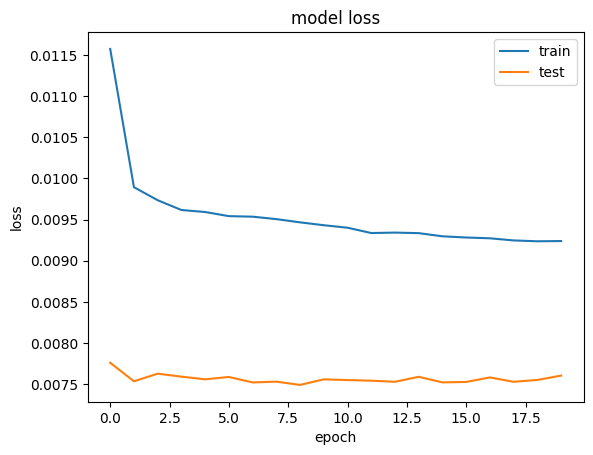

Epoch 1/20
425/425 - 2s - loss: 0.0134 - val_loss: 0.0099 - 2s/epoch - 4ms/step
Epoch 2/20
425/425 - 2s - loss: 0.0134 - val_loss: 0.0099 - 2s/epoch - 4ms/step
Epoch 3/20
425/425 - 2s - loss: 0.0133 - val_loss: 0.0098 - 2s/epoch - 4ms/step
Epoch 4/20
425/425 - 2s - loss: 0.0133 - val_loss: 0.0098 - 2s/epoch - 5ms/step
Epoch 5/20
425/425 - 2s - loss: 0.0133 - val_loss: 0.0098 - 2s/epoch - 5ms/step
Epoch 6/20
425/425 - 2s - loss: 0.0132 - val_loss: 0.0098 - 2s/epoch - 4ms/step
Epoch 7/20
425/425 - 2s - loss: 0.0132 - val_loss: 0.0098 - 2s/epoch - 4ms/step
Epoch 8/20
425/425 - 2s - loss: 0.0132 - val_loss: 0.0098 - 2s/epoch - 4ms/step
Epoch 9/20
425/425 - 2s - loss: 0.0131 - val_loss: 0.0097 - 2s/epoch - 4ms/step
Epoch 10/20
425/425 - 2s - loss: 0.0132 - val_loss: 0.0098 - 2s/epoch - 4ms/step
Epoch 11/20
425/425 - 2s - loss: 0.0131 - val_loss: 0.0098 - 2s/epoch - 4ms/step
Epoch 12/20
425/425 - 2s - loss: 0.0131 - val_loss: 0.0097 - 2s/epoch - 5ms/step
Epoch 13/20
425/425 - 2s - loss: 0.01

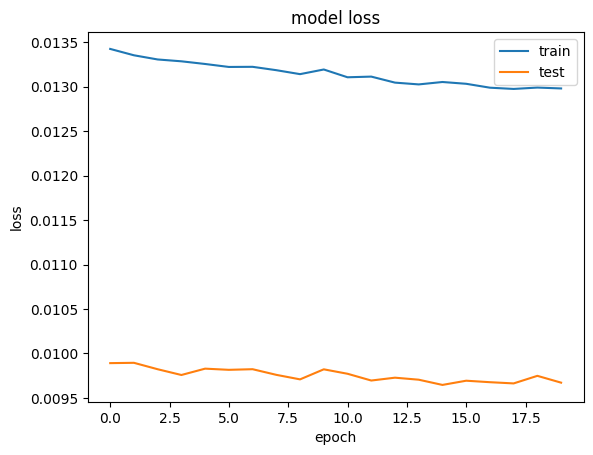

Epoch 1/20
283/283 - 1s - loss: 0.0167 - val_loss: 0.0128 - 1s/epoch - 4ms/step
Epoch 2/20
283/283 - 1s - loss: 0.0168 - val_loss: 0.0123 - 1s/epoch - 4ms/step
Epoch 3/20
283/283 - 1s - loss: 0.0168 - val_loss: 0.0121 - 1s/epoch - 4ms/step
Epoch 4/20
283/283 - 1s - loss: 0.0168 - val_loss: 0.0120 - 1s/epoch - 4ms/step
Epoch 5/20
283/283 - 1s - loss: 0.0167 - val_loss: 0.0119 - 1s/epoch - 5ms/step
Epoch 6/20
283/283 - 2s - loss: 0.0166 - val_loss: 0.0118 - 2s/epoch - 5ms/step
Epoch 7/20
283/283 - 1s - loss: 0.0165 - val_loss: 0.0118 - 1s/epoch - 5ms/step
Epoch 8/20
283/283 - 1s - loss: 0.0166 - val_loss: 0.0117 - 1s/epoch - 4ms/step
Epoch 9/20
283/283 - 1s - loss: 0.0165 - val_loss: 0.0116 - 1s/epoch - 4ms/step
Epoch 10/20
283/283 - 1s - loss: 0.0165 - val_loss: 0.0116 - 1s/epoch - 4ms/step
Epoch 11/20
283/283 - 1s - loss: 0.0165 - val_loss: 0.0117 - 1s/epoch - 4ms/step
Epoch 12/20
283/283 - 1s - loss: 0.0165 - val_loss: 0.0117 - 1s/epoch - 4ms/step
Epoch 13/20
283/283 - 1s - loss: 0.01

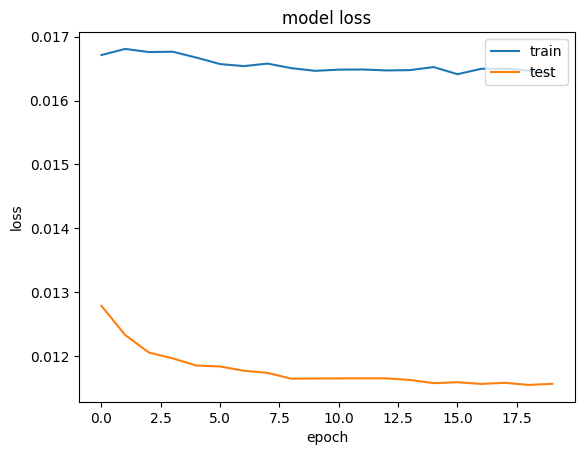

In [24]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

rmse_list = []
y_pred_lstm_list = []
# fit network
for train_x, train_y, test_x, test_y in zip(train_x_list, train_y_list, test_x_list, test_y_list):
  history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(test_x, test_y), verbose=2, shuffle=False)

  # Evaluate on the test set
  y_pred_lstm = model.predict(test_x)
  rmse = np.sqrt(mean_squared_error(test_y, y_pred_lstm))
  rmse_list.append(rmse)
  y_pred_lstm_list.append(y_pred_lstm)
  print(f'Test RMSE: {rmse}')

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()


In [25]:
for i in range(3):
  print(y_pred_lstm_list[i].shape)
  print(test_y_list[i].shape)
  print()

(7348, 1)
(7348,)

(3706, 1)
(3706,)

(2496, 1)
(2496,)



In [27]:
import pickle

with open(f"preds_lstm", 'wb') as file:
  pickle.dump(y_pred_lstm_list, file)

with open(f"y_test_lstm", 'wb') as file:
  pickle.dump(test_y_list, file)

!cp preds_lstm /content/gdrive/MyDrive/term
!cp y_test_lstm /content/gdrive/MyDrive/term

In [ ]:
# aa=[x for x in range(400)]
# plt.plot(aa, inv_y[:400], marker='.', label="actual")
# plt.plot(aa, inv_yhat[:400], 'r', label="prediction")
# plt.ylabel('Global_active_power', size=15)
# plt.xlabel('Time step', size=15)
# plt.legend(fontsize=15)
# plt.show()

--------------------------TRANSFORMER---------------------------

Defines the functions necessary to train the transformer model

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import keras.backend as K

def mape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100
    #diff = K.abs(y_true - y_pred) / K.abs(y_true)
    #return 100. * K.mean(diff)#, axis=-1)

def smape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the Symmetric mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return 100*K.mean(K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))), axis=-1)
    #Symmetric mean absolute percentage error
    #return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)))#, axis=-1)

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mae(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def mase(y_true, y_pred):

    sust = K.mean(K.abs(y_true[:,1:] - y_true[:,:-1]))
    diff = K.mean(K.abs(y_pred - y_true))

    return diff/sust

def coeff_determination(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# convert time series to 2D data for supervised learning
def series_to_supervised(data, train_size=0.5, n_in=1, n_out=1, target_column='target', dropnan=True, scale_X=True):

    df = data.copy()

    # Make sure the target column is the last column in the dataframe
    df['target'] = df[target_column] # Make a copy of the target column
    df = df.drop(columns=[target_column]) # Drop the original target column

    target_location = df.shape[1] - 1 # column index number of target

    # ...X
    #X = df.iloc[:, :target_location]
    X = df.iloc[:,:]

    # ...y
    y = df.iloc[:, [target_location]]

    # Scale the features
    if scale_X:
        #col_names=['target']
        #features = X[col_names]
        features = X[X.columns]
        scalerX = MinMaxScaler().fit(features.values)
        features = scalerX.transform(features.values)

        #X['target'] = features
        X[X.columns] = features

    #n_vars_x = X.shape[1]
    x_vars_labels = X.columns
    y_vars_labels = y.columns

    x_cols, x_names = list(), list()
    y_cols, y_names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        x_cols.append(X.shift(i))
        x_names += [('%s(t-%d)' % (j, i)) for j in x_vars_labels]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        y_cols.append(y.shift(-i))
        if i == 0:
            y_names += [('%s(t)' % (j)) for j in y_vars_labels]
        else:
            y_names += [('%s(t-%d)' % (j, i)) for j in y_vars_labels]

    # put it all together
    x_agg = pd.concat(x_cols, axis=1)
    x_agg.columns = x_names

    y_agg = pd.concat(y_cols, axis=1)
    y_agg.columns = y_names

    agg=pd.concat([x_agg,y_agg], axis=1)
    agg.columns = x_names + y_names
    #print(agg)


    # drop rows with NaN values
    if dropnan:
        x_agg.dropna(inplace=True)
        y_agg.dropna(inplace=True)

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    """
    diff = y_agg.shape[0] - x_agg.shape[0]
    idx = [i for i in range(0, diff)]
    y_agg = y_agg.drop(df.index[idx])"""

    nf = X.shape[1]
    xx = agg.iloc[:,:n_in*nf]
    yy = agg.iloc[:,-n_out:]

    split_index = int(xx.shape[0]*train_size) # the index at which to split df into train and test

    print("**"*100)
    print(int(xx.shape[0]*train_size))

    # ...train
    X_train = xx.iloc[:split_index, :]
    y_train = yy.iloc[:split_index, ]

    # ...test
    X_test = xx.iloc[split_index:, :] # original is split_index:-1
    y_test = yy.iloc[split_index:, ] # original is split_index:-1

    return X_train, y_train, X_test, y_test, scale_X, scalerX

Installs a package necessary to run the code

In [26]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.5 MB/s eta 0:00:00


Initiates the transformer class

In [27]:
# from datetime import datetime
from time import time
import json
import logging

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.callbacks import Callback

from kerastuner.tuners import RandomSearch

from sklearn.metrics import r2_score


# from utils import rmse, coeff_determination, smape


class Transformer(object):
    """ Building the Recurrent Neural Network for Multivariate time series forecasting
    """

    def __init__(self):
        """ Initialization of the object
        """

        with open("/content/gdrive/MyDrive/term/parameters.json") as f:
            parameters = json.load(f)


        # Get model hyperparameters
        self.look_back = parameters["look_back"]
        self.n_features = parameters["n_features"]
        self.horizon = parameters["horizon"]

        # Get directories name
        self.log_dir = parameters["log_dir"]
        self.checkpoint_dir = parameters["checkpoint_dir"]

        self.head_size=256
        self.num_heads=4
        self.ff_dim=4
        self.num_transformer_blocks=4
        self.mlp_units=[128]
        self.mlp_dropout=0.4
        self.dropout=0.25


    def transformer_encoder(self, inputs):

        # Normalization and Attention
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(key_dim=self.head_size, num_heads=self.num_heads, dropout=self.dropout)(x, x)
        x = layers.Dropout(self.dropout)(x)

        res = x + inputs

        # Feed Forward Part
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        return x + res

    def build_lstm(self):
      model = Sequential()
      model.add(LSTM(100, input_shape=(X_train_list[0].shape[1], X_train_list[0].shape[2])))
      model.add(Dropout(0.2))
      model.add(LSTM(70))
      model.add(Dropout(0.3))
      model.add(Reshape((-1, 50)))

      return model

    def build(self):
        """ Build the model architecture
        """

        inputs = keras.Input(shape=(self.look_back, self.n_features))

        for _ in range(self.num_transformer_blocks):
            x = self.transformer_encoder(inputs)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in self.mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(self.mlp_dropout)(x)

        # output layer
        outputs = layers.Dense(self.horizon)(x)

        return keras.Model(inputs, outputs)

    def restore(self,
        filepath):
        """ Restore a previously trained model
        """

        # Load the architecture
        self.best_model = load_model(filepath, custom_objects={'smape': smape,
                                                         #'mape': mape,
                                                         'rmse' : rmse,
                                                         'coeff_determination' : coeff_determination})

        ## added cause with TF 2.4, custom metrics are not recognize custom metrics with only load-model
        self.best_model.compile(
            optimizer='adam',
            loss = ['mse'],
            metrics=[rmse, 'mae', smape, coeff_determination])


    def train(self,
        X_train,
        y_train,
        X_test,
        y_test,
        epochs=200,
        batch_size=64):
        """ Training the network
        :param X_train: training feature vectors [#batch,#number_of_timesteps,#number_of_features]
        :type 3-D Numpy array of float values
        :param Y_train: training target vectors
        :type 2-D Numpy array of float values
        :param epochs: number of training epochs
        :type int
        :param batch_size: size of batches used at each forward/backward propagation
        :type int
        :return -
        :raises: -
        """

        # self.lstm = None
        # self.lstm = self.build_lstm()
        self.model = self.build()
        # self.lstm.compile(loss='mean_squared_error', optimizer='adam')

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss = ['mse'],
                           metrics=[rmse, 'mae', smape, coeff_determination],
                           )
        # print(self.lstm.summary)
        print("**"*100)
        print(self.model.summary())

        # Stop training if error does not improve within 50 iterations
        early_stopping_monitor = EarlyStopping(patience=50, restore_best_weights=True)

        # Save the best model ... with minimal error
        filepath = self.checkpoint_dir+"/Transformer.best"+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

        history = None
        # history = self.lstm.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)
        callback_history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                             #validation_split=0.2,
                             verbose=1,
                             callbacks=[early_stopping_monitor, checkpoint])
                             #callbacks=[PlotLossesKeras(), early_stopping_monitor, checkpoint])

        return self.model, callback_history

   # convert time series to 2D data for supervised learning
    def series_to_supervised(data, train_size=0.5, n_in=1, n_out=1, target_column='target', dropnan=True, scale_X=True):

        df = data.copy()

        # Make sure the target column is the last column in the dataframe
        df['target'] = df[target_column] # Make a copy of the target column
        df = df.drop(columns=[target_column]) # Drop the original target column

        target_location = df.shape[1] - 1 # column index number of target

        # ...X
        #X = df.iloc[:, :target_location]
        X = df.iloc[:,:]

        # ...y
        y = df.iloc[:, [target_location]]

        # Scale the features
        if scale_X:
            #col_names=['target']
            #features = X[col_names]
            features = X[X.columns]
            scalerX = MinMaxScaler().fit(features.values)
            features = scalerX.transform(features.values)

            #X['target'] = features
            X[X.columns] = features

        #n_vars_x = X.shape[1]
        x_vars_labels = X.columns
        y_vars_labels = y.columns

        x_cols, x_names = list(), list()
        y_cols, y_names = list(), list()

        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            x_cols.append(X.shift(i))
            x_names += [('%s(t-%d)' % (j, i)) for j in x_vars_labels]

        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            y_cols.append(y.shift(-i))
            if i == 0:
                y_names += [('%s(t)' % (j)) for j in y_vars_labels]
            else:
                y_names += [('%s(t-%d)' % (j, i)) for j in y_vars_labels]

        # put it all together
        x_agg = pd.concat(x_cols, axis=1)
        x_agg.columns = x_names

        y_agg = pd.concat(y_cols, axis=1)
        y_agg.columns = y_names

        agg=pd.concat([x_agg,y_agg], axis=1)
        agg.columns = x_names + y_names
        #print(agg)


        # drop rows with NaN values
        if dropnan:
            x_agg.dropna(inplace=True)
            y_agg.dropna(inplace=True)

        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)

        """
        diff = y_agg.shape[0] - x_agg.shape[0]
        idx = [i for i in range(0, diff)]
        y_agg = y_agg.drop(df.index[idx])"""

        nf = X.shape[1]
        xx = agg.iloc[:,:n_in*nf]
        yy = agg.iloc[:,-n_out:]

        split_index = 365*24 # the index at which to split df into train and test

        # ...train
        X_train = xx.iloc[:split_index, :]
        y_train = yy.iloc[:split_index, ]

        # ...test
        X_test = xx.iloc[split_index:, :] # original is split_index:-1
        y_test = yy.iloc[split_index:, ] # original is split_index:-1

        return X_train, y_train, X_test, y_test, scale_X, scalerX



    def evaluate(self,
        X_test,
        y_test):
        """ Evaluating the network
        :param X_test: test feature vectors [#batch,#number_of_timesteps,#number_of_features]
        :type 3-D Numpy array of float values
        :param Y_test: test target vectors
        :type 2-D Numpy array of int values
        :return  Evaluation losses
        :rtype 5 Float tuple
        :raise -
        """

        y_pred = self.model.predict(X_test)

        # Print accuracy if ground truth is provided
        """
        if y_test is not None:
            loss_ = session.run(
                self.loss,
                feed_dict=feed_dict)
        """

        _, rmse_result, mae_result, smape_result, _ = self.model.evaluate(X_test, y_test)

        r2_result = r2_score(y_test.flatten(),y_pred.flatten())

        return _, rmse_result, mae_result, smape_result, r2_result, y_pred

<ipython-input-27-f213599d51ef>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Splits the data in to train and test for transformer

In [25]:
dataset = pd.read_csv('household_power_consumption.txt',sep = ';',
                header=0,
                parse_dates={'datetime':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='datetime')

# resample data to daily
data_groups = []

hourly_data_resample = dataset.resample('h')
hourly_data = hourly_data_resample.mean()
data_groups.append(hourly_data)

quad_hourly_data_resample = dataset.resample('2H')
quad_hourly_data = quad_hourly_data_resample.mean()
data_groups.append(quad_hourly_data)

sixteen_hourly_data_resample = dataset.resample('3H')
sixteen_hourly_data = sixteen_hourly_data_resample.mean()
data_groups.append(sixteen_hourly_data)

# daily_data_resample = dataset.resample('24H')
# daily_data = daily_data_resample.sum()
# data_groups.append(daily_data)

# We choose to keep only Global_active_power
# to_drop = ['Global_reactive_power', 'Voltage',
#        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
#        'Sub_metering_3']
# daily_data.drop(columns=to_drop, inplace=True)

# add calendar-related features
for i in range(len(data_groups)):
  data_groups[i]['day'] = pd.DatetimeIndex(data_groups[i].index).day
  data_groups[i]['weekday'] = ((pd.DatetimeIndex(data_groups[i].index).dayofweek) // 5 == 1).astype(float)
  data_groups[i]['season'] = [month%12 // 3 + 1 for month in pd.DatetimeIndex(data_groups[i].index).month]

# summarize
# print(daily_data.info())
#print(daily_data.head())

look_back = 7
n_features_group = []

for i in range(len(data_groups)):
  n_features_group.append(data_groups[i].shape[1])

# print(daily_data.shape[1])
# print('**'*100)

X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []
# Walk-forward data split to avoid data leakage
for i in range(len(data_groups)):
  X_train, y_train, X_test, y_test, scale_X, scalerX = series_to_supervised(data_groups[i], train_size=0.8, n_in=look_back, n_out=7, target_column='Global_active_power', dropnan=True, scale_X=True)

  X_train_reshaped = X_train.values.reshape((-1,look_back,n_features_group[i]))
  print(X_train_reshaped.shape)
  print()
  X_test_reshaped = X_test.values.reshape((-1,look_back,n_features_group[i]))
  y_train_reshaped = y_train.values
  y_test_reshaped = y_test.values

  X_train_list.append(X_train_reshaped)
  y_train_list.append(y_train_reshaped)
  X_test_list.append(X_test_reshaped)
  y_test_list.append(y_test_reshaped)

********************************************************************************************************************************************************************************************************
27240
(27240, 7, 10)

********************************************************************************************************************************************************************************************************
13588
(13588, 7, 10)

********************************************************************************************************************************************************************************************************
9034
(9034, 7, 10)



In [28]:
print(X_train_list[0].shape)
print(y_train_list[0].shape)
print(X_test_list[0].shape)
print(y_test_list[0].shape)

print(X_train_list[1].shape)
print(y_train_list[1].shape)
print(X_test_list[1].shape)
print(y_test_list[1].shape)

(27240, 7, 10)
(27240, 7)
(6811, 7, 10)
(6811, 7)
(13588, 7, 10)
(13588, 7)
(3398, 7, 10)
(3398, 7)


Trains the transformer model

In [ ]:
## Testing the Transformer
tr = Transformer()
y_pred_transformer_list = []
for i in range(len(X_train_list)):
  # model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)
  model_transformer, history_transformer = tr.train(X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i])
  _, rmse_result, mae_result, smape_result, r2_result, y_pred_transformer = tr.evaluate(X_test_list[i],y_test_list[i])
  y_pred_transformer_list.append(y_pred_transformer)

********************************************************************************************************************************************************************************************************
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7, 10)]              0         []                            
                                                                                                  
 layer_normalization_6 (Lay  (None, 7, 10)                20        ['input_1[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_3 (Mu  (None, 7, 10)                44042     ['layer_normalization_6


Epoch 1: loss improved from inf to 1.27509, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 18s 7ms/step - loss: 1.2751 - rmse: 1.1132 - mae: 0.8390 - smape: 48.2189 - coeff_determination: -0.4809
Epoch 2/200
 16/426 [>.............................] - ETA: 2s - loss: 0.9725 - rmse: 0.9850 - mae: 0.7610 - smape: 36.3230 - coeff_determination: -0.1330

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


426/426 [==============================] - ETA: 0s - loss: 0.9161 - rmse: 0.9549 - mae: 0.7391 - smape: 35.6165 - coeff_determination: -0.0674


Epoch 2: loss improved from 1.27509 to 0.91607, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.9161 - rmse: 0.9549 - mae: 0.7391 - smape: 35.6165 - coeff_determination: -0.0674
Epoch 3/200
425/426 [============================>.] - ETA: 0s - loss: 0.8757 - rmse: 0.9337 - mae: 0.7278 - smape: 35.1340 - coeff_determination: -0.0213


Epoch 3: loss improved from 0.91607 to 0.87613, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.8761 - rmse: 0.9341 - mae: 0.7279 - smape: 35.1339 - coeff_determination: -0.0214
Epoch 4/200
421/426 [============================>.] - ETA: 0s - loss: 0.8545 - rmse: 0.9219 - mae: 0.7203 - smape: 34.7979 - coeff_determination: 0.0037


Epoch 4: loss improved from 0.87613 to 0.85475, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.8547 - rmse: 0.9222 - mae: 0.7204 - smape: 34.7935 - coeff_determination: 0.0038
Epoch 5/200
424/426 [============================>.] - ETA: 0s - loss: 0.8424 - rmse: 0.9157 - mae: 0.7164 - smape: 34.6330 - coeff_determination: 0.0180


Epoch 5: loss improved from 0.85475 to 0.84205, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.8420 - rmse: 0.9154 - mae: 0.7163 - smape: 34.6251 - coeff_determination: 0.0185
Epoch 6/200
426/426 [==============================] - ETA: 0s - loss: 0.8317 - rmse: 0.9100 - mae: 0.7130 - smape: 34.4724 - coeff_determination: 0.0309


Epoch 6: loss improved from 0.84205 to 0.83168, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.8317 - rmse: 0.9100 - mae: 0.7130 - smape: 34.4724 - coeff_determination: 0.0309
Epoch 7/200
423/426 [============================>.] - ETA: 0s - loss: 0.8220 - rmse: 0.9046 - mae: 0.7086 - smape: 34.3077 - coeff_determination: 0.0427


Epoch 7: loss improved from 0.83168 to 0.82153, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.8215 - rmse: 0.9042 - mae: 0.7085 - smape: 34.3065 - coeff_determination: 0.0427
Epoch 8/200
426/426 [==============================] - ETA: 0s - loss: 0.8081 - rmse: 0.8971 - mae: 0.7015 - smape: 33.9915 - coeff_determination: 0.0576


Epoch 8: loss improved from 0.82153 to 0.80814, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.8081 - rmse: 0.8971 - mae: 0.7015 - smape: 33.9915 - coeff_determination: 0.0576
Epoch 9/200
421/426 [============================>.] - ETA: 0s - loss: 0.7961 - rmse: 0.8902 - mae: 0.6933 - smape: 33.6277 - coeff_determination: 0.0716


Epoch 9: loss improved from 0.80814 to 0.79616, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.7962 - rmse: 0.8902 - mae: 0.6932 - smape: 33.6229 - coeff_determination: 0.0721
Epoch 10/200
421/426 [============================>.] - ETA: 0s - loss: 0.7785 - rmse: 0.8804 - mae: 0.6836 - smape: 33.1900 - coeff_determination: 0.0920


Epoch 10: loss improved from 0.79616 to 0.77911, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 8ms/step - loss: 0.7791 - rmse: 0.8809 - mae: 0.6837 - smape: 33.1869 - coeff_determination: 0.0919
Epoch 11/200
421/426 [============================>.] - ETA: 0s - loss: 0.7687 - rmse: 0.8743 - mae: 0.6762 - smape: 32.8264 - coeff_determination: 0.1036


Epoch 11: loss improved from 0.77911 to 0.76887, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7689 - rmse: 0.8744 - mae: 0.6761 - smape: 32.8344 - coeff_determination: 0.1033
Epoch 12/200
426/426 [==============================] - ETA: 0s - loss: 0.7542 - rmse: 0.8664 - mae: 0.6674 - smape: 32.4647 - coeff_determination: 0.1218


Epoch 12: loss improved from 0.76887 to 0.75424, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7542 - rmse: 0.8664 - mae: 0.6674 - smape: 32.4647 - coeff_determination: 0.1218
Epoch 13/200
424/426 [============================>.] - ETA: 0s - loss: 0.7441 - rmse: 0.8602 - mae: 0.6630 - smape: 32.2959 - coeff_determination: 0.1328


Epoch 13: loss improved from 0.75424 to 0.74399, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.7440 - rmse: 0.8602 - mae: 0.6630 - smape: 32.2939 - coeff_determination: 0.1326
Epoch 14/200
425/426 [============================>.] - ETA: 0s - loss: 0.7366 - rmse: 0.8560 - mae: 0.6582 - smape: 32.1011 - coeff_determination: 0.1425


Epoch 14: loss improved from 0.74399 to 0.73675, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.7368 - rmse: 0.8562 - mae: 0.6583 - smape: 32.1079 - coeff_determination: 0.1425
Epoch 15/200
423/426 [============================>.] - ETA: 0s - loss: 0.7288 - rmse: 0.8515 - mae: 0.6547 - smape: 31.9579 - coeff_determination: 0.1496


Epoch 15: loss improved from 0.73675 to 0.72867, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 8ms/step - loss: 0.7287 - rmse: 0.8514 - mae: 0.6546 - smape: 31.9547 - coeff_determination: 0.1495
Epoch 16/200
426/426 [==============================] - ETA: 0s - loss: 0.7280 - rmse: 0.8509 - mae: 0.6552 - smape: 31.9858 - coeff_determination: 0.1509


Epoch 16: loss improved from 0.72867 to 0.72798, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7280 - rmse: 0.8509 - mae: 0.6552 - smape: 31.9858 - coeff_determination: 0.1509
Epoch 17/200
426/426 [==============================] - ETA: 0s - loss: 0.7215 - rmse: 0.8473 - mae: 0.6509 - smape: 31.8044 - coeff_determination: 0.1589


Epoch 17: loss improved from 0.72798 to 0.72154, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7215 - rmse: 0.8473 - mae: 0.6509 - smape: 31.8044 - coeff_determination: 0.1589
Epoch 18/200
424/426 [============================>.] - ETA: 0s - loss: 0.7177 - rmse: 0.8448 - mae: 0.6490 - smape: 31.7175 - coeff_determination: 0.1636


Epoch 18: loss improved from 0.72154 to 0.71770, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.7177 - rmse: 0.8448 - mae: 0.6489 - smape: 31.7105 - coeff_determination: 0.1634
Epoch 19/200
423/426 [============================>.] - ETA: 0s - loss: 0.7130 - rmse: 0.8422 - mae: 0.6471 - smape: 31.6626 - coeff_determination: 0.1694


Epoch 19: loss improved from 0.71770 to 0.71284, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.7128 - rmse: 0.8421 - mae: 0.6471 - smape: 31.6653 - coeff_determination: 0.1694
Epoch 20/200
426/426 [==============================] - ETA: 0s - loss: 0.7136 - rmse: 0.8423 - mae: 0.6469 - smape: 31.6435 - coeff_determination: 0.1692


Epoch 20: loss did not improve from 0.71284
426/426 [==============================] - 6s 13ms/step - loss: 0.7136 - rmse: 0.8423 - mae: 0.6469 - smape: 31.6435 - coeff_determination: 0.1692
Epoch 21/200
422/426 [============================>.] - ETA: 0s - loss: 0.7082 - rmse: 0.8392 - mae: 0.6446 - smape: 31.5604 - coeff_determination: 0.1739


Epoch 21: loss improved from 0.71284 to 0.70838, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7084 - rmse: 0.8393 - mae: 0.6446 - smape: 31.5530 - coeff_determination: 0.1738
Epoch 22/200
422/426 [============================>.] - ETA: 0s - loss: 0.7106 - rmse: 0.8407 - mae: 0.6453 - smape: 31.5550 - coeff_determination: 0.1711


Epoch 22: loss did not improve from 0.70838
426/426 [==============================] - 3s 7ms/step - loss: 0.7099 - rmse: 0.8403 - mae: 0.6450 - smape: 31.5469 - coeff_determination: 0.1715
Epoch 23/200
422/426 [============================>.] - ETA: 0s - loss: 0.7052 - rmse: 0.8376 - mae: 0.6422 - smape: 31.4335 - coeff_determination: 0.1767


Epoch 23: loss improved from 0.70838 to 0.70572, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.7057 - rmse: 0.8381 - mae: 0.6423 - smape: 31.4352 - coeff_determination: 0.1766
Epoch 24/200
421/426 [============================>.] - ETA: 0s - loss: 0.7040 - rmse: 0.8369 - mae: 0.6419 - smape: 31.4038 - coeff_determination: 0.1795


Epoch 24: loss improved from 0.70572 to 0.70381, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.7038 - rmse: 0.8369 - mae: 0.6418 - smape: 31.4005 - coeff_determination: 0.1791
Epoch 25/200
423/426 [============================>.] - ETA: 0s - loss: 0.7038 - rmse: 0.8365 - mae: 0.6410 - smape: 31.3602 - coeff_determination: 0.1795


Epoch 25: loss improved from 0.70381 to 0.70335, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7033 - rmse: 0.8363 - mae: 0.6408 - smape: 31.3597 - coeff_determination: 0.1792
Epoch 26/200
421/426 [============================>.] - ETA: 0s - loss: 0.7010 - rmse: 0.8351 - mae: 0.6402 - smape: 31.3339 - coeff_determination: 0.1837


Epoch 26: loss improved from 0.70335 to 0.70057, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.7006 - rmse: 0.8349 - mae: 0.6402 - smape: 31.3468 - coeff_determination: 0.1833
Epoch 27/200
426/426 [==============================] - ETA: 0s - loss: 0.6989 - rmse: 0.8340 - mae: 0.6385 - smape: 31.2778 - coeff_determination: 0.1849


Epoch 27: loss improved from 0.70057 to 0.69886, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6989 - rmse: 0.8340 - mae: 0.6385 - smape: 31.2778 - coeff_determination: 0.1849
Epoch 28/200
426/426 [==============================] - ETA: 0s - loss: 0.6980 - rmse: 0.8332 - mae: 0.6381 - smape: 31.2555 - coeff_determination: 0.1868


Epoch 28: loss improved from 0.69886 to 0.69797, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6980 - rmse: 0.8332 - mae: 0.6381 - smape: 31.2555 - coeff_determination: 0.1868
Epoch 29/200
424/426 [============================>.] - ETA: 0s - loss: 0.6941 - rmse: 0.8313 - mae: 0.6357 - smape: 31.1596 - coeff_determination: 0.1911


Epoch 29: loss improved from 0.69797 to 0.69407, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6941 - rmse: 0.8312 - mae: 0.6357 - smape: 31.1567 - coeff_determination: 0.1910
Epoch 30/200
419/426 [============================>.] - ETA: 0s - loss: 0.6954 - rmse: 0.8317 - mae: 0.6371 - smape: 31.2172 - coeff_determination: 0.1909


Epoch 30: loss did not improve from 0.69407
426/426 [==============================] - 3s 7ms/step - loss: 0.6947 - rmse: 0.8313 - mae: 0.6367 - smape: 31.2056 - coeff_determination: 0.1908
Epoch 31/200
425/426 [============================>.] - ETA: 0s - loss: 0.6915 - rmse: 0.8293 - mae: 0.6347 - smape: 31.1111 - coeff_determination: 0.1936


Epoch 31: loss improved from 0.69407 to 0.69153, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6915 - rmse: 0.8294 - mae: 0.6347 - smape: 31.1136 - coeff_determination: 0.1934
Epoch 32/200
421/426 [============================>.] - ETA: 0s - loss: 0.6943 - rmse: 0.8310 - mae: 0.6353 - smape: 31.1287 - coeff_determination: 0.1906


Epoch 32: loss did not improve from 0.69153
426/426 [==============================] - 3s 8ms/step - loss: 0.6937 - rmse: 0.8305 - mae: 0.6350 - smape: 31.1324 - coeff_determination: 0.1909
Epoch 33/200
425/426 [============================>.] - ETA: 0s - loss: 0.6937 - rmse: 0.8307 - mae: 0.6356 - smape: 31.1468 - coeff_determination: 0.1905


Epoch 33: loss did not improve from 0.69153
426/426 [==============================] - 4s 10ms/step - loss: 0.6940 - rmse: 0.8310 - mae: 0.6357 - smape: 31.1516 - coeff_determination: 0.1904
Epoch 34/200
421/426 [============================>.] - ETA: 0s - loss: 0.6920 - rmse: 0.8293 - mae: 0.6348 - smape: 31.1284 - coeff_determination: 0.1930


Epoch 34: loss did not improve from 0.69153
426/426 [==============================] - 4s 8ms/step - loss: 0.6924 - rmse: 0.8295 - mae: 0.6349 - smape: 31.1331 - coeff_determination: 0.1928
Epoch 35/200
420/426 [============================>.] - ETA: 0s - loss: 0.6889 - rmse: 0.8278 - mae: 0.6329 - smape: 31.0506 - coeff_determination: 0.1980


Epoch 35: loss improved from 0.69153 to 0.68895, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6890 - rmse: 0.8277 - mae: 0.6331 - smape: 31.0542 - coeff_determination: 0.1979
Epoch 36/200
419/426 [============================>.] - ETA: 0s - loss: 0.6903 - rmse: 0.8290 - mae: 0.6333 - smape: 31.0837 - coeff_determination: 0.1950


Epoch 36: loss did not improve from 0.68895
426/426 [==============================] - 3s 7ms/step - loss: 0.6896 - rmse: 0.8284 - mae: 0.6329 - smape: 31.0671 - coeff_determination: 0.1952
Epoch 37/200
424/426 [============================>.] - ETA: 0s - loss: 0.6851 - rmse: 0.8256 - mae: 0.6314 - smape: 30.9982 - coeff_determination: 0.2019


Epoch 37: loss improved from 0.68895 to 0.68503, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6850 - rmse: 0.8255 - mae: 0.6314 - smape: 30.9990 - coeff_determination: 0.2019
Epoch 38/200
421/426 [============================>.] - ETA: 0s - loss: 0.6885 - rmse: 0.8275 - mae: 0.6321 - smape: 30.9969 - coeff_determination: 0.1977


Epoch 38: loss did not improve from 0.68503
426/426 [==============================] - 4s 10ms/step - loss: 0.6881 - rmse: 0.8273 - mae: 0.6320 - smape: 31.0022 - coeff_determination: 0.1972
Epoch 39/200
424/426 [============================>.] - ETA: 0s - loss: 0.6851 - rmse: 0.8254 - mae: 0.6308 - smape: 30.9757 - coeff_determination: 0.2027


Epoch 39: loss did not improve from 0.68503
426/426 [==============================] - 3s 8ms/step - loss: 0.6852 - rmse: 0.8255 - mae: 0.6308 - smape: 30.9744 - coeff_determination: 0.2026
Epoch 40/200
422/426 [============================>.] - ETA: 0s - loss: 0.6874 - rmse: 0.8267 - mae: 0.6320 - smape: 30.9932 - coeff_determination: 0.1995


Epoch 40: loss did not improve from 0.68503
426/426 [==============================] - 3s 7ms/step - loss: 0.6872 - rmse: 0.8265 - mae: 0.6319 - smape: 30.9976 - coeff_determination: 0.1995
Epoch 41/200
421/426 [============================>.] - ETA: 0s - loss: 0.6845 - rmse: 0.8253 - mae: 0.6301 - smape: 30.9481 - coeff_determination: 0.2012


Epoch 41: loss did not improve from 0.68503
426/426 [==============================] - 3s 7ms/step - loss: 0.6851 - rmse: 0.8256 - mae: 0.6303 - smape: 30.9476 - coeff_determination: 0.2006
Epoch 42/200
423/426 [============================>.] - ETA: 0s - loss: 0.6858 - rmse: 0.8260 - mae: 0.6308 - smape: 30.9459 - coeff_determination: 0.2013


Epoch 42: loss did not improve from 0.68503
426/426 [==============================] - 3s 8ms/step - loss: 0.6855 - rmse: 0.8257 - mae: 0.6308 - smape: 30.9526 - coeff_determination: 0.2013
Epoch 43/200
426/426 [==============================] - ETA: 0s - loss: 0.6837 - rmse: 0.8247 - mae: 0.6297 - smape: 30.9288 - coeff_determination: 0.2022


Epoch 43: loss improved from 0.68503 to 0.68368, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6837 - rmse: 0.8247 - mae: 0.6297 - smape: 30.9288 - coeff_determination: 0.2022
Epoch 44/200
422/426 [============================>.] - ETA: 0s - loss: 0.6834 - rmse: 0.8247 - mae: 0.6300 - smape: 30.9290 - coeff_determination: 0.2027


Epoch 44: loss improved from 0.68368 to 0.68309, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6831 - rmse: 0.8245 - mae: 0.6298 - smape: 30.9248 - coeff_determination: 0.2036
Epoch 45/200
420/426 [============================>.] - ETA: 0s - loss: 0.6780 - rmse: 0.8215 - mae: 0.6270 - smape: 30.8288 - coeff_determination: 0.2074


Epoch 45: loss improved from 0.68309 to 0.67938, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6794 - rmse: 0.8223 - mae: 0.6275 - smape: 30.8260 - coeff_determination: 0.2073
Epoch 46/200
424/426 [============================>.] - ETA: 0s - loss: 0.6819 - rmse: 0.8234 - mae: 0.6287 - smape: 30.8653 - coeff_determination: 0.2044


Epoch 46: loss did not improve from 0.67938
426/426 [==============================] - 3s 7ms/step - loss: 0.6814 - rmse: 0.8230 - mae: 0.6285 - smape: 30.8594 - coeff_determination: 0.2046
Epoch 47/200
425/426 [============================>.] - ETA: 0s - loss: 0.6830 - rmse: 0.8241 - mae: 0.6295 - smape: 30.9149 - coeff_determination: 0.2045


Epoch 47: loss did not improve from 0.67938
426/426 [==============================] - 3s 8ms/step - loss: 0.6828 - rmse: 0.8239 - mae: 0.6294 - smape: 30.9156 - coeff_determination: 0.2046
Epoch 48/200
425/426 [============================>.] - ETA: 0s - loss: 0.6776 - rmse: 0.8207 - mae: 0.6272 - smape: 30.8152 - coeff_determination: 0.2099


Epoch 48: loss improved from 0.67938 to 0.67739, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6774 - rmse: 0.8205 - mae: 0.6272 - smape: 30.8165 - coeff_determination: 0.2098
Epoch 49/200
421/426 [============================>.] - ETA: 0s - loss: 0.6804 - rmse: 0.8225 - mae: 0.6280 - smape: 30.8437 - coeff_determination: 0.2061


Epoch 49: loss did not improve from 0.67739
426/426 [==============================] - 3s 8ms/step - loss: 0.6803 - rmse: 0.8224 - mae: 0.6279 - smape: 30.8390 - coeff_determination: 0.2059
Epoch 50/200
424/426 [============================>.] - ETA: 0s - loss: 0.6775 - rmse: 0.8206 - mae: 0.6265 - smape: 30.7993 - coeff_determination: 0.2099


Epoch 50: loss did not improve from 0.67739
426/426 [==============================] - 3s 7ms/step - loss: 0.6778 - rmse: 0.8208 - mae: 0.6267 - smape: 30.8003 - coeff_determination: 0.2097
Epoch 51/200
420/426 [============================>.] - ETA: 0s - loss: 0.6780 - rmse: 0.8210 - mae: 0.6267 - smape: 30.7853 - coeff_determination: 0.2092


Epoch 51: loss did not improve from 0.67739
426/426 [==============================] - 3s 7ms/step - loss: 0.6782 - rmse: 0.8212 - mae: 0.6269 - smape: 30.7866 - coeff_determination: 0.2092
Epoch 52/200
423/426 [============================>.] - ETA: 0s - loss: 0.6814 - rmse: 0.8231 - mae: 0.6279 - smape: 30.8271 - coeff_determination: 0.2066


Epoch 52: loss did not improve from 0.67739
426/426 [==============================] - 4s 8ms/step - loss: 0.6806 - rmse: 0.8226 - mae: 0.6276 - smape: 30.8253 - coeff_determination: 0.2072
Epoch 53/200
422/426 [============================>.] - ETA: 0s - loss: 0.6763 - rmse: 0.8203 - mae: 0.6263 - smape: 30.7816 - coeff_determination: 0.2110


Epoch 53: loss improved from 0.67739 to 0.67673, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6767 - rmse: 0.8205 - mae: 0.6265 - smape: 30.7863 - coeff_determination: 0.2112
Epoch 54/200
419/426 [============================>.] - ETA: 0s - loss: 0.6781 - rmse: 0.8211 - mae: 0.6265 - smape: 30.7646 - coeff_determination: 0.2107


Epoch 54: loss did not improve from 0.67673
426/426 [==============================] - 3s 8ms/step - loss: 0.6779 - rmse: 0.8210 - mae: 0.6265 - smape: 30.7669 - coeff_determination: 0.2103
Epoch 55/200
419/426 [============================>.] - ETA: 0s - loss: 0.6754 - rmse: 0.8196 - mae: 0.6251 - smape: 30.7210 - coeff_determination: 0.2110


Epoch 55: loss improved from 0.67673 to 0.67616, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6762 - rmse: 0.8202 - mae: 0.6253 - smape: 30.7297 - coeff_determination: 0.2111
Epoch 56/200
424/426 [============================>.] - ETA: 0s - loss: 0.6733 - rmse: 0.8186 - mae: 0.6242 - smape: 30.6852 - coeff_determination: 0.2156


Epoch 56: loss improved from 0.67616 to 0.67307, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6731 - rmse: 0.8184 - mae: 0.6241 - smape: 30.6825 - coeff_determination: 0.2153
Epoch 57/200
423/426 [============================>.] - ETA: 0s - loss: 0.6729 - rmse: 0.8179 - mae: 0.6239 - smape: 30.6702 - coeff_determination: 0.2157


Epoch 57: loss improved from 0.67307 to 0.67307, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6731 - rmse: 0.8179 - mae: 0.6240 - smape: 30.6763 - coeff_determination: 0.2158
Epoch 58/200
425/426 [============================>.] - ETA: 0s - loss: 0.6730 - rmse: 0.8181 - mae: 0.6241 - smape: 30.6814 - coeff_determination: 0.2159


Epoch 58: loss improved from 0.67307 to 0.67294, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6729 - rmse: 0.8181 - mae: 0.6241 - smape: 30.6801 - coeff_determination: 0.2159
Epoch 59/200
421/426 [============================>.] - ETA: 0s - loss: 0.6718 - rmse: 0.8171 - mae: 0.6233 - smape: 30.6744 - coeff_determination: 0.2166


Epoch 59: loss improved from 0.67294 to 0.67209, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6721 - rmse: 0.8173 - mae: 0.6234 - smape: 30.6703 - coeff_determination: 0.2166
Epoch 60/200
426/426 [==============================] - ETA: 0s - loss: 0.6743 - rmse: 0.8188 - mae: 0.6242 - smape: 30.6676 - coeff_determination: 0.2139


Epoch 60: loss did not improve from 0.67209
426/426 [==============================] - 3s 7ms/step - loss: 0.6743 - rmse: 0.8188 - mae: 0.6242 - smape: 30.6676 - coeff_determination: 0.2139
Epoch 61/200
422/426 [============================>.] - ETA: 0s - loss: 0.6727 - rmse: 0.8183 - mae: 0.6237 - smape: 30.6792 - coeff_determination: 0.2150


Epoch 61: loss did not improve from 0.67209
426/426 [==============================] - 3s 7ms/step - loss: 0.6728 - rmse: 0.8183 - mae: 0.6237 - smape: 30.6786 - coeff_determination: 0.2150
Epoch 62/200
425/426 [============================>.] - ETA: 0s - loss: 0.6722 - rmse: 0.8174 - mae: 0.6238 - smape: 30.6774 - coeff_determination: 0.2166


Epoch 62: loss did not improve from 0.67209
426/426 [==============================] - 4s 9ms/step - loss: 0.6725 - rmse: 0.8176 - mae: 0.6239 - smape: 30.6800 - coeff_determination: 0.2165
Epoch 63/200
425/426 [============================>.] - ETA: 0s - loss: 0.6701 - rmse: 0.8163 - mae: 0.6226 - smape: 30.6435 - coeff_determination: 0.2191


Epoch 63: loss improved from 0.67209 to 0.67039, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6704 - rmse: 0.8166 - mae: 0.6227 - smape: 30.6408 - coeff_determination: 0.2189
Epoch 64/200
424/426 [============================>.] - ETA: 0s - loss: 0.6707 - rmse: 0.8169 - mae: 0.6230 - smape: 30.6282 - coeff_determination: 0.2188


Epoch 64: loss did not improve from 0.67039
426/426 [==============================] - 3s 7ms/step - loss: 0.6709 - rmse: 0.8170 - mae: 0.6231 - smape: 30.6309 - coeff_determination: 0.2189
Epoch 65/200
426/426 [==============================] - ETA: 0s - loss: 0.6698 - rmse: 0.8162 - mae: 0.6222 - smape: 30.6037 - coeff_determination: 0.2199


Epoch 65: loss improved from 0.67039 to 0.66979, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6698 - rmse: 0.8162 - mae: 0.6222 - smape: 30.6037 - coeff_determination: 0.2199
Epoch 66/200
425/426 [============================>.] - ETA: 0s - loss: 0.6690 - rmse: 0.8158 - mae: 0.6220 - smape: 30.5970 - coeff_determination: 0.2197


Epoch 66: loss improved from 0.66979 to 0.66881, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6688 - rmse: 0.8156 - mae: 0.6219 - smape: 30.5917 - coeff_determination: 0.2202
Epoch 67/200
423/426 [============================>.] - ETA: 0s - loss: 0.6683 - rmse: 0.8153 - mae: 0.6218 - smape: 30.5646 - coeff_determination: 0.2218


Epoch 67: loss improved from 0.66881 to 0.66827, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6683 - rmse: 0.8153 - mae: 0.6217 - smape: 30.5598 - coeff_determination: 0.2216
Epoch 68/200
422/426 [============================>.] - ETA: 0s - loss: 0.6669 - rmse: 0.8144 - mae: 0.6209 - smape: 30.5462 - coeff_determination: 0.2229


Epoch 68: loss improved from 0.66827 to 0.66678, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6668 - rmse: 0.8144 - mae: 0.6209 - smape: 30.5531 - coeff_determination: 0.2230
Epoch 69/200
426/426 [==============================] - ETA: 0s - loss: 0.6680 - rmse: 0.8153 - mae: 0.6208 - smape: 30.5420 - coeff_determination: 0.2221


Epoch 69: loss did not improve from 0.66678
426/426 [==============================] - 3s 7ms/step - loss: 0.6680 - rmse: 0.8153 - mae: 0.6208 - smape: 30.5420 - coeff_determination: 0.2221
Epoch 70/200
420/426 [============================>.] - ETA: 0s - loss: 0.6657 - rmse: 0.8137 - mae: 0.6202 - smape: 30.5278 - coeff_determination: 0.2249


Epoch 70: loss improved from 0.66678 to 0.66621, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6662 - rmse: 0.8141 - mae: 0.6203 - smape: 30.5268 - coeff_determination: 0.2248
Epoch 71/200
424/426 [============================>.] - ETA: 0s - loss: 0.6676 - rmse: 0.8148 - mae: 0.6211 - smape: 30.5624 - coeff_determination: 0.2219


Epoch 71: loss did not improve from 0.66621
426/426 [==============================] - 3s 7ms/step - loss: 0.6674 - rmse: 0.8146 - mae: 0.6210 - smape: 30.5586 - coeff_determination: 0.2223
Epoch 72/200
423/426 [============================>.] - ETA: 0s - loss: 0.6663 - rmse: 0.8140 - mae: 0.6202 - smape: 30.5256 - coeff_determination: 0.2236


Epoch 72: loss did not improve from 0.66621
426/426 [==============================] - 4s 9ms/step - loss: 0.6666 - rmse: 0.8142 - mae: 0.6202 - smape: 30.5250 - coeff_determination: 0.2233
Epoch 73/200
426/426 [==============================] - ETA: 0s - loss: 0.6674 - rmse: 0.8145 - mae: 0.6210 - smape: 30.5506 - coeff_determination: 0.2231


Epoch 73: loss did not improve from 0.66621
426/426 [==============================] - 4s 10ms/step - loss: 0.6674 - rmse: 0.8145 - mae: 0.6210 - smape: 30.5506 - coeff_determination: 0.2231
Epoch 74/200
424/426 [============================>.] - ETA: 0s - loss: 0.6654 - rmse: 0.8138 - mae: 0.6198 - smape: 30.5062 - coeff_determination: 0.2243


Epoch 74: loss improved from 0.66621 to 0.66516, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6652 - rmse: 0.8135 - mae: 0.6197 - smape: 30.4984 - coeff_determination: 0.2246
Epoch 75/200
419/426 [============================>.] - ETA: 0s - loss: 0.6644 - rmse: 0.8128 - mae: 0.6189 - smape: 30.4618 - coeff_determination: 0.2246


Epoch 75: loss improved from 0.66516 to 0.66455, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6645 - rmse: 0.8128 - mae: 0.6192 - smape: 30.4755 - coeff_determination: 0.2247
Epoch 76/200
422/426 [============================>.] - ETA: 0s - loss: 0.6649 - rmse: 0.8132 - mae: 0.6193 - smape: 30.4688 - coeff_determination: 0.2266


Epoch 76: loss improved from 0.66455 to 0.66401, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6640 - rmse: 0.8126 - mae: 0.6189 - smape: 30.4651 - coeff_determination: 0.2269
Epoch 77/200
422/426 [============================>.] - ETA: 0s - loss: 0.6633 - rmse: 0.8122 - mae: 0.6191 - smape: 30.4938 - coeff_determination: 0.2266


Epoch 77: loss did not improve from 0.66401
426/426 [==============================] - 4s 9ms/step - loss: 0.6641 - rmse: 0.8128 - mae: 0.6194 - smape: 30.5007 - coeff_determination: 0.2262
Epoch 78/200
420/426 [============================>.] - ETA: 0s - loss: 0.6631 - rmse: 0.8121 - mae: 0.6185 - smape: 30.4358 - coeff_determination: 0.2273


Epoch 78: loss improved from 0.66401 to 0.66283, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6628 - rmse: 0.8119 - mae: 0.6184 - smape: 30.4332 - coeff_determination: 0.2268
Epoch 79/200
422/426 [============================>.] - ETA: 0s - loss: 0.6633 - rmse: 0.8123 - mae: 0.6193 - smape: 30.4834 - coeff_determination: 0.2256


Epoch 79: loss did not improve from 0.66283
426/426 [==============================] - 3s 7ms/step - loss: 0.6635 - rmse: 0.8125 - mae: 0.6194 - smape: 30.4901 - coeff_determination: 0.2258
Epoch 80/200
422/426 [============================>.] - ETA: 0s - loss: 0.6623 - rmse: 0.8115 - mae: 0.6180 - smape: 30.4224 - coeff_determination: 0.2280


Epoch 80: loss improved from 0.66283 to 0.66283, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6628 - rmse: 0.8118 - mae: 0.6181 - smape: 30.4260 - coeff_determination: 0.2276
Epoch 81/200
424/426 [============================>.] - ETA: 0s - loss: 0.6608 - rmse: 0.8107 - mae: 0.6172 - smape: 30.4047 - coeff_determination: 0.2293


Epoch 81: loss improved from 0.66283 to 0.66080, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6608 - rmse: 0.8108 - mae: 0.6173 - smape: 30.4050 - coeff_determination: 0.2293
Epoch 82/200
426/426 [==============================] - ETA: 0s - loss: 0.6632 - rmse: 0.8119 - mae: 0.6188 - smape: 30.4646 - coeff_determination: 0.2265


Epoch 82: loss did not improve from 0.66080
426/426 [==============================] - 4s 10ms/step - loss: 0.6632 - rmse: 0.8119 - mae: 0.6188 - smape: 30.4646 - coeff_determination: 0.2265
Epoch 83/200
422/426 [============================>.] - ETA: 0s - loss: 0.6616 - rmse: 0.8113 - mae: 0.6181 - smape: 30.4262 - coeff_determination: 0.2298


Epoch 83: loss improved from 0.66080 to 0.66075, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6607 - rmse: 0.8107 - mae: 0.6179 - smape: 30.4353 - coeff_determination: 0.2297
Epoch 84/200
425/426 [============================>.] - ETA: 0s - loss: 0.6614 - rmse: 0.8111 - mae: 0.6173 - smape: 30.4082 - coeff_determination: 0.2283


Epoch 84: loss did not improve from 0.66075
426/426 [==============================] - 3s 7ms/step - loss: 0.6612 - rmse: 0.8110 - mae: 0.6173 - smape: 30.4043 - coeff_determination: 0.2283
Epoch 85/200
424/426 [============================>.] - ETA: 0s - loss: 0.6613 - rmse: 0.8109 - mae: 0.6180 - smape: 30.4409 - coeff_determination: 0.2286


Epoch 85: loss did not improve from 0.66075
426/426 [==============================] - 3s 7ms/step - loss: 0.6615 - rmse: 0.8110 - mae: 0.6181 - smape: 30.4398 - coeff_determination: 0.2286
Epoch 86/200
426/426 [==============================] - ETA: 0s - loss: 0.6594 - rmse: 0.8099 - mae: 0.6174 - smape: 30.4297 - coeff_determination: 0.2318


Epoch 86: loss improved from 0.66075 to 0.65940, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6594 - rmse: 0.8099 - mae: 0.6174 - smape: 30.4297 - coeff_determination: 0.2318
Epoch 87/200
422/426 [============================>.] - ETA: 0s - loss: 0.6608 - rmse: 0.8109 - mae: 0.6171 - smape: 30.3981 - coeff_determination: 0.2313


Epoch 87: loss did not improve from 0.65940
426/426 [==============================] - 4s 10ms/step - loss: 0.6605 - rmse: 0.8107 - mae: 0.6170 - smape: 30.3909 - coeff_determination: 0.2312
Epoch 88/200
421/426 [============================>.] - ETA: 0s - loss: 0.6599 - rmse: 0.8099 - mae: 0.6170 - smape: 30.3938 - coeff_determination: 0.2302


Epoch 88: loss did not improve from 0.65940
426/426 [==============================] - 4s 9ms/step - loss: 0.6605 - rmse: 0.8104 - mae: 0.6172 - smape: 30.4002 - coeff_determination: 0.2301
Epoch 89/200
423/426 [============================>.] - ETA: 0s - loss: 0.6608 - rmse: 0.8108 - mae: 0.6179 - smape: 30.4313 - coeff_determination: 0.2291


Epoch 89: loss did not improve from 0.65940
426/426 [==============================] - 3s 7ms/step - loss: 0.6610 - rmse: 0.8109 - mae: 0.6180 - smape: 30.4380 - coeff_determination: 0.2292
Epoch 90/200
423/426 [============================>.] - ETA: 0s - loss: 0.6589 - rmse: 0.8095 - mae: 0.6165 - smape: 30.3757 - coeff_determination: 0.2323


Epoch 90: loss improved from 0.65940 to 0.65900, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6590 - rmse: 0.8096 - mae: 0.6165 - smape: 30.3679 - coeff_determination: 0.2322
Epoch 91/200
422/426 [============================>.] - ETA: 0s - loss: 0.6597 - rmse: 0.8097 - mae: 0.6163 - smape: 30.3489 - coeff_determination: 0.2307


Epoch 91: loss did not improve from 0.65900
426/426 [==============================] - 3s 7ms/step - loss: 0.6596 - rmse: 0.8097 - mae: 0.6165 - smape: 30.3596 - coeff_determination: 0.2304
Epoch 92/200
426/426 [==============================] - ETA: 0s - loss: 0.6591 - rmse: 0.8093 - mae: 0.6157 - smape: 30.3518 - coeff_determination: 0.2305


Epoch 92: loss did not improve from 0.65900
426/426 [==============================] - 4s 10ms/step - loss: 0.6591 - rmse: 0.8093 - mae: 0.6157 - smape: 30.3518 - coeff_determination: 0.2305
Epoch 93/200
426/426 [==============================] - ETA: 0s - loss: 0.6590 - rmse: 0.8098 - mae: 0.6162 - smape: 30.3711 - coeff_determination: 0.2308


Epoch 93: loss did not improve from 0.65900
426/426 [==============================] - 4s 9ms/step - loss: 0.6590 - rmse: 0.8098 - mae: 0.6162 - smape: 30.3711 - coeff_determination: 0.2308
Epoch 94/200
425/426 [============================>.] - ETA: 0s - loss: 0.6578 - rmse: 0.8092 - mae: 0.6165 - smape: 30.3850 - coeff_determination: 0.2318


Epoch 94: loss improved from 0.65900 to 0.65757, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6576 - rmse: 0.8089 - mae: 0.6164 - smape: 30.3821 - coeff_determination: 0.2318
Epoch 95/200
422/426 [============================>.] - ETA: 0s - loss: 0.6588 - rmse: 0.8095 - mae: 0.6155 - smape: 30.3217 - coeff_determination: 0.2320


Epoch 95: loss did not improve from 0.65757
426/426 [==============================] - 3s 7ms/step - loss: 0.6583 - rmse: 0.8092 - mae: 0.6153 - smape: 30.3209 - coeff_determination: 0.2320
Epoch 96/200
426/426 [==============================] - ETA: 0s - loss: 0.6554 - rmse: 0.8070 - mae: 0.6152 - smape: 30.3506 - coeff_determination: 0.2351


Epoch 96: loss improved from 0.65757 to 0.65544, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6554 - rmse: 0.8070 - mae: 0.6152 - smape: 30.3506 - coeff_determination: 0.2351
Epoch 97/200
421/426 [============================>.] - ETA: 0s - loss: 0.6570 - rmse: 0.8084 - mae: 0.6149 - smape: 30.3218 - coeff_determination: 0.2339


Epoch 97: loss did not improve from 0.65544
426/426 [==============================] - 4s 10ms/step - loss: 0.6563 - rmse: 0.8080 - mae: 0.6147 - smape: 30.3160 - coeff_determination: 0.2345
Epoch 98/200
422/426 [============================>.] - ETA: 0s - loss: 0.6561 - rmse: 0.8080 - mae: 0.6146 - smape: 30.2835 - coeff_determination: 0.2342


Epoch 98: loss did not improve from 0.65544
426/426 [==============================] - 4s 9ms/step - loss: 0.6558 - rmse: 0.8079 - mae: 0.6146 - smape: 30.2905 - coeff_determination: 0.2343
Epoch 99/200
424/426 [============================>.] - ETA: 0s - loss: 0.6557 - rmse: 0.8077 - mae: 0.6149 - smape: 30.3029 - coeff_determination: 0.2350


Epoch 99: loss did not improve from 0.65544
426/426 [==============================] - 3s 7ms/step - loss: 0.6560 - rmse: 0.8080 - mae: 0.6149 - smape: 30.3028 - coeff_determination: 0.2354
Epoch 100/200
421/426 [============================>.] - ETA: 0s - loss: 0.6550 - rmse: 0.8074 - mae: 0.6143 - smape: 30.2931 - coeff_determination: 0.2354


Epoch 100: loss improved from 0.65544 to 0.65529, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6553 - rmse: 0.8076 - mae: 0.6144 - smape: 30.2871 - coeff_determination: 0.2358
Epoch 101/200
419/426 [============================>.] - ETA: 0s - loss: 0.6555 - rmse: 0.8075 - mae: 0.6141 - smape: 30.2714 - coeff_determination: 0.2345


Epoch 101: loss did not improve from 0.65529
426/426 [==============================] - 3s 7ms/step - loss: 0.6558 - rmse: 0.8076 - mae: 0.6141 - smape: 30.2739 - coeff_determination: 0.2350
Epoch 102/200
425/426 [============================>.] - ETA: 0s - loss: 0.6554 - rmse: 0.8075 - mae: 0.6142 - smape: 30.2853 - coeff_determination: 0.2364


Epoch 102: loss improved from 0.65529 to 0.65528, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6553 - rmse: 0.8074 - mae: 0.6142 - smape: 30.2865 - coeff_determination: 0.2363
Epoch 103/200
423/426 [============================>.] - ETA: 0s - loss: 0.6594 - rmse: 0.8100 - mae: 0.6161 - smape: 30.3562 - coeff_determination: 0.2304


Epoch 103: loss did not improve from 0.65528
426/426 [==============================] - 4s 9ms/step - loss: 0.6595 - rmse: 0.8100 - mae: 0.6162 - smape: 30.3566 - coeff_determination: 0.2304
Epoch 104/200
421/426 [============================>.] - ETA: 0s - loss: 0.6547 - rmse: 0.8069 - mae: 0.6143 - smape: 30.2922 - coeff_determination: 0.2358


Epoch 104: loss improved from 0.65528 to 0.65452, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6545 - rmse: 0.8069 - mae: 0.6142 - smape: 30.2949 - coeff_determination: 0.2361
Epoch 105/200
420/426 [============================>.] - ETA: 0s - loss: 0.6532 - rmse: 0.8063 - mae: 0.6131 - smape: 30.2392 - coeff_determination: 0.2383


Epoch 105: loss improved from 0.65452 to 0.65328, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6533 - rmse: 0.8063 - mae: 0.6131 - smape: 30.2327 - coeff_determination: 0.2383
Epoch 106/200
424/426 [============================>.] - ETA: 0s - loss: 0.6534 - rmse: 0.8061 - mae: 0.6138 - smape: 30.2912 - coeff_determination: 0.2389


Epoch 106: loss improved from 0.65328 to 0.65310, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6531 - rmse: 0.8059 - mae: 0.6137 - smape: 30.2866 - coeff_determination: 0.2393
Epoch 107/200
422/426 [============================>.] - ETA: 0s - loss: 0.6528 - rmse: 0.8060 - mae: 0.6133 - smape: 30.2483 - coeff_determination: 0.2391


Epoch 107: loss improved from 0.65310 to 0.65294, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6529 - rmse: 0.8062 - mae: 0.6134 - smape: 30.2573 - coeff_determination: 0.2389
Epoch 108/200
421/426 [============================>.] - ETA: 0s - loss: 0.6570 - rmse: 0.8084 - mae: 0.6155 - smape: 30.3391 - coeff_determination: 0.2349


Epoch 108: loss did not improve from 0.65294
426/426 [==============================] - 4s 9ms/step - loss: 0.6567 - rmse: 0.8082 - mae: 0.6153 - smape: 30.3342 - coeff_determination: 0.2348
Epoch 109/200
421/426 [============================>.] - ETA: 0s - loss: 0.6558 - rmse: 0.8078 - mae: 0.6144 - smape: 30.2709 - coeff_determination: 0.2351


Epoch 109: loss did not improve from 0.65294
426/426 [==============================] - 3s 7ms/step - loss: 0.6549 - rmse: 0.8072 - mae: 0.6141 - smape: 30.2728 - coeff_determination: 0.2351
Epoch 110/200
422/426 [============================>.] - ETA: 0s - loss: 0.6545 - rmse: 0.8067 - mae: 0.6145 - smape: 30.3100 - coeff_determination: 0.2367


Epoch 110: loss did not improve from 0.65294
426/426 [==============================] - 3s 7ms/step - loss: 0.6547 - rmse: 0.8069 - mae: 0.6145 - smape: 30.2975 - coeff_determination: 0.2368
Epoch 111/200
422/426 [============================>.] - ETA: 0s - loss: 0.6523 - rmse: 0.8055 - mae: 0.6131 - smape: 30.2362 - coeff_determination: 0.2382


Epoch 111: loss improved from 0.65294 to 0.65238, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6524 - rmse: 0.8056 - mae: 0.6131 - smape: 30.2364 - coeff_determination: 0.2383
Epoch 112/200
425/426 [============================>.] - ETA: 0s - loss: 0.6528 - rmse: 0.8059 - mae: 0.6127 - smape: 30.2206 - coeff_determination: 0.2377


Epoch 112: loss did not improve from 0.65238
426/426 [==============================] - 4s 10ms/step - loss: 0.6529 - rmse: 0.8060 - mae: 0.6127 - smape: 30.2180 - coeff_determination: 0.2379
Epoch 113/200
423/426 [============================>.] - ETA: 0s - loss: 0.6524 - rmse: 0.8057 - mae: 0.6131 - smape: 30.2519 - coeff_determination: 0.2392


Epoch 113: loss did not improve from 0.65238
426/426 [==============================] - 4s 9ms/step - loss: 0.6525 - rmse: 0.8057 - mae: 0.6131 - smape: 30.2572 - coeff_determination: 0.2393
Epoch 114/200
426/426 [==============================] - ETA: 0s - loss: 0.6535 - rmse: 0.8064 - mae: 0.6126 - smape: 30.2287 - coeff_determination: 0.2369


Epoch 114: loss did not improve from 0.65238
426/426 [==============================] - 3s 7ms/step - loss: 0.6535 - rmse: 0.8064 - mae: 0.6126 - smape: 30.2287 - coeff_determination: 0.2369
Epoch 115/200
425/426 [============================>.] - ETA: 0s - loss: 0.6518 - rmse: 0.8052 - mae: 0.6131 - smape: 30.2643 - coeff_determination: 0.2394


Epoch 115: loss improved from 0.65238 to 0.65177, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6518 - rmse: 0.8052 - mae: 0.6131 - smape: 30.2644 - coeff_determination: 0.2396
Epoch 116/200
423/426 [============================>.] - ETA: 0s - loss: 0.6509 - rmse: 0.8046 - mae: 0.6117 - smape: 30.1865 - coeff_determination: 0.2409


Epoch 116: loss improved from 0.65177 to 0.65087, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6509 - rmse: 0.8045 - mae: 0.6118 - smape: 30.1896 - coeff_determination: 0.2404
Epoch 117/200
424/426 [============================>.] - ETA: 0s - loss: 0.6537 - rmse: 0.8063 - mae: 0.6137 - smape: 30.2846 - coeff_determination: 0.2376


Epoch 117: loss did not improve from 0.65087
426/426 [==============================] - 4s 10ms/step - loss: 0.6534 - rmse: 0.8062 - mae: 0.6137 - smape: 30.2804 - coeff_determination: 0.2379
Epoch 118/200
420/426 [============================>.] - ETA: 0s - loss: 0.6536 - rmse: 0.8058 - mae: 0.6133 - smape: 30.2965 - coeff_determination: 0.2371


Epoch 118: loss did not improve from 0.65087
426/426 [==============================] - 4s 9ms/step - loss: 0.6545 - rmse: 0.8064 - mae: 0.6135 - smape: 30.2842 - coeff_determination: 0.2371
Epoch 119/200
423/426 [============================>.] - ETA: 0s - loss: 0.6509 - rmse: 0.8044 - mae: 0.6120 - smape: 30.2300 - coeff_determination: 0.2422


Epoch 119: loss did not improve from 0.65087
426/426 [==============================] - 3s 7ms/step - loss: 0.6514 - rmse: 0.8048 - mae: 0.6122 - smape: 30.2365 - coeff_determination: 0.2417
Epoch 120/200
424/426 [============================>.] - ETA: 0s - loss: 0.6522 - rmse: 0.8055 - mae: 0.6124 - smape: 30.2256 - coeff_determination: 0.2402


Epoch 120: loss did not improve from 0.65087
426/426 [==============================] - 3s 7ms/step - loss: 0.6516 - rmse: 0.8050 - mae: 0.6122 - smape: 30.2235 - coeff_determination: 0.2403
Epoch 121/200
426/426 [==============================] - ETA: 0s - loss: 0.6502 - rmse: 0.8039 - mae: 0.6118 - smape: 30.2124 - coeff_determination: 0.2430


Epoch 121: loss improved from 0.65087 to 0.65016, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6502 - rmse: 0.8039 - mae: 0.6118 - smape: 30.2124 - coeff_determination: 0.2430
Epoch 122/200
423/426 [============================>.] - ETA: 0s - loss: 0.6489 - rmse: 0.8035 - mae: 0.6109 - smape: 30.1677 - coeff_determination: 0.2425


Epoch 122: loss improved from 0.65016 to 0.64898, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6490 - rmse: 0.8035 - mae: 0.6110 - smape: 30.1716 - coeff_determination: 0.2427
Epoch 123/200
423/426 [============================>.] - ETA: 0s - loss: 0.6512 - rmse: 0.8047 - mae: 0.6116 - smape: 30.1970 - coeff_determination: 0.2411


Epoch 123: loss did not improve from 0.64898
426/426 [==============================] - 4s 9ms/step - loss: 0.6514 - rmse: 0.8049 - mae: 0.6117 - smape: 30.1912 - coeff_determination: 0.2412
Epoch 124/200
421/426 [============================>.] - ETA: 0s - loss: 0.6522 - rmse: 0.8053 - mae: 0.6125 - smape: 30.2352 - coeff_determination: 0.2390


Epoch 124: loss did not improve from 0.64898
426/426 [==============================] - 3s 7ms/step - loss: 0.6522 - rmse: 0.8054 - mae: 0.6125 - smape: 30.2319 - coeff_determination: 0.2388
Epoch 125/200
422/426 [============================>.] - ETA: 0s - loss: 0.6507 - rmse: 0.8046 - mae: 0.6125 - smape: 30.2304 - coeff_determination: 0.2426


Epoch 125: loss did not improve from 0.64898
426/426 [==============================] - 3s 7ms/step - loss: 0.6503 - rmse: 0.8043 - mae: 0.6123 - smape: 30.2315 - coeff_determination: 0.2426
Epoch 126/200
424/426 [============================>.] - ETA: 0s - loss: 0.6503 - rmse: 0.8044 - mae: 0.6114 - smape: 30.1892 - coeff_determination: 0.2424


Epoch 126: loss did not improve from 0.64898
426/426 [==============================] - 3s 7ms/step - loss: 0.6503 - rmse: 0.8044 - mae: 0.6114 - smape: 30.1916 - coeff_determination: 0.2422
Epoch 127/200
424/426 [============================>.] - ETA: 0s - loss: 0.6502 - rmse: 0.8041 - mae: 0.6118 - smape: 30.2313 - coeff_determination: 0.2408


Epoch 127: loss did not improve from 0.64898
426/426 [==============================] - 4s 10ms/step - loss: 0.6505 - rmse: 0.8044 - mae: 0.6119 - smape: 30.2388 - coeff_determination: 0.2405
Epoch 128/200
426/426 [==============================] - ETA: 0s - loss: 0.6498 - rmse: 0.8039 - mae: 0.6116 - smape: 30.2038 - coeff_determination: 0.2421


Epoch 128: loss did not improve from 0.64898
426/426 [==============================] - 4s 9ms/step - loss: 0.6498 - rmse: 0.8039 - mae: 0.6116 - smape: 30.2038 - coeff_determination: 0.2421
Epoch 129/200
421/426 [============================>.] - ETA: 0s - loss: 0.6487 - rmse: 0.8033 - mae: 0.6107 - smape: 30.1804 - coeff_determination: 0.2440


Epoch 129: loss did not improve from 0.64898
426/426 [==============================] - 3s 7ms/step - loss: 0.6491 - rmse: 0.8035 - mae: 0.6109 - smape: 30.1763 - coeff_determination: 0.2439
Epoch 130/200
425/426 [============================>.] - ETA: 0s - loss: 0.6490 - rmse: 0.8033 - mae: 0.6116 - smape: 30.2197 - coeff_determination: 0.2435


Epoch 130: loss improved from 0.64898 to 0.64895, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6489 - rmse: 0.8033 - mae: 0.6115 - smape: 30.2150 - coeff_determination: 0.2437
Epoch 131/200
425/426 [============================>.] - ETA: 0s - loss: 0.6490 - rmse: 0.8034 - mae: 0.6117 - smape: 30.2295 - coeff_determination: 0.2433


Epoch 131: loss did not improve from 0.64895
426/426 [==============================] - 3s 7ms/step - loss: 0.6491 - rmse: 0.8035 - mae: 0.6118 - smape: 30.2313 - coeff_determination: 0.2433
Epoch 132/200
425/426 [============================>.] - ETA: 0s - loss: 0.6490 - rmse: 0.8031 - mae: 0.6109 - smape: 30.1967 - coeff_determination: 0.2426


Epoch 132: loss did not improve from 0.64895
426/426 [==============================] - 4s 10ms/step - loss: 0.6495 - rmse: 0.8036 - mae: 0.6111 - smape: 30.1953 - coeff_determination: 0.2425
Epoch 133/200
419/426 [============================>.] - ETA: 0s - loss: 0.6496 - rmse: 0.8038 - mae: 0.6117 - smape: 30.2251 - coeff_determination: 0.2413


Epoch 133: loss did not improve from 0.64895
426/426 [==============================] - 4s 9ms/step - loss: 0.6501 - rmse: 0.8042 - mae: 0.6119 - smape: 30.2312 - coeff_determination: 0.2412
Epoch 134/200
420/426 [============================>.] - ETA: 0s - loss: 0.6488 - rmse: 0.8032 - mae: 0.6108 - smape: 30.1539 - coeff_determination: 0.2443


Epoch 134: loss improved from 0.64895 to 0.64854, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6485 - rmse: 0.8029 - mae: 0.6109 - smape: 30.1581 - coeff_determination: 0.2436
Epoch 135/200
421/426 [============================>.] - ETA: 0s - loss: 0.6492 - rmse: 0.8036 - mae: 0.6108 - smape: 30.1549 - coeff_determination: 0.2434


Epoch 135: loss did not improve from 0.64854
426/426 [==============================] - 3s 7ms/step - loss: 0.6490 - rmse: 0.8034 - mae: 0.6106 - smape: 30.1601 - coeff_determination: 0.2429
Epoch 136/200
426/426 [==============================] - ETA: 0s - loss: 0.6504 - rmse: 0.8041 - mae: 0.6116 - smape: 30.1985 - coeff_determination: 0.2413


Epoch 136: loss did not improve from 0.64854
426/426 [==============================] - 3s 8ms/step - loss: 0.6504 - rmse: 0.8041 - mae: 0.6116 - smape: 30.1985 - coeff_determination: 0.2413
Epoch 137/200
422/426 [============================>.] - ETA: 0s - loss: 0.6511 - rmse: 0.8047 - mae: 0.6124 - smape: 30.2258 - coeff_determination: 0.2406


Epoch 137: loss did not improve from 0.64854
426/426 [==============================] - 4s 10ms/step - loss: 0.6513 - rmse: 0.8047 - mae: 0.6124 - smape: 30.2258 - coeff_determination: 0.2405
Epoch 138/200
424/426 [============================>.] - ETA: 0s - loss: 0.6502 - rmse: 0.8043 - mae: 0.6111 - smape: 30.1679 - coeff_determination: 0.2420


Epoch 138: loss did not improve from 0.64854
426/426 [==============================] - 4s 9ms/step - loss: 0.6498 - rmse: 0.8041 - mae: 0.6109 - smape: 30.1709 - coeff_determination: 0.2422
Epoch 139/200
419/426 [============================>.] - ETA: 0s - loss: 0.6476 - rmse: 0.8027 - mae: 0.6106 - smape: 30.1809 - coeff_determination: 0.2459


Epoch 139: loss improved from 0.64854 to 0.64774, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6477 - rmse: 0.8027 - mae: 0.6107 - smape: 30.1896 - coeff_determination: 0.2457
Epoch 140/200
425/426 [============================>.] - ETA: 0s - loss: 0.6516 - rmse: 0.8051 - mae: 0.6120 - smape: 30.2034 - coeff_determination: 0.2395


Epoch 140: loss did not improve from 0.64774
426/426 [==============================] - 3s 7ms/step - loss: 0.6514 - rmse: 0.8049 - mae: 0.6120 - smape: 30.2030 - coeff_determination: 0.2398
Epoch 141/200
423/426 [============================>.] - ETA: 0s - loss: 0.6484 - rmse: 0.8033 - mae: 0.6112 - smape: 30.2267 - coeff_determination: 0.2434


Epoch 141: loss did not improve from 0.64774
426/426 [==============================] - 3s 8ms/step - loss: 0.6487 - rmse: 0.8034 - mae: 0.6113 - smape: 30.2231 - coeff_determination: 0.2431
Epoch 142/200
424/426 [============================>.] - ETA: 0s - loss: 0.6465 - rmse: 0.8018 - mae: 0.6101 - smape: 30.1759 - coeff_determination: 0.2464


Epoch 142: loss improved from 0.64774 to 0.64673, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6467 - rmse: 0.8021 - mae: 0.6102 - smape: 30.1757 - coeff_determination: 0.2460
Epoch 143/200
422/426 [============================>.] - ETA: 0s - loss: 0.6470 - rmse: 0.8022 - mae: 0.6102 - smape: 30.1684 - coeff_determination: 0.2461


Epoch 143: loss did not improve from 0.64673
426/426 [==============================] - 4s 8ms/step - loss: 0.6471 - rmse: 0.8023 - mae: 0.6102 - smape: 30.1694 - coeff_determination: 0.2460
Epoch 144/200
419/426 [============================>.] - ETA: 0s - loss: 0.6481 - rmse: 0.8030 - mae: 0.6112 - smape: 30.2304 - coeff_determination: 0.2452


Epoch 144: loss did not improve from 0.64673
426/426 [==============================] - 3s 7ms/step - loss: 0.6476 - rmse: 0.8027 - mae: 0.6109 - smape: 30.2187 - coeff_determination: 0.2453
Epoch 145/200
423/426 [============================>.] - ETA: 0s - loss: 0.6479 - rmse: 0.8026 - mae: 0.6105 - smape: 30.1845 - coeff_determination: 0.2453


Epoch 145: loss did not improve from 0.64673
426/426 [==============================] - 3s 7ms/step - loss: 0.6476 - rmse: 0.8023 - mae: 0.6105 - smape: 30.1891 - coeff_determination: 0.2456
Epoch 146/200
423/426 [============================>.] - ETA: 0s - loss: 0.6477 - rmse: 0.8025 - mae: 0.6102 - smape: 30.1557 - coeff_determination: 0.2453


Epoch 146: loss did not improve from 0.64673
426/426 [==============================] - 4s 8ms/step - loss: 0.6476 - rmse: 0.8024 - mae: 0.6102 - smape: 30.1640 - coeff_determination: 0.2450
Epoch 147/200
424/426 [============================>.] - ETA: 0s - loss: 0.6471 - rmse: 0.8023 - mae: 0.6103 - smape: 30.1732 - coeff_determination: 0.2455


Epoch 147: loss did not improve from 0.64673
426/426 [==============================] - 4s 10ms/step - loss: 0.6468 - rmse: 0.8020 - mae: 0.6103 - smape: 30.1737 - coeff_determination: 0.2459
Epoch 148/200
424/426 [============================>.] - ETA: 0s - loss: 0.6464 - rmse: 0.8020 - mae: 0.6100 - smape: 30.1469 - coeff_determination: 0.2460


Epoch 148: loss improved from 0.64673 to 0.64645, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 8ms/step - loss: 0.6464 - rmse: 0.8020 - mae: 0.6100 - smape: 30.1459 - coeff_determination: 0.2463
Epoch 149/200
420/426 [============================>.] - ETA: 0s - loss: 0.6465 - rmse: 0.8017 - mae: 0.6098 - smape: 30.1365 - coeff_determination: 0.2453


Epoch 149: loss did not improve from 0.64645
426/426 [==============================] - 3s 7ms/step - loss: 0.6466 - rmse: 0.8019 - mae: 0.6097 - smape: 30.1261 - coeff_determination: 0.2455
Epoch 150/200
419/426 [============================>.] - ETA: 0s - loss: 0.6461 - rmse: 0.8016 - mae: 0.6094 - smape: 30.1359 - coeff_determination: 0.2467


Epoch 150: loss improved from 0.64645 to 0.64607, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6461 - rmse: 0.8016 - mae: 0.6094 - smape: 30.1342 - coeff_determination: 0.2467
Epoch 151/200
425/426 [============================>.] - ETA: 0s - loss: 0.6449 - rmse: 0.8010 - mae: 0.6095 - smape: 30.1480 - coeff_determination: 0.2491


Epoch 151: loss improved from 0.64607 to 0.64490, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6449 - rmse: 0.8010 - mae: 0.6095 - smape: 30.1457 - coeff_determination: 0.2489
Epoch 152/200
424/426 [============================>.] - ETA: 0s - loss: 0.6460 - rmse: 0.8018 - mae: 0.6094 - smape: 30.1367 - coeff_determination: 0.2465


Epoch 152: loss did not improve from 0.64490
426/426 [==============================] - 4s 10ms/step - loss: 0.6458 - rmse: 0.8016 - mae: 0.6093 - smape: 30.1343 - coeff_determination: 0.2466
Epoch 153/200
424/426 [============================>.] - ETA: 0s - loss: 0.6450 - rmse: 0.8011 - mae: 0.6094 - smape: 30.1565 - coeff_determination: 0.2486


Epoch 153: loss did not improve from 0.64490
426/426 [==============================] - 3s 8ms/step - loss: 0.6450 - rmse: 0.8012 - mae: 0.6093 - smape: 30.1581 - coeff_determination: 0.2488
Epoch 154/200
425/426 [============================>.] - ETA: 0s - loss: 0.6446 - rmse: 0.8006 - mae: 0.6089 - smape: 30.1302 - coeff_determination: 0.2480


Epoch 154: loss did not improve from 0.64490
426/426 [==============================] - 3s 7ms/step - loss: 0.6449 - rmse: 0.8010 - mae: 0.6091 - smape: 30.1292 - coeff_determination: 0.2476
Epoch 155/200
425/426 [============================>.] - ETA: 0s - loss: 0.6468 - rmse: 0.8018 - mae: 0.6107 - smape: 30.1974 - coeff_determination: 0.2458


Epoch 155: loss did not improve from 0.64490
426/426 [==============================] - 3s 7ms/step - loss: 0.6468 - rmse: 0.8018 - mae: 0.6108 - smape: 30.1978 - coeff_determination: 0.2457
Epoch 156/200
425/426 [============================>.] - ETA: 0s - loss: 0.6445 - rmse: 0.8006 - mae: 0.6087 - smape: 30.1124 - coeff_determination: 0.2480


Epoch 156: loss improved from 0.64490 to 0.64456, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6446 - rmse: 0.8006 - mae: 0.6087 - smape: 30.1107 - coeff_determination: 0.2480
Epoch 157/200
422/426 [============================>.] - ETA: 0s - loss: 0.6450 - rmse: 0.8008 - mae: 0.6090 - smape: 30.1316 - coeff_determination: 0.2480


Epoch 157: loss did not improve from 0.64456
426/426 [==============================] - 4s 10ms/step - loss: 0.6458 - rmse: 0.8014 - mae: 0.6093 - smape: 30.1374 - coeff_determination: 0.2477
Epoch 158/200
423/426 [============================>.] - ETA: 0s - loss: 0.6458 - rmse: 0.8012 - mae: 0.6093 - smape: 30.1350 - coeff_determination: 0.2458


Epoch 158: loss did not improve from 0.64456
426/426 [==============================] - 3s 8ms/step - loss: 0.6455 - rmse: 0.8010 - mae: 0.6091 - smape: 30.1328 - coeff_determination: 0.2464
Epoch 159/200
424/426 [============================>.] - ETA: 0s - loss: 0.6457 - rmse: 0.8013 - mae: 0.6096 - smape: 30.1543 - coeff_determination: 0.2479


Epoch 159: loss did not improve from 0.64456
426/426 [==============================] - 3s 7ms/step - loss: 0.6451 - rmse: 0.8008 - mae: 0.6093 - smape: 30.1444 - coeff_determination: 0.2476
Epoch 160/200
425/426 [============================>.] - ETA: 0s - loss: 0.6456 - rmse: 0.8012 - mae: 0.6091 - smape: 30.1462 - coeff_determination: 0.2470


Epoch 160: loss did not improve from 0.64456
426/426 [==============================] - 3s 7ms/step - loss: 0.6456 - rmse: 0.8012 - mae: 0.6091 - smape: 30.1457 - coeff_determination: 0.2467
Epoch 161/200
426/426 [==============================] - ETA: 0s - loss: 0.6468 - rmse: 0.8023 - mae: 0.6099 - smape: 30.1528 - coeff_determination: 0.2452


Epoch 161: loss did not improve from 0.64456
426/426 [==============================] - 4s 9ms/step - loss: 0.6468 - rmse: 0.8023 - mae: 0.6099 - smape: 30.1528 - coeff_determination: 0.2452
Epoch 162/200
424/426 [============================>.] - ETA: 0s - loss: 0.6439 - rmse: 0.8002 - mae: 0.6090 - smape: 30.1564 - coeff_determination: 0.2491


Epoch 162: loss improved from 0.64456 to 0.64405, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 10ms/step - loss: 0.6441 - rmse: 0.8003 - mae: 0.6091 - smape: 30.1535 - coeff_determination: 0.2491
Epoch 163/200
425/426 [============================>.] - ETA: 0s - loss: 0.6435 - rmse: 0.8001 - mae: 0.6085 - smape: 30.0841 - coeff_determination: 0.2493


Epoch 163: loss improved from 0.64405 to 0.64345, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6435 - rmse: 0.8001 - mae: 0.6085 - smape: 30.0879 - coeff_determination: 0.2491
Epoch 164/200
422/426 [============================>.] - ETA: 0s - loss: 0.6466 - rmse: 0.8018 - mae: 0.6099 - smape: 30.1605 - coeff_determination: 0.2469


Epoch 164: loss did not improve from 0.64345
426/426 [==============================] - 3s 7ms/step - loss: 0.6460 - rmse: 0.8014 - mae: 0.6097 - smape: 30.1503 - coeff_determination: 0.2473
Epoch 165/200
419/426 [============================>.] - ETA: 0s - loss: 0.6448 - rmse: 0.8010 - mae: 0.6095 - smape: 30.1569 - coeff_determination: 0.2477


Epoch 165: loss did not improve from 0.64345
426/426 [==============================] - 3s 7ms/step - loss: 0.6457 - rmse: 0.8015 - mae: 0.6096 - smape: 30.1564 - coeff_determination: 0.2475
Epoch 166/200
424/426 [============================>.] - ETA: 0s - loss: 0.6474 - rmse: 0.8022 - mae: 0.6109 - smape: 30.2146 - coeff_determination: 0.2447


Epoch 166: loss did not improve from 0.64345
426/426 [==============================] - 4s 9ms/step - loss: 0.6472 - rmse: 0.8021 - mae: 0.6108 - smape: 30.2134 - coeff_determination: 0.2446
Epoch 167/200
424/426 [============================>.] - ETA: 0s - loss: 0.6447 - rmse: 0.8005 - mae: 0.6093 - smape: 30.1336 - coeff_determination: 0.2487


Epoch 167: loss did not improve from 0.64345
426/426 [==============================] - 4s 10ms/step - loss: 0.6447 - rmse: 0.8005 - mae: 0.6093 - smape: 30.1356 - coeff_determination: 0.2489
Epoch 168/200
426/426 [==============================] - ETA: 0s - loss: 0.6426 - rmse: 0.7991 - mae: 0.6087 - smape: 30.1276 - coeff_determination: 0.2503


Epoch 168: loss improved from 0.64345 to 0.64264, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 8ms/step - loss: 0.6426 - rmse: 0.7991 - mae: 0.6087 - smape: 30.1276 - coeff_determination: 0.2503
Epoch 169/200
419/426 [============================>.] - ETA: 0s - loss: 0.6437 - rmse: 0.8002 - mae: 0.6085 - smape: 30.1300 - coeff_determination: 0.2504


Epoch 169: loss did not improve from 0.64264
426/426 [==============================] - 3s 7ms/step - loss: 0.6442 - rmse: 0.8006 - mae: 0.6087 - smape: 30.1287 - coeff_determination: 0.2499
Epoch 170/200
423/426 [============================>.] - ETA: 0s - loss: 0.6444 - rmse: 0.8007 - mae: 0.6095 - smape: 30.1640 - coeff_determination: 0.2496


Epoch 170: loss did not improve from 0.64264
426/426 [==============================] - 3s 7ms/step - loss: 0.6438 - rmse: 0.8004 - mae: 0.6093 - smape: 30.1587 - coeff_determination: 0.2498
Epoch 171/200
422/426 [============================>.] - ETA: 0s - loss: 0.6420 - rmse: 0.7992 - mae: 0.6082 - smape: 30.1003 - coeff_determination: 0.2504


Epoch 171: loss improved from 0.64264 to 0.64263, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 4s 9ms/step - loss: 0.6426 - rmse: 0.7996 - mae: 0.6084 - smape: 30.1026 - coeff_determination: 0.2505
Epoch 172/200
424/426 [============================>.] - ETA: 0s - loss: 0.6445 - rmse: 0.8006 - mae: 0.6092 - smape: 30.1204 - coeff_determination: 0.2488


Epoch 172: loss did not improve from 0.64263
426/426 [==============================] - 4s 10ms/step - loss: 0.6443 - rmse: 0.8003 - mae: 0.6090 - smape: 30.1235 - coeff_determination: 0.2486
Epoch 173/200
426/426 [==============================] - ETA: 0s - loss: 0.6456 - rmse: 0.8014 - mae: 0.6096 - smape: 30.1559 - coeff_determination: 0.2462


Epoch 173: loss did not improve from 0.64263
426/426 [==============================] - 3s 7ms/step - loss: 0.6456 - rmse: 0.8014 - mae: 0.6096 - smape: 30.1559 - coeff_determination: 0.2462
Epoch 174/200
426/426 [==============================] - ETA: 0s - loss: 0.6424 - rmse: 0.7995 - mae: 0.6081 - smape: 30.1203 - coeff_determination: 0.2510


Epoch 174: loss improved from 0.64263 to 0.64241, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6424 - rmse: 0.7995 - mae: 0.6081 - smape: 30.1203 - coeff_determination: 0.2510
Epoch 175/200
421/426 [============================>.] - ETA: 0s - loss: 0.6412 - rmse: 0.7986 - mae: 0.6071 - smape: 30.0507 - coeff_determination: 0.2521


Epoch 175: loss improved from 0.64241 to 0.64126, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6413 - rmse: 0.7987 - mae: 0.6070 - smape: 30.0472 - coeff_determination: 0.2519
Epoch 176/200
424/426 [============================>.] - ETA: 0s - loss: 0.6438 - rmse: 0.8001 - mae: 0.6085 - smape: 30.1364 - coeff_determination: 0.2483


Epoch 176: loss did not improve from 0.64126
426/426 [==============================] - 4s 9ms/step - loss: 0.6445 - rmse: 0.8007 - mae: 0.6088 - smape: 30.1365 - coeff_determination: 0.2479
Epoch 177/200
422/426 [============================>.] - ETA: 0s - loss: 0.6435 - rmse: 0.8000 - mae: 0.6085 - smape: 30.1240 - coeff_determination: 0.2475


Epoch 177: loss did not improve from 0.64126
426/426 [==============================] - 4s 10ms/step - loss: 0.6447 - rmse: 0.8006 - mae: 0.6090 - smape: 30.1307 - coeff_determination: 0.2470
Epoch 178/200
425/426 [============================>.] - ETA: 0s - loss: 0.6437 - rmse: 0.8000 - mae: 0.6091 - smape: 30.1573 - coeff_determination: 0.2498


Epoch 178: loss did not improve from 0.64126
426/426 [==============================] - 3s 7ms/step - loss: 0.6439 - rmse: 0.8003 - mae: 0.6092 - smape: 30.1553 - coeff_determination: 0.2495
Epoch 179/200
426/426 [==============================] - ETA: 0s - loss: 0.6424 - rmse: 0.7997 - mae: 0.6086 - smape: 30.1492 - coeff_determination: 0.2500


Epoch 179: loss did not improve from 0.64126
426/426 [==============================] - 3s 7ms/step - loss: 0.6424 - rmse: 0.7997 - mae: 0.6086 - smape: 30.1492 - coeff_determination: 0.2500
Epoch 180/200
421/426 [============================>.] - ETA: 0s - loss: 0.6439 - rmse: 0.8004 - mae: 0.6089 - smape: 30.1500 - coeff_determination: 0.2476


Epoch 180: loss did not improve from 0.64126
426/426 [==============================] - 3s 7ms/step - loss: 0.6444 - rmse: 0.8007 - mae: 0.6090 - smape: 30.1502 - coeff_determination: 0.2481
Epoch 181/200
424/426 [============================>.] - ETA: 0s - loss: 0.6447 - rmse: 0.8006 - mae: 0.6093 - smape: 30.1615 - coeff_determination: 0.2478


Epoch 181: loss did not improve from 0.64126
426/426 [==============================] - 4s 10ms/step - loss: 0.6447 - rmse: 0.8006 - mae: 0.6093 - smape: 30.1615 - coeff_determination: 0.2475
Epoch 182/200
423/426 [============================>.] - ETA: 0s - loss: 0.6442 - rmse: 0.8004 - mae: 0.6093 - smape: 30.1766 - coeff_determination: 0.2476


Epoch 182: loss did not improve from 0.64126
426/426 [==============================] - 4s 10ms/step - loss: 0.6444 - rmse: 0.8007 - mae: 0.6093 - smape: 30.1739 - coeff_determination: 0.2477
Epoch 183/200
426/426 [==============================] - ETA: 0s - loss: 0.6436 - rmse: 0.8004 - mae: 0.6094 - smape: 30.1752 - coeff_determination: 0.2499


Epoch 183: loss did not improve from 0.64126
426/426 [==============================] - 3s 7ms/step - loss: 0.6436 - rmse: 0.8004 - mae: 0.6094 - smape: 30.1752 - coeff_determination: 0.2499
Epoch 184/200
426/426 [==============================] - ETA: 0s - loss: 0.6425 - rmse: 0.7994 - mae: 0.6086 - smape: 30.1313 - coeff_determination: 0.2504


Epoch 184: loss did not improve from 0.64126
426/426 [==============================] - 3s 7ms/step - loss: 0.6425 - rmse: 0.7994 - mae: 0.6086 - smape: 30.1313 - coeff_determination: 0.2504
Epoch 185/200
424/426 [============================>.] - ETA: 0s - loss: 0.6425 - rmse: 0.7996 - mae: 0.6084 - smape: 30.1217 - coeff_determination: 0.2517


Epoch 185: loss did not improve from 0.64126
426/426 [==============================] - 3s 7ms/step - loss: 0.6425 - rmse: 0.7996 - mae: 0.6083 - smape: 30.1170 - coeff_determination: 0.2514
Epoch 186/200
425/426 [============================>.] - ETA: 0s - loss: 0.6442 - rmse: 0.8005 - mae: 0.6094 - smape: 30.1645 - coeff_determination: 0.2487


Epoch 186: loss did not improve from 0.64126
426/426 [==============================] - 4s 10ms/step - loss: 0.6440 - rmse: 0.8004 - mae: 0.6093 - smape: 30.1650 - coeff_determination: 0.2486
Epoch 187/200
426/426 [==============================] - ETA: 0s - loss: 0.6426 - rmse: 0.7994 - mae: 0.6079 - smape: 30.1046 - coeff_determination: 0.2514


Epoch 187: loss did not improve from 0.64126
426/426 [==============================] - 4s 10ms/step - loss: 0.6426 - rmse: 0.7994 - mae: 0.6079 - smape: 30.1046 - coeff_determination: 0.2514
Epoch 188/200
423/426 [============================>.] - ETA: 0s - loss: 0.6407 - rmse: 0.7983 - mae: 0.6068 - smape: 30.0556 - coeff_determination: 0.2528


Epoch 188: loss improved from 0.64126 to 0.64043, saving model to checkpoint/Transformer.best12122023_22:33:08.hdf5
426/426 [==============================] - 3s 7ms/step - loss: 0.6404 - rmse: 0.7981 - mae: 0.6067 - smape: 30.0572 - coeff_determination: 0.2531
Epoch 189/200
425/426 [============================>.] - ETA: 0s - loss: 0.6425 - rmse: 0.7993 - mae: 0.6076 - smape: 30.1089 - coeff_determination: 0.2511


Epoch 189: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6424 - rmse: 0.7992 - mae: 0.6075 - smape: 30.1066 - coeff_determination: 0.2509
Epoch 190/200
421/426 [============================>.] - ETA: 0s - loss: 0.6428 - rmse: 0.7996 - mae: 0.6085 - smape: 30.1404 - coeff_determination: 0.2507


Epoch 190: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6429 - rmse: 0.7995 - mae: 0.6086 - smape: 30.1461 - coeff_determination: 0.2506
Epoch 191/200
424/426 [============================>.] - ETA: 0s - loss: 0.6442 - rmse: 0.8005 - mae: 0.6088 - smape: 30.1451 - coeff_determination: 0.2494


Epoch 191: loss did not improve from 0.64043
426/426 [==============================] - 4s 10ms/step - loss: 0.6446 - rmse: 0.8008 - mae: 0.6090 - smape: 30.1489 - coeff_determination: 0.2489
Epoch 192/200
424/426 [============================>.] - ETA: 0s - loss: 0.6426 - rmse: 0.7995 - mae: 0.6085 - smape: 30.1288 - coeff_determination: 0.2500


Epoch 192: loss did not improve from 0.64043
426/426 [==============================] - 4s 10ms/step - loss: 0.6428 - rmse: 0.7997 - mae: 0.6086 - smape: 30.1291 - coeff_determination: 0.2501
Epoch 193/200
421/426 [============================>.] - ETA: 0s - loss: 0.6411 - rmse: 0.7987 - mae: 0.6073 - smape: 30.0969 - coeff_determination: 0.2512


Epoch 193: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6417 - rmse: 0.7991 - mae: 0.6075 - smape: 30.1021 - coeff_determination: 0.2516
Epoch 194/200
422/426 [============================>.] - ETA: 0s - loss: 0.6419 - rmse: 0.7990 - mae: 0.6079 - smape: 30.1130 - coeff_determination: 0.2527


Epoch 194: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6418 - rmse: 0.7990 - mae: 0.6079 - smape: 30.1163 - coeff_determination: 0.2523
Epoch 195/200
421/426 [============================>.] - ETA: 0s - loss: 0.6416 - rmse: 0.7987 - mae: 0.6076 - smape: 30.0730 - coeff_determination: 0.2519


Epoch 195: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6412 - rmse: 0.7983 - mae: 0.6075 - smape: 30.0821 - coeff_determination: 0.2519
Epoch 196/200
422/426 [============================>.] - ETA: 0s - loss: 0.6424 - rmse: 0.7993 - mae: 0.6080 - smape: 30.1363 - coeff_determination: 0.2495


Epoch 196: loss did not improve from 0.64043
426/426 [==============================] - 4s 10ms/step - loss: 0.6424 - rmse: 0.7992 - mae: 0.6079 - smape: 30.1181 - coeff_determination: 0.2498
Epoch 197/200
426/426 [==============================] - ETA: 0s - loss: 0.6416 - rmse: 0.7988 - mae: 0.6076 - smape: 30.1012 - coeff_determination: 0.2511


Epoch 197: loss did not improve from 0.64043
426/426 [==============================] - 4s 9ms/step - loss: 0.6416 - rmse: 0.7988 - mae: 0.6076 - smape: 30.1012 - coeff_determination: 0.2511
Epoch 198/200
424/426 [============================>.] - ETA: 0s - loss: 0.6428 - rmse: 0.7996 - mae: 0.6080 - smape: 30.1055 - coeff_determination: 0.2506


Epoch 198: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6427 - rmse: 0.7995 - mae: 0.6080 - smape: 30.1019 - coeff_determination: 0.2505
Epoch 199/200
426/426 [==============================] - ETA: 0s - loss: 0.6412 - rmse: 0.7991 - mae: 0.6077 - smape: 30.1240 - coeff_determination: 0.2524


Epoch 199: loss did not improve from 0.64043
426/426 [==============================] - 3s 7ms/step - loss: 0.6412 - rmse: 0.7991 - mae: 0.6077 - smape: 30.1240 - coeff_determination: 0.2524
Epoch 200/200
424/426 [============================>.] - ETA: 0s - loss: 0.6403 - rmse: 0.7980 - mae: 0.6077 - smape: 30.1423 - coeff_determination: 0.2528


Epoch 200: loss did not improve from 0.64043
213/213 [==============================] - 1s 5ms/step - loss: 0.4602 - rmse: 0.6583 - mae: 0.5375 - smape: 27.5394 - coeff_determination: -0.3023
********************************************************************************************************************************************************************************************************
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7, 10)]              0         []                            
                                                                                                  
 layer_normalization_14 (La  (None, 7, 10)                20        ['input_2[0][0]']             
 yerNormalization)                                                                            


Epoch 1: loss improved from inf to 1.31521, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 5s 8ms/step - loss: 1.3152 - rmse: 1.1317 - mae: 0.8608 - smape: 53.1682 - coeff_determination: -0.7871
Epoch 2/200
 14/213 [>.............................] - ETA: 1s - loss: 0.8797 - rmse: 0.9368 - mae: 0.7239 - smape: 35.4944 - coeff_determination: -0.2041

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/213 [============================>.] - ETA: 0s - loss: 0.8232 - rmse: 0.9057 - mae: 0.7006 - smape: 34.1895 - coeff_determination: -0.1200


Epoch 2: loss improved from 1.31521 to 0.82322, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.8232 - rmse: 0.9055 - mae: 0.7007 - smape: 34.1833 - coeff_determination: -0.1195
Epoch 3/200
208/213 [============================>.] - ETA: 0s - loss: 0.7593 - rmse: 0.8698 - mae: 0.6764 - smape: 32.8380 - coeff_determination: -0.0354


Epoch 3: loss improved from 0.82322 to 0.76049, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.7605 - rmse: 0.8705 - mae: 0.6769 - smape: 32.8337 - coeff_determination: -0.0359
Epoch 4/200
208/213 [============================>.] - ETA: 0s - loss: 0.7358 - rmse: 0.8561 - mae: 0.6661 - smape: 32.2718 - coeff_determination: -0.0011


Epoch 4: loss improved from 0.76049 to 0.73524, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.7352 - rmse: 0.8561 - mae: 0.6661 - smape: 32.2647 - coeff_determination: -9.5909e-04
Epoch 5/200
210/213 [============================>.] - ETA: 0s - loss: 0.7239 - rmse: 0.8493 - mae: 0.6627 - smape: 32.0974 - coeff_determination: 0.0160


Epoch 5: loss improved from 0.73524 to 0.72352, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.7235 - rmse: 0.8488 - mae: 0.6627 - smape: 32.0927 - coeff_determination: 0.0161
Epoch 6/200
208/213 [============================>.] - ETA: 0s - loss: 0.7105 - rmse: 0.8416 - mae: 0.6577 - smape: 31.8930 - coeff_determination: 0.0344


Epoch 6: loss improved from 0.72352 to 0.71072, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.7107 - rmse: 0.8417 - mae: 0.6577 - smape: 31.8957 - coeff_determination: 0.0344
Epoch 7/200
209/213 [============================>.] - ETA: 0s - loss: 0.6982 - rmse: 0.8341 - mae: 0.6519 - smape: 31.6568 - coeff_determination: 0.0501


Epoch 7: loss improved from 0.71072 to 0.69855, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.6986 - rmse: 0.8347 - mae: 0.6519 - smape: 31.6496 - coeff_determination: 0.0500
Epoch 8/200
209/213 [============================>.] - ETA: 0s - loss: 0.6901 - rmse: 0.8295 - mae: 0.6485 - smape: 31.4656 - coeff_determination: 0.0624


Epoch 8: loss improved from 0.69855 to 0.68986, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.6899 - rmse: 0.8295 - mae: 0.6486 - smape: 31.4745 - coeff_determination: 0.0614
Epoch 9/200
208/213 [============================>.] - ETA: 0s - loss: 0.6878 - rmse: 0.8278 - mae: 0.6482 - smape: 31.4748 - coeff_determination: 0.0664


Epoch 9: loss improved from 0.68986 to 0.68674, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6867 - rmse: 0.8276 - mae: 0.6478 - smape: 31.4778 - coeff_determination: 0.0660
Epoch 10/200
208/213 [============================>.] - ETA: 0s - loss: 0.6820 - rmse: 0.8247 - mae: 0.6460 - smape: 31.3519 - coeff_determination: 0.0704


Epoch 10: loss improved from 0.68674 to 0.68127, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6813 - rmse: 0.8243 - mae: 0.6456 - smape: 31.3361 - coeff_determination: 0.0728
Epoch 11/200
208/213 [============================>.] - ETA: 0s - loss: 0.6749 - rmse: 0.8202 - mae: 0.6414 - smape: 31.1340 - coeff_determination: 0.0802


Epoch 11: loss improved from 0.68127 to 0.67554, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6755 - rmse: 0.8206 - mae: 0.6418 - smape: 31.1393 - coeff_determination: 0.0794
Epoch 12/200
208/213 [============================>.] - ETA: 0s - loss: 0.6704 - rmse: 0.8173 - mae: 0.6411 - smape: 31.1055 - coeff_determination: 0.0892


Epoch 12: loss improved from 0.67554 to 0.66894, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6689 - rmse: 0.8165 - mae: 0.6403 - smape: 31.0878 - coeff_determination: 0.0890
Epoch 13/200
211/213 [============================>.] - ETA: 0s - loss: 0.6680 - rmse: 0.8159 - mae: 0.6396 - smape: 31.0504 - coeff_determination: 0.0905


Epoch 13: loss improved from 0.66894 to 0.66779, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6678 - rmse: 0.8155 - mae: 0.6395 - smape: 31.0519 - coeff_determination: 0.0909
Epoch 14/200
208/213 [============================>.] - ETA: 0s - loss: 0.6606 - rmse: 0.8114 - mae: 0.6359 - smape: 30.8969 - coeff_determination: 0.1024


Epoch 14: loss improved from 0.66779 to 0.66076, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.6608 - rmse: 0.8112 - mae: 0.6358 - smape: 30.9005 - coeff_determination: 0.1026
Epoch 15/200
211/213 [============================>.] - ETA: 0s - loss: 0.6573 - rmse: 0.8093 - mae: 0.6339 - smape: 30.8137 - coeff_determination: 0.1055


Epoch 15: loss improved from 0.66076 to 0.65716, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.6572 - rmse: 0.8094 - mae: 0.6339 - smape: 30.8135 - coeff_determination: 0.1056
Epoch 16/200
211/213 [============================>.] - ETA: 0s - loss: 0.6486 - rmse: 0.8039 - mae: 0.6292 - smape: 30.6250 - coeff_determination: 0.1176


Epoch 16: loss improved from 0.65716 to 0.64873, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.6487 - rmse: 0.8041 - mae: 0.6292 - smape: 30.6216 - coeff_determination: 0.1174
Epoch 17/200
207/213 [============================>.] - ETA: 0s - loss: 0.6413 - rmse: 0.7995 - mae: 0.6242 - smape: 30.3864 - coeff_determination: 0.1279


Epoch 17: loss improved from 0.64873 to 0.64128, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.6413 - rmse: 0.7994 - mae: 0.6240 - smape: 30.3710 - coeff_determination: 0.1284
Epoch 18/200
213/213 [==============================] - ETA: 0s - loss: 0.6344 - rmse: 0.7947 - mae: 0.6199 - smape: 30.2167 - coeff_determination: 0.1378


Epoch 18: loss improved from 0.64128 to 0.63442, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6344 - rmse: 0.7947 - mae: 0.6199 - smape: 30.2167 - coeff_determination: 0.1378
Epoch 19/200
213/213 [==============================] - ETA: 0s - loss: 0.6286 - rmse: 0.7913 - mae: 0.6146 - smape: 29.9356 - coeff_determination: 0.1458


Epoch 19: loss improved from 0.63442 to 0.62862, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6286 - rmse: 0.7913 - mae: 0.6146 - smape: 29.9356 - coeff_determination: 0.1458
Epoch 20/200
209/213 [============================>.] - ETA: 0s - loss: 0.6252 - rmse: 0.7894 - mae: 0.6126 - smape: 29.8765 - coeff_determination: 0.1477


Epoch 20: loss improved from 0.62862 to 0.62617, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6262 - rmse: 0.7905 - mae: 0.6128 - smape: 29.8795 - coeff_determination: 0.1478
Epoch 21/200
207/213 [============================>.] - ETA: 0s - loss: 0.6230 - rmse: 0.7879 - mae: 0.6106 - smape: 29.7808 - coeff_determination: 0.1525


Epoch 21: loss improved from 0.62617 to 0.62344, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6234 - rmse: 0.7885 - mae: 0.6109 - smape: 29.7815 - coeff_determination: 0.1518
Epoch 22/200
213/213 [==============================] - ETA: 0s - loss: 0.6191 - rmse: 0.7858 - mae: 0.6081 - smape: 29.6779 - coeff_determination: 0.1580


Epoch 22: loss improved from 0.62344 to 0.61907, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6191 - rmse: 0.7858 - mae: 0.6081 - smape: 29.6779 - coeff_determination: 0.1580
Epoch 23/200
210/213 [============================>.] - ETA: 0s - loss: 0.6132 - rmse: 0.7815 - mae: 0.6054 - smape: 29.5837 - coeff_determination: 0.1671


Epoch 23: loss improved from 0.61907 to 0.61319, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.6132 - rmse: 0.7815 - mae: 0.6056 - smape: 29.5933 - coeff_determination: 0.1663
Epoch 24/200
210/213 [============================>.] - ETA: 0s - loss: 0.6132 - rmse: 0.7817 - mae: 0.6050 - smape: 29.5827 - coeff_determination: 0.1658


Epoch 24: loss did not improve from 0.61319
213/213 [==============================] - 2s 10ms/step - loss: 0.6136 - rmse: 0.7822 - mae: 0.6053 - smape: 29.5848 - coeff_determination: 0.1644
Epoch 25/200
210/213 [============================>.] - ETA: 0s - loss: 0.6097 - rmse: 0.7795 - mae: 0.6029 - smape: 29.4737 - coeff_determination: 0.1710


Epoch 25: loss improved from 0.61319 to 0.61038, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.6104 - rmse: 0.7805 - mae: 0.6032 - smape: 29.4781 - coeff_determination: 0.1704
Epoch 26/200
209/213 [============================>.] - ETA: 0s - loss: 0.6098 - rmse: 0.7793 - mae: 0.6022 - smape: 29.4363 - coeff_determination: 0.1728


Epoch 26: loss improved from 0.61038 to 0.60806, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.6081 - rmse: 0.7781 - mae: 0.6016 - smape: 29.4241 - coeff_determination: 0.1729
Epoch 27/200
211/213 [============================>.] - ETA: 0s - loss: 0.6068 - rmse: 0.7771 - mae: 0.6006 - smape: 29.4043 - coeff_determination: 0.1747


Epoch 27: loss improved from 0.60806 to 0.60681, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6068 - rmse: 0.7776 - mae: 0.6007 - smape: 29.3926 - coeff_determination: 0.1751
Epoch 28/200
209/213 [============================>.] - ETA: 0s - loss: 0.6032 - rmse: 0.7750 - mae: 0.5997 - smape: 29.3368 - coeff_determination: 0.1780


Epoch 28: loss improved from 0.60681 to 0.60319, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6032 - rmse: 0.7750 - mae: 0.5996 - smape: 29.3408 - coeff_determination: 0.1783
Epoch 29/200
212/213 [============================>.] - ETA: 0s - loss: 0.6033 - rmse: 0.7753 - mae: 0.5992 - smape: 29.3294 - coeff_determination: 0.1792


Epoch 29: loss did not improve from 0.60319
213/213 [==============================] - 2s 7ms/step - loss: 0.6032 - rmse: 0.7751 - mae: 0.5992 - smape: 29.3301 - coeff_determination: 0.1800
Epoch 30/200
213/213 [==============================] - ETA: 0s - loss: 0.6027 - rmse: 0.7749 - mae: 0.5977 - smape: 29.2218 - coeff_determination: 0.1808


Epoch 30: loss improved from 0.60319 to 0.60273, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.6027 - rmse: 0.7749 - mae: 0.5977 - smape: 29.2218 - coeff_determination: 0.1808
Epoch 31/200
208/213 [============================>.] - ETA: 0s - loss: 0.5995 - rmse: 0.7726 - mae: 0.5967 - smape: 29.2121 - coeff_determination: 0.1851


Epoch 31: loss improved from 0.60273 to 0.59893, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5989 - rmse: 0.7722 - mae: 0.5965 - smape: 29.2109 - coeff_determination: 0.1845
Epoch 32/200
208/213 [============================>.] - ETA: 0s - loss: 0.5978 - rmse: 0.7718 - mae: 0.5959 - smape: 29.2106 - coeff_determination: 0.1863


Epoch 32: loss improved from 0.59893 to 0.59826, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5983 - rmse: 0.7716 - mae: 0.5960 - smape: 29.2027 - coeff_determination: 0.1864
Epoch 33/200
208/213 [============================>.] - ETA: 0s - loss: 0.5964 - rmse: 0.7705 - mae: 0.5946 - smape: 29.1476 - coeff_determination: 0.1863


Epoch 33: loss improved from 0.59826 to 0.59822, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.5982 - rmse: 0.7717 - mae: 0.5954 - smape: 29.1498 - coeff_determination: 0.1858
Epoch 34/200
208/213 [============================>.] - ETA: 0s - loss: 0.5939 - rmse: 0.7691 - mae: 0.5942 - smape: 29.1389 - coeff_determination: 0.1884


Epoch 34: loss improved from 0.59822 to 0.59634, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5963 - rmse: 0.7704 - mae: 0.5949 - smape: 29.1435 - coeff_determination: 0.1887
Epoch 35/200
213/213 [==============================] - ETA: 0s - loss: 0.5940 - rmse: 0.7690 - mae: 0.5947 - smape: 29.1612 - coeff_determination: 0.1929


Epoch 35: loss improved from 0.59634 to 0.59405, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5940 - rmse: 0.7690 - mae: 0.5947 - smape: 29.1612 - coeff_determination: 0.1929
Epoch 36/200
210/213 [============================>.] - ETA: 0s - loss: 0.5940 - rmse: 0.7693 - mae: 0.5931 - smape: 29.0813 - coeff_determination: 0.1917


Epoch 36: loss did not improve from 0.59405
213/213 [==============================] - 2s 9ms/step - loss: 0.5946 - rmse: 0.7695 - mae: 0.5935 - smape: 29.0962 - coeff_determination: 0.1916
Epoch 37/200
210/213 [============================>.] - ETA: 0s - loss: 0.5943 - rmse: 0.7696 - mae: 0.5937 - smape: 29.0917 - coeff_determination: 0.1911


Epoch 37: loss did not improve from 0.59405
213/213 [==============================] - 2s 7ms/step - loss: 0.5946 - rmse: 0.7698 - mae: 0.5938 - smape: 29.1031 - coeff_determination: 0.1913
Epoch 38/200
212/213 [============================>.] - ETA: 0s - loss: 0.5934 - rmse: 0.7691 - mae: 0.5934 - smape: 29.0669 - coeff_determination: 0.1936


Epoch 38: loss improved from 0.59405 to 0.59326, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 7ms/step - loss: 0.5933 - rmse: 0.7688 - mae: 0.5934 - smape: 29.0640 - coeff_determination: 0.1938
Epoch 39/200
212/213 [============================>.] - ETA: 0s - loss: 0.5892 - rmse: 0.7661 - mae: 0.5913 - smape: 29.0218 - coeff_determination: 0.1988


Epoch 39: loss improved from 0.59326 to 0.58906, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5891 - rmse: 0.7659 - mae: 0.5912 - smape: 29.0248 - coeff_determination: 0.1985
Epoch 40/200
213/213 [==============================] - ETA: 0s - loss: 0.5904 - rmse: 0.7671 - mae: 0.5908 - smape: 28.9863 - coeff_determination: 0.1973


Epoch 40: loss did not improve from 0.58906
213/213 [==============================] - 2s 7ms/step - loss: 0.5904 - rmse: 0.7671 - mae: 0.5908 - smape: 28.9863 - coeff_determination: 0.1973
Epoch 41/200
207/213 [============================>.] - ETA: 0s - loss: 0.5901 - rmse: 0.7667 - mae: 0.5913 - smape: 28.9849 - coeff_determination: 0.1972


Epoch 41: loss did not improve from 0.58906
213/213 [==============================] - 2s 8ms/step - loss: 0.5901 - rmse: 0.7663 - mae: 0.5913 - smape: 29.0043 - coeff_determination: 0.1978
Epoch 42/200
213/213 [==============================] - ETA: 0s - loss: 0.5872 - rmse: 0.7648 - mae: 0.5892 - smape: 28.9139 - coeff_determination: 0.2020


Epoch 42: loss improved from 0.58906 to 0.58723, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5872 - rmse: 0.7648 - mae: 0.5892 - smape: 28.9139 - coeff_determination: 0.2020
Epoch 43/200
211/213 [============================>.] - ETA: 0s - loss: 0.5881 - rmse: 0.7654 - mae: 0.5902 - smape: 28.9511 - coeff_determination: 0.1996


Epoch 43: loss did not improve from 0.58723
213/213 [==============================] - 2s 10ms/step - loss: 0.5882 - rmse: 0.7655 - mae: 0.5902 - smape: 28.9480 - coeff_determination: 0.1998
Epoch 44/200
209/213 [============================>.] - ETA: 0s - loss: 0.5871 - rmse: 0.7647 - mae: 0.5898 - smape: 28.9608 - coeff_determination: 0.2018


Epoch 44: loss did not improve from 0.58723
213/213 [==============================] - 2s 10ms/step - loss: 0.5873 - rmse: 0.7645 - mae: 0.5901 - smape: 28.9557 - coeff_determination: 0.2010
Epoch 45/200
209/213 [============================>.] - ETA: 0s - loss: 0.5869 - rmse: 0.7647 - mae: 0.5893 - smape: 28.9382 - coeff_determination: 0.2038


Epoch 45: loss improved from 0.58723 to 0.58628, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5863 - rmse: 0.7644 - mae: 0.5891 - smape: 28.9284 - coeff_determination: 0.2025
Epoch 46/200
211/213 [============================>.] - ETA: 0s - loss: 0.5863 - rmse: 0.7639 - mae: 0.5882 - smape: 28.8548 - coeff_determination: 0.2035


Epoch 46: loss improved from 0.58628 to 0.58596, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.5860 - rmse: 0.7634 - mae: 0.5880 - smape: 28.8620 - coeff_determination: 0.2032
Epoch 47/200
210/213 [============================>.] - ETA: 0s - loss: 0.5855 - rmse: 0.7638 - mae: 0.5886 - smape: 28.8958 - coeff_determination: 0.2041


Epoch 47: loss improved from 0.58596 to 0.58468, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5847 - rmse: 0.7631 - mae: 0.5882 - smape: 28.8962 - coeff_determination: 0.2043
Epoch 48/200
208/213 [============================>.] - ETA: 0s - loss: 0.5828 - rmse: 0.7618 - mae: 0.5871 - smape: 28.8221 - coeff_determination: 0.2064


Epoch 48: loss improved from 0.58468 to 0.58175, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5818 - rmse: 0.7606 - mae: 0.5866 - smape: 28.8227 - coeff_determination: 0.2083
Epoch 49/200
213/213 [==============================] - ETA: 0s - loss: 0.5810 - rmse: 0.7605 - mae: 0.5861 - smape: 28.7944 - coeff_determination: 0.2090


Epoch 49: loss improved from 0.58175 to 0.58101, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5810 - rmse: 0.7605 - mae: 0.5861 - smape: 28.7944 - coeff_determination: 0.2090
Epoch 50/200
212/213 [============================>.] - ETA: 0s - loss: 0.5807 - rmse: 0.7606 - mae: 0.5865 - smape: 28.8187 - coeff_determination: 0.2108


Epoch 50: loss improved from 0.58101 to 0.58061, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5806 - rmse: 0.7603 - mae: 0.5865 - smape: 28.8167 - coeff_determination: 0.2106
Epoch 51/200
212/213 [============================>.] - ETA: 0s - loss: 0.5804 - rmse: 0.7603 - mae: 0.5851 - smape: 28.7441 - coeff_determination: 0.2095


Epoch 51: loss improved from 0.58061 to 0.58029, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5803 - rmse: 0.7601 - mae: 0.5850 - smape: 28.7381 - coeff_determination: 0.2098
Epoch 52/200
213/213 [==============================] - ETA: 0s - loss: 0.5773 - rmse: 0.7585 - mae: 0.5840 - smape: 28.7173 - coeff_determination: 0.2146


Epoch 52: loss improved from 0.58029 to 0.57732, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.5773 - rmse: 0.7585 - mae: 0.5840 - smape: 28.7173 - coeff_determination: 0.2146
Epoch 53/200
211/213 [============================>.] - ETA: 0s - loss: 0.5790 - rmse: 0.7590 - mae: 0.5843 - smape: 28.7035 - coeff_determination: 0.2124


Epoch 53: loss did not improve from 0.57732
213/213 [==============================] - 2s 11ms/step - loss: 0.5793 - rmse: 0.7589 - mae: 0.5844 - smape: 28.7057 - coeff_determination: 0.2126
Epoch 54/200
213/213 [==============================] - ETA: 0s - loss: 0.5788 - rmse: 0.7593 - mae: 0.5845 - smape: 28.7249 - coeff_determination: 0.2131


Epoch 54: loss did not improve from 0.57732
213/213 [==============================] - 2s 10ms/step - loss: 0.5788 - rmse: 0.7593 - mae: 0.5845 - smape: 28.7249 - coeff_determination: 0.2131
Epoch 55/200
210/213 [============================>.] - ETA: 0s - loss: 0.5770 - rmse: 0.7580 - mae: 0.5838 - smape: 28.7151 - coeff_determination: 0.2138


Epoch 55: loss did not improve from 0.57732
213/213 [==============================] - 2s 11ms/step - loss: 0.5773 - rmse: 0.7576 - mae: 0.5840 - smape: 28.7126 - coeff_determination: 0.2142
Epoch 56/200
207/213 [============================>.] - ETA: 0s - loss: 0.5725 - rmse: 0.7550 - mae: 0.5808 - smape: 28.6053 - coeff_determination: 0.2209


Epoch 56: loss improved from 0.57732 to 0.57364, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5736 - rmse: 0.7560 - mae: 0.5815 - smape: 28.6185 - coeff_determination: 0.2206
Epoch 57/200
209/213 [============================>.] - ETA: 0s - loss: 0.5774 - rmse: 0.7585 - mae: 0.5834 - smape: 28.7278 - coeff_determination: 0.2140


Epoch 57: loss did not improve from 0.57364
213/213 [==============================] - 2s 7ms/step - loss: 0.5772 - rmse: 0.7583 - mae: 0.5836 - smape: 28.7253 - coeff_determination: 0.2139
Epoch 58/200
209/213 [============================>.] - ETA: 0s - loss: 0.5785 - rmse: 0.7589 - mae: 0.5833 - smape: 28.6568 - coeff_determination: 0.2138


Epoch 58: loss did not improve from 0.57364
213/213 [==============================] - 2s 7ms/step - loss: 0.5782 - rmse: 0.7587 - mae: 0.5833 - smape: 28.6642 - coeff_determination: 0.2140
Epoch 59/200
211/213 [============================>.] - ETA: 0s - loss: 0.5721 - rmse: 0.7549 - mae: 0.5806 - smape: 28.5892 - coeff_determination: 0.2237


Epoch 59: loss improved from 0.57364 to 0.57156, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5716 - rmse: 0.7540 - mae: 0.5804 - smape: 28.5777 - coeff_determination: 0.2238
Epoch 60/200
207/213 [============================>.] - ETA: 0s - loss: 0.5761 - rmse: 0.7575 - mae: 0.5832 - smape: 28.6666 - coeff_determination: 0.2181


Epoch 60: loss did not improve from 0.57156
213/213 [==============================] - 2s 7ms/step - loss: 0.5749 - rmse: 0.7566 - mae: 0.5825 - smape: 28.6538 - coeff_determination: 0.2185
Epoch 61/200
210/213 [============================>.] - ETA: 0s - loss: 0.5720 - rmse: 0.7549 - mae: 0.5808 - smape: 28.5876 - coeff_determination: 0.2211


Epoch 61: loss did not improve from 0.57156
213/213 [==============================] - 2s 8ms/step - loss: 0.5727 - rmse: 0.7556 - mae: 0.5813 - smape: 28.6064 - coeff_determination: 0.2209
Epoch 62/200
209/213 [============================>.] - ETA: 0s - loss: 0.5715 - rmse: 0.7545 - mae: 0.5800 - smape: 28.5620 - coeff_determination: 0.2220


Epoch 62: loss improved from 0.57156 to 0.57134, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5713 - rmse: 0.7545 - mae: 0.5802 - smape: 28.5636 - coeff_determination: 0.2222
Epoch 63/200
212/213 [============================>.] - ETA: 0s - loss: 0.5716 - rmse: 0.7544 - mae: 0.5797 - smape: 28.5445 - coeff_determination: 0.2225


Epoch 63: loss did not improve from 0.57134
213/213 [==============================] - 2s 10ms/step - loss: 0.5716 - rmse: 0.7543 - mae: 0.5797 - smape: 28.5438 - coeff_determination: 0.2219
Epoch 64/200
213/213 [==============================] - ETA: 0s - loss: 0.5706 - rmse: 0.7543 - mae: 0.5798 - smape: 28.5484 - coeff_determination: 0.2239


Epoch 64: loss improved from 0.57134 to 0.57061, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.5706 - rmse: 0.7543 - mae: 0.5798 - smape: 28.5484 - coeff_determination: 0.2239
Epoch 65/200
210/213 [============================>.] - ETA: 0s - loss: 0.5699 - rmse: 0.7532 - mae: 0.5794 - smape: 28.5004 - coeff_determination: 0.2264


Epoch 65: loss improved from 0.57061 to 0.56948, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.5695 - rmse: 0.7528 - mae: 0.5792 - smape: 28.5083 - coeff_determination: 0.2261
Epoch 66/200
209/213 [============================>.] - ETA: 0s - loss: 0.5694 - rmse: 0.7530 - mae: 0.5782 - smape: 28.4762 - coeff_determination: 0.2278


Epoch 66: loss improved from 0.56948 to 0.56821, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5682 - rmse: 0.7521 - mae: 0.5779 - smape: 28.4753 - coeff_determination: 0.2276
Epoch 67/200
212/213 [============================>.] - ETA: 0s - loss: 0.5690 - rmse: 0.7530 - mae: 0.5787 - smape: 28.5005 - coeff_determination: 0.2264


Epoch 67: loss did not improve from 0.56821
213/213 [==============================] - 2s 7ms/step - loss: 0.5689 - rmse: 0.7529 - mae: 0.5786 - smape: 28.5003 - coeff_determination: 0.2270
Epoch 68/200
208/213 [============================>.] - ETA: 0s - loss: 0.5695 - rmse: 0.7531 - mae: 0.5781 - smape: 28.4899 - coeff_determination: 0.2258


Epoch 68: loss did not improve from 0.56821
213/213 [==============================] - 2s 8ms/step - loss: 0.5695 - rmse: 0.7532 - mae: 0.5781 - smape: 28.4735 - coeff_determination: 0.2259
Epoch 69/200
212/213 [============================>.] - ETA: 0s - loss: 0.5678 - rmse: 0.7520 - mae: 0.5773 - smape: 28.4364 - coeff_determination: 0.2278


Epoch 69: loss improved from 0.56821 to 0.56786, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5679 - rmse: 0.7522 - mae: 0.5773 - smape: 28.4328 - coeff_determination: 0.2282
Epoch 70/200
209/213 [============================>.] - ETA: 0s - loss: 0.5646 - rmse: 0.7500 - mae: 0.5760 - smape: 28.4049 - coeff_determination: 0.2306


Epoch 70: loss improved from 0.56786 to 0.56527, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5653 - rmse: 0.7506 - mae: 0.5761 - smape: 28.3952 - coeff_determination: 0.2311
Epoch 71/200
210/213 [============================>.] - ETA: 0s - loss: 0.5655 - rmse: 0.7501 - mae: 0.5761 - smape: 28.3879 - coeff_determination: 0.2322


Epoch 71: loss improved from 0.56527 to 0.56443, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.5644 - rmse: 0.7495 - mae: 0.5757 - smape: 28.3800 - coeff_determination: 0.2321
Epoch 72/200
208/213 [============================>.] - ETA: 0s - loss: 0.5657 - rmse: 0.7507 - mae: 0.5756 - smape: 28.3663 - coeff_determination: 0.2319


Epoch 72: loss did not improve from 0.56443
213/213 [==============================] - 2s 10ms/step - loss: 0.5661 - rmse: 0.7510 - mae: 0.5760 - smape: 28.3743 - coeff_determination: 0.2313
Epoch 73/200
210/213 [============================>.] - ETA: 0s - loss: 0.5653 - rmse: 0.7503 - mae: 0.5759 - smape: 28.4166 - coeff_determination: 0.2306


Epoch 73: loss did not improve from 0.56443
213/213 [==============================] - 2s 10ms/step - loss: 0.5657 - rmse: 0.7506 - mae: 0.5761 - smape: 28.3975 - coeff_determination: 0.2312
Epoch 74/200
210/213 [============================>.] - ETA: 0s - loss: 0.5624 - rmse: 0.7486 - mae: 0.5747 - smape: 28.3331 - coeff_determination: 0.2346


Epoch 74: loss improved from 0.56443 to 0.56310, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5631 - rmse: 0.7486 - mae: 0.5751 - smape: 28.3402 - coeff_determination: 0.2353
Epoch 75/200
213/213 [==============================] - ETA: 0s - loss: 0.5634 - rmse: 0.7491 - mae: 0.5749 - smape: 28.3292 - coeff_determination: 0.2340


Epoch 75: loss did not improve from 0.56310
213/213 [==============================] - 2s 8ms/step - loss: 0.5634 - rmse: 0.7491 - mae: 0.5749 - smape: 28.3292 - coeff_determination: 0.2340
Epoch 76/200
211/213 [============================>.] - ETA: 0s - loss: 0.5624 - rmse: 0.7483 - mae: 0.5738 - smape: 28.2781 - coeff_determination: 0.2348


Epoch 76: loss improved from 0.56310 to 0.56198, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5620 - rmse: 0.7476 - mae: 0.5735 - smape: 28.2782 - coeff_determination: 0.2342
Epoch 77/200
207/213 [============================>.] - ETA: 0s - loss: 0.5613 - rmse: 0.7476 - mae: 0.5741 - smape: 28.3207 - coeff_determination: 0.2372


Epoch 77: loss improved from 0.56198 to 0.56114, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5611 - rmse: 0.7474 - mae: 0.5739 - smape: 28.3014 - coeff_determination: 0.2370
Epoch 78/200
208/213 [============================>.] - ETA: 0s - loss: 0.5641 - rmse: 0.7494 - mae: 0.5753 - smape: 28.3423 - coeff_determination: 0.2318


Epoch 78: loss did not improve from 0.56114
213/213 [==============================] - 2s 8ms/step - loss: 0.5646 - rmse: 0.7498 - mae: 0.5756 - smape: 28.3692 - coeff_determination: 0.2315
Epoch 79/200
212/213 [============================>.] - ETA: 0s - loss: 0.5617 - rmse: 0.7481 - mae: 0.5735 - smape: 28.2587 - coeff_determination: 0.2370


Epoch 79: loss did not improve from 0.56114
213/213 [==============================] - 2s 7ms/step - loss: 0.5616 - rmse: 0.7479 - mae: 0.5734 - smape: 28.2625 - coeff_determination: 0.2370
Epoch 80/200
213/213 [==============================] - ETA: 0s - loss: 0.5597 - rmse: 0.7465 - mae: 0.5726 - smape: 28.2305 - coeff_determination: 0.2397


Epoch 80: loss improved from 0.56114 to 0.55973, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5597 - rmse: 0.7465 - mae: 0.5726 - smape: 28.2305 - coeff_determination: 0.2397
Epoch 81/200
209/213 [============================>.] - ETA: 0s - loss: 0.5595 - rmse: 0.7461 - mae: 0.5716 - smape: 28.1965 - coeff_determination: 0.2383


Epoch 81: loss improved from 0.55973 to 0.55935, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.5593 - rmse: 0.7456 - mae: 0.5715 - smape: 28.1986 - coeff_determination: 0.2397
Epoch 82/200
210/213 [============================>.] - ETA: 0s - loss: 0.5603 - rmse: 0.7472 - mae: 0.5726 - smape: 28.2397 - coeff_determination: 0.2373


Epoch 82: loss did not improve from 0.55935
213/213 [==============================] - 2s 10ms/step - loss: 0.5602 - rmse: 0.7470 - mae: 0.5726 - smape: 28.2295 - coeff_determination: 0.2372
Epoch 83/200
211/213 [============================>.] - ETA: 0s - loss: 0.5621 - rmse: 0.7481 - mae: 0.5732 - smape: 28.2604 - coeff_determination: 0.2353


Epoch 83: loss did not improve from 0.55935
213/213 [==============================] - 2s 10ms/step - loss: 0.5623 - rmse: 0.7482 - mae: 0.5734 - smape: 28.2579 - coeff_determination: 0.2355
Epoch 84/200
212/213 [============================>.] - ETA: 0s - loss: 0.5602 - rmse: 0.7472 - mae: 0.5731 - smape: 28.2557 - coeff_determination: 0.2376


Epoch 84: loss did not improve from 0.55935
213/213 [==============================] - 2s 10ms/step - loss: 0.5599 - rmse: 0.7466 - mae: 0.5730 - smape: 28.2518 - coeff_determination: 0.2375
Epoch 85/200
210/213 [============================>.] - ETA: 0s - loss: 0.5597 - rmse: 0.7467 - mae: 0.5729 - smape: 28.2621 - coeff_determination: 0.2387


Epoch 85: loss improved from 0.55935 to 0.55902, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5590 - rmse: 0.7462 - mae: 0.5724 - smape: 28.2561 - coeff_determination: 0.2387
Epoch 86/200
212/213 [============================>.] - ETA: 0s - loss: 0.5587 - rmse: 0.7457 - mae: 0.5715 - smape: 28.1949 - coeff_determination: 0.2393


Epoch 86: loss improved from 0.55902 to 0.55877, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5588 - rmse: 0.7458 - mae: 0.5716 - smape: 28.1933 - coeff_determination: 0.2391
Epoch 87/200
210/213 [============================>.] - ETA: 0s - loss: 0.5608 - rmse: 0.7473 - mae: 0.5719 - smape: 28.1913 - coeff_determination: 0.2367


Epoch 87: loss did not improve from 0.55877
213/213 [==============================] - 2s 8ms/step - loss: 0.5604 - rmse: 0.7467 - mae: 0.5718 - smape: 28.1893 - coeff_determination: 0.2376
Epoch 88/200
211/213 [============================>.] - ETA: 0s - loss: 0.5570 - rmse: 0.7447 - mae: 0.5703 - smape: 28.1370 - coeff_determination: 0.2436


Epoch 88: loss improved from 0.55877 to 0.55710, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5571 - rmse: 0.7445 - mae: 0.5703 - smape: 28.1395 - coeff_determination: 0.2431
Epoch 89/200
209/213 [============================>.] - ETA: 0s - loss: 0.5594 - rmse: 0.7461 - mae: 0.5718 - smape: 28.1927 - coeff_determination: 0.2408


Epoch 89: loss did not improve from 0.55710
213/213 [==============================] - 2s 7ms/step - loss: 0.5589 - rmse: 0.7452 - mae: 0.5717 - smape: 28.2064 - coeff_determination: 0.2401
Epoch 90/200
210/213 [============================>.] - ETA: 0s - loss: 0.5574 - rmse: 0.7453 - mae: 0.5703 - smape: 28.1417 - coeff_determination: 0.2409


Epoch 90: loss improved from 0.55710 to 0.55694, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5569 - rmse: 0.7447 - mae: 0.5702 - smape: 28.1272 - coeff_determination: 0.2427
Epoch 91/200
209/213 [============================>.] - ETA: 0s - loss: 0.5556 - rmse: 0.7438 - mae: 0.5704 - smape: 28.1617 - coeff_determination: 0.2436


Epoch 91: loss improved from 0.55694 to 0.55567, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5557 - rmse: 0.7438 - mae: 0.5704 - smape: 28.1690 - coeff_determination: 0.2440
Epoch 92/200
209/213 [============================>.] - ETA: 0s - loss: 0.5546 - rmse: 0.7431 - mae: 0.5683 - smape: 28.0485 - coeff_determination: 0.2454


Epoch 92: loss improved from 0.55567 to 0.55360, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5536 - rmse: 0.7424 - mae: 0.5679 - smape: 28.0421 - coeff_determination: 0.2468
Epoch 93/200
213/213 [==============================] - ETA: 0s - loss: 0.5551 - rmse: 0.7432 - mae: 0.5694 - smape: 28.0953 - coeff_determination: 0.2449


Epoch 93: loss did not improve from 0.55360
213/213 [==============================] - 2s 10ms/step - loss: 0.5551 - rmse: 0.7432 - mae: 0.5694 - smape: 28.0953 - coeff_determination: 0.2449
Epoch 94/200
213/213 [==============================] - ETA: 0s - loss: 0.5549 - rmse: 0.7437 - mae: 0.5687 - smape: 28.0788 - coeff_determination: 0.2453


Epoch 94: loss did not improve from 0.55360
213/213 [==============================] - 2s 9ms/step - loss: 0.5549 - rmse: 0.7437 - mae: 0.5687 - smape: 28.0788 - coeff_determination: 0.2453
Epoch 95/200
212/213 [============================>.] - ETA: 0s - loss: 0.5546 - rmse: 0.7433 - mae: 0.5691 - smape: 28.0922 - coeff_determination: 0.2459


Epoch 95: loss did not improve from 0.55360
213/213 [==============================] - 2s 8ms/step - loss: 0.5544 - rmse: 0.7430 - mae: 0.5690 - smape: 28.0893 - coeff_determination: 0.2462
Epoch 96/200
209/213 [============================>.] - ETA: 0s - loss: 0.5561 - rmse: 0.7441 - mae: 0.5699 - smape: 28.1140 - coeff_determination: 0.2456


Epoch 96: loss did not improve from 0.55360
213/213 [==============================] - 2s 8ms/step - loss: 0.5558 - rmse: 0.7437 - mae: 0.5697 - smape: 28.1142 - coeff_determination: 0.2445
Epoch 97/200
207/213 [============================>.] - ETA: 0s - loss: 0.5507 - rmse: 0.7404 - mae: 0.5669 - smape: 28.0511 - coeff_determination: 0.2494


Epoch 97: loss improved from 0.55360 to 0.55204, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5520 - rmse: 0.7411 - mae: 0.5675 - smape: 28.0388 - coeff_determination: 0.2496
Epoch 98/200
208/213 [============================>.] - ETA: 0s - loss: 0.5555 - rmse: 0.7439 - mae: 0.5688 - smape: 28.0522 - coeff_determination: 0.2462


Epoch 98: loss did not improve from 0.55204
213/213 [==============================] - 2s 8ms/step - loss: 0.5537 - rmse: 0.7426 - mae: 0.5680 - smape: 28.0273 - coeff_determination: 0.2474
Epoch 99/200
211/213 [============================>.] - ETA: 0s - loss: 0.5538 - rmse: 0.7429 - mae: 0.5683 - smape: 28.0662 - coeff_determination: 0.2470


Epoch 99: loss did not improve from 0.55204
213/213 [==============================] - 2s 8ms/step - loss: 0.5531 - rmse: 0.7424 - mae: 0.5680 - smape: 28.0582 - coeff_determination: 0.2470
Epoch 100/200
213/213 [==============================] - ETA: 0s - loss: 0.5540 - rmse: 0.7426 - mae: 0.5677 - smape: 28.0128 - coeff_determination: 0.2468


Epoch 100: loss did not improve from 0.55204
213/213 [==============================] - 2s 9ms/step - loss: 0.5540 - rmse: 0.7426 - mae: 0.5677 - smape: 28.0128 - coeff_determination: 0.2468
Epoch 101/200
211/213 [============================>.] - ETA: 0s - loss: 0.5511 - rmse: 0.7411 - mae: 0.5673 - smape: 27.9997 - coeff_determination: 0.2519


Epoch 101: loss improved from 0.55204 to 0.55049, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5505 - rmse: 0.7406 - mae: 0.5669 - smape: 27.9921 - coeff_determination: 0.2520
Epoch 102/200
212/213 [============================>.] - ETA: 0s - loss: 0.5499 - rmse: 0.7399 - mae: 0.5654 - smape: 27.9189 - coeff_determination: 0.2525


Epoch 102: loss improved from 0.55049 to 0.54991, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 10ms/step - loss: 0.5499 - rmse: 0.7401 - mae: 0.5654 - smape: 27.9177 - coeff_determination: 0.2526
Epoch 103/200
209/213 [============================>.] - ETA: 0s - loss: 0.5507 - rmse: 0.7401 - mae: 0.5661 - smape: 27.9782 - coeff_determination: 0.2502


Epoch 103: loss did not improve from 0.54991
213/213 [==============================] - 2s 10ms/step - loss: 0.5519 - rmse: 0.7406 - mae: 0.5664 - smape: 27.9741 - coeff_determination: 0.2507
Epoch 104/200
207/213 [============================>.] - ETA: 0s - loss: 0.5506 - rmse: 0.7406 - mae: 0.5662 - smape: 27.9831 - coeff_determination: 0.2501


Epoch 104: loss did not improve from 0.54991
213/213 [==============================] - 2s 8ms/step - loss: 0.5505 - rmse: 0.7404 - mae: 0.5663 - smape: 27.9723 - coeff_determination: 0.2502
Epoch 105/200
212/213 [============================>.] - ETA: 0s - loss: 0.5500 - rmse: 0.7399 - mae: 0.5661 - smape: 27.9626 - coeff_determination: 0.2517


Epoch 105: loss did not improve from 0.54991
213/213 [==============================] - 2s 8ms/step - loss: 0.5501 - rmse: 0.7401 - mae: 0.5662 - smape: 27.9639 - coeff_determination: 0.2516
Epoch 106/200
212/213 [============================>.] - ETA: 0s - loss: 0.5509 - rmse: 0.7407 - mae: 0.5665 - smape: 27.9763 - coeff_determination: 0.2514


Epoch 106: loss did not improve from 0.54991
213/213 [==============================] - 2s 8ms/step - loss: 0.5509 - rmse: 0.7407 - mae: 0.5665 - smape: 27.9773 - coeff_determination: 0.2509
Epoch 107/200
208/213 [============================>.] - ETA: 0s - loss: 0.5481 - rmse: 0.7390 - mae: 0.5643 - smape: 27.8684 - coeff_determination: 0.2551


Epoch 107: loss improved from 0.54991 to 0.54799, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5480 - rmse: 0.7388 - mae: 0.5643 - smape: 27.8766 - coeff_determination: 0.2554
Epoch 108/200
210/213 [============================>.] - ETA: 0s - loss: 0.5501 - rmse: 0.7400 - mae: 0.5660 - smape: 27.9623 - coeff_determination: 0.2532


Epoch 108: loss did not improve from 0.54799
213/213 [==============================] - 2s 8ms/step - loss: 0.5496 - rmse: 0.7395 - mae: 0.5659 - smape: 27.9722 - coeff_determination: 0.2532
Epoch 109/200
210/213 [============================>.] - ETA: 0s - loss: 0.5511 - rmse: 0.7407 - mae: 0.5661 - smape: 27.9393 - coeff_determination: 0.2511


Epoch 109: loss did not improve from 0.54799
213/213 [==============================] - 2s 8ms/step - loss: 0.5503 - rmse: 0.7400 - mae: 0.5658 - smape: 27.9350 - coeff_determination: 0.2499
Epoch 110/200
213/213 [==============================] - ETA: 0s - loss: 0.5487 - rmse: 0.7388 - mae: 0.5654 - smape: 27.9562 - coeff_determination: 0.2544


Epoch 110: loss did not improve from 0.54799
213/213 [==============================] - 2s 10ms/step - loss: 0.5487 - rmse: 0.7388 - mae: 0.5654 - smape: 27.9562 - coeff_determination: 0.2544
Epoch 111/200
210/213 [============================>.] - ETA: 0s - loss: 0.5502 - rmse: 0.7403 - mae: 0.5657 - smape: 27.9172 - coeff_determination: 0.2539


Epoch 111: loss did not improve from 0.54799
213/213 [==============================] - 2s 10ms/step - loss: 0.5499 - rmse: 0.7399 - mae: 0.5656 - smape: 27.9301 - coeff_determination: 0.2536
Epoch 112/200
211/213 [============================>.] - ETA: 0s - loss: 0.5490 - rmse: 0.7393 - mae: 0.5648 - smape: 27.9004 - coeff_determination: 0.2533


Epoch 112: loss did not improve from 0.54799
213/213 [==============================] - 2s 10ms/step - loss: 0.5491 - rmse: 0.7392 - mae: 0.5648 - smape: 27.8927 - coeff_determination: 0.2534
Epoch 113/200
210/213 [============================>.] - ETA: 0s - loss: 0.5493 - rmse: 0.7398 - mae: 0.5651 - smape: 27.8976 - coeff_determination: 0.2529


Epoch 113: loss did not improve from 0.54799
213/213 [==============================] - 2s 9ms/step - loss: 0.5493 - rmse: 0.7396 - mae: 0.5652 - smape: 27.9064 - coeff_determination: 0.2520
Epoch 114/200
210/213 [============================>.] - ETA: 0s - loss: 0.5485 - rmse: 0.7390 - mae: 0.5648 - smape: 27.8879 - coeff_determination: 0.2557


Epoch 114: loss did not improve from 0.54799
213/213 [==============================] - 2s 8ms/step - loss: 0.5486 - rmse: 0.7390 - mae: 0.5651 - smape: 27.9013 - coeff_determination: 0.2542
Epoch 115/200
210/213 [============================>.] - ETA: 0s - loss: 0.5481 - rmse: 0.7386 - mae: 0.5643 - smape: 27.8676 - coeff_determination: 0.2556


Epoch 115: loss improved from 0.54799 to 0.54787, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5479 - rmse: 0.7382 - mae: 0.5642 - smape: 27.8670 - coeff_determination: 0.2565
Epoch 116/200
206/213 [============================>.] - ETA: 0s - loss: 0.5466 - rmse: 0.7381 - mae: 0.5637 - smape: 27.8519 - coeff_determination: 0.2563


Epoch 116: loss improved from 0.54787 to 0.54746, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5475 - rmse: 0.7392 - mae: 0.5640 - smape: 27.8583 - coeff_determination: 0.2552
Epoch 117/200
207/213 [============================>.] - ETA: 0s - loss: 0.5490 - rmse: 0.7392 - mae: 0.5639 - smape: 27.8361 - coeff_determination: 0.2555


Epoch 117: loss improved from 0.54746 to 0.54731, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5473 - rmse: 0.7380 - mae: 0.5634 - smape: 27.8387 - coeff_determination: 0.2558
Epoch 118/200
207/213 [============================>.] - ETA: 0s - loss: 0.5455 - rmse: 0.7371 - mae: 0.5628 - smape: 27.7904 - coeff_determination: 0.2580


Epoch 118: loss improved from 0.54731 to 0.54575, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5457 - rmse: 0.7381 - mae: 0.5627 - smape: 27.8014 - coeff_determination: 0.2576
Epoch 119/200
209/213 [============================>.] - ETA: 0s - loss: 0.5494 - rmse: 0.7396 - mae: 0.5648 - smape: 27.8750 - coeff_determination: 0.2540


Epoch 119: loss did not improve from 0.54575
213/213 [==============================] - 2s 9ms/step - loss: 0.5485 - rmse: 0.7389 - mae: 0.5644 - smape: 27.8667 - coeff_determination: 0.2550
Epoch 120/200
211/213 [============================>.] - ETA: 0s - loss: 0.5470 - rmse: 0.7381 - mae: 0.5638 - smape: 27.8764 - coeff_determination: 0.2572


Epoch 120: loss did not improve from 0.54575
213/213 [==============================] - 2s 10ms/step - loss: 0.5471 - rmse: 0.7384 - mae: 0.5638 - smape: 27.8796 - coeff_determination: 0.2565
Epoch 121/200
213/213 [==============================] - ETA: 0s - loss: 0.5465 - rmse: 0.7380 - mae: 0.5633 - smape: 27.8089 - coeff_determination: 0.2564


Epoch 121: loss did not improve from 0.54575
213/213 [==============================] - 2s 10ms/step - loss: 0.5465 - rmse: 0.7380 - mae: 0.5633 - smape: 27.8089 - coeff_determination: 0.2564
Epoch 122/200
211/213 [============================>.] - ETA: 0s - loss: 0.5455 - rmse: 0.7369 - mae: 0.5630 - smape: 27.8255 - coeff_determination: 0.2576


Epoch 122: loss did not improve from 0.54575
213/213 [==============================] - 2s 10ms/step - loss: 0.5458 - rmse: 0.7369 - mae: 0.5632 - smape: 27.8391 - coeff_determination: 0.2572
Epoch 123/200
210/213 [============================>.] - ETA: 0s - loss: 0.5444 - rmse: 0.7362 - mae: 0.5623 - smape: 27.8084 - coeff_determination: 0.2596


Epoch 123: loss improved from 0.54575 to 0.54494, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5449 - rmse: 0.7367 - mae: 0.5623 - smape: 27.7906 - coeff_determination: 0.2602
Epoch 124/200
212/213 [============================>.] - ETA: 0s - loss: 0.5474 - rmse: 0.7384 - mae: 0.5638 - smape: 27.8256 - coeff_determination: 0.2550


Epoch 124: loss did not improve from 0.54494
213/213 [==============================] - 2s 8ms/step - loss: 0.5477 - rmse: 0.7389 - mae: 0.5640 - smape: 27.8291 - coeff_determination: 0.2547
Epoch 125/200
210/213 [============================>.] - ETA: 0s - loss: 0.5467 - rmse: 0.7378 - mae: 0.5631 - smape: 27.8222 - coeff_determination: 0.2579


Epoch 125: loss did not improve from 0.54494
213/213 [==============================] - 2s 8ms/step - loss: 0.5462 - rmse: 0.7378 - mae: 0.5629 - smape: 27.8245 - coeff_determination: 0.2574
Epoch 126/200
210/213 [============================>.] - ETA: 0s - loss: 0.5454 - rmse: 0.7370 - mae: 0.5633 - smape: 27.8452 - coeff_determination: 0.2576


Epoch 126: loss did not improve from 0.54494
213/213 [==============================] - 2s 7ms/step - loss: 0.5459 - rmse: 0.7372 - mae: 0.5636 - smape: 27.8444 - coeff_determination: 0.2575
Epoch 127/200
208/213 [============================>.] - ETA: 0s - loss: 0.5433 - rmse: 0.7354 - mae: 0.5618 - smape: 27.8011 - coeff_determination: 0.2603


Epoch 127: loss improved from 0.54494 to 0.54343, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5434 - rmse: 0.7359 - mae: 0.5618 - smape: 27.7934 - coeff_determination: 0.2609
Epoch 128/200
209/213 [============================>.] - ETA: 0s - loss: 0.5466 - rmse: 0.7377 - mae: 0.5627 - smape: 27.7835 - coeff_determination: 0.2569


Epoch 128: loss did not improve from 0.54343
213/213 [==============================] - 2s 8ms/step - loss: 0.5467 - rmse: 0.7375 - mae: 0.5627 - smape: 27.7915 - coeff_determination: 0.2571
Epoch 129/200
213/213 [==============================] - ETA: 0s - loss: 0.5462 - rmse: 0.7377 - mae: 0.5636 - smape: 27.8388 - coeff_determination: 0.2570


Epoch 129: loss did not improve from 0.54343
213/213 [==============================] - 2s 10ms/step - loss: 0.5462 - rmse: 0.7377 - mae: 0.5636 - smape: 27.8388 - coeff_determination: 0.2570
Epoch 130/200
212/213 [============================>.] - ETA: 0s - loss: 0.5447 - rmse: 0.7366 - mae: 0.5626 - smape: 27.8134 - coeff_determination: 0.2605


Epoch 130: loss did not improve from 0.54343
213/213 [==============================] - 2s 10ms/step - loss: 0.5446 - rmse: 0.7362 - mae: 0.5625 - smape: 27.8138 - coeff_determination: 0.2607
Epoch 131/200
212/213 [============================>.] - ETA: 0s - loss: 0.5451 - rmse: 0.7368 - mae: 0.5624 - smape: 27.7710 - coeff_determination: 0.2591


Epoch 131: loss did not improve from 0.54343
213/213 [==============================] - 2s 11ms/step - loss: 0.5452 - rmse: 0.7369 - mae: 0.5624 - smape: 27.7748 - coeff_determination: 0.2588
Epoch 132/200
213/213 [==============================] - ETA: 0s - loss: 0.5443 - rmse: 0.7361 - mae: 0.5622 - smape: 27.7984 - coeff_determination: 0.2593


Epoch 132: loss did not improve from 0.54343
213/213 [==============================] - 2s 10ms/step - loss: 0.5443 - rmse: 0.7361 - mae: 0.5622 - smape: 27.7984 - coeff_determination: 0.2593
Epoch 133/200
211/213 [============================>.] - ETA: 0s - loss: 0.5421 - rmse: 0.7347 - mae: 0.5611 - smape: 27.7424 - coeff_determination: 0.2628


Epoch 133: loss improved from 0.54343 to 0.54181, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5418 - rmse: 0.7343 - mae: 0.5609 - smape: 27.7426 - coeff_determination: 0.2630
Epoch 134/200
210/213 [============================>.] - ETA: 0s - loss: 0.5415 - rmse: 0.7343 - mae: 0.5602 - smape: 27.6739 - coeff_determination: 0.2652


Epoch 134: loss improved from 0.54181 to 0.54099, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5410 - rmse: 0.7338 - mae: 0.5603 - smape: 27.6855 - coeff_determination: 0.2655
Epoch 135/200
209/213 [============================>.] - ETA: 0s - loss: 0.5472 - rmse: 0.7382 - mae: 0.5631 - smape: 27.8064 - coeff_determination: 0.2568


Epoch 135: loss did not improve from 0.54099
213/213 [==============================] - 2s 8ms/step - loss: 0.5459 - rmse: 0.7372 - mae: 0.5627 - smape: 27.8057 - coeff_determination: 0.2582
Epoch 136/200
213/213 [==============================] - ETA: 0s - loss: 0.5429 - rmse: 0.7359 - mae: 0.5606 - smape: 27.6952 - coeff_determination: 0.2626


Epoch 136: loss did not improve from 0.54099
213/213 [==============================] - 2s 8ms/step - loss: 0.5429 - rmse: 0.7359 - mae: 0.5606 - smape: 27.6952 - coeff_determination: 0.2626
Epoch 137/200
207/213 [============================>.] - ETA: 0s - loss: 0.5430 - rmse: 0.7354 - mae: 0.5614 - smape: 27.7560 - coeff_determination: 0.2603


Epoch 137: loss did not improve from 0.54099
213/213 [==============================] - 2s 8ms/step - loss: 0.5441 - rmse: 0.7358 - mae: 0.5617 - smape: 27.7359 - coeff_determination: 0.2598
Epoch 138/200
208/213 [============================>.] - ETA: 0s - loss: 0.5416 - rmse: 0.7343 - mae: 0.5602 - smape: 27.7251 - coeff_determination: 0.2646


Epoch 138: loss did not improve from 0.54099
213/213 [==============================] - 2s 8ms/step - loss: 0.5416 - rmse: 0.7347 - mae: 0.5603 - smape: 27.7159 - coeff_determination: 0.2644
Epoch 139/200
208/213 [============================>.] - ETA: 0s - loss: 0.5414 - rmse: 0.7343 - mae: 0.5605 - smape: 27.6915 - coeff_determination: 0.2633


Epoch 139: loss did not improve from 0.54099
213/213 [==============================] - 2s 10ms/step - loss: 0.5418 - rmse: 0.7344 - mae: 0.5609 - smape: 27.7090 - coeff_determination: 0.2634
Epoch 140/200
210/213 [============================>.] - ETA: 0s - loss: 0.5447 - rmse: 0.7365 - mae: 0.5618 - smape: 27.7455 - coeff_determination: 0.2617


Epoch 140: loss did not improve from 0.54099
213/213 [==============================] - 2s 10ms/step - loss: 0.5444 - rmse: 0.7360 - mae: 0.5617 - smape: 27.7532 - coeff_determination: 0.2616
Epoch 141/200
208/213 [============================>.] - ETA: 0s - loss: 0.5411 - rmse: 0.7339 - mae: 0.5596 - smape: 27.6699 - coeff_determination: 0.2644


Epoch 141: loss did not improve from 0.54099
213/213 [==============================] - 2s 10ms/step - loss: 0.5414 - rmse: 0.7341 - mae: 0.5597 - smape: 27.6812 - coeff_determination: 0.2633
Epoch 142/200
213/213 [==============================] - ETA: 0s - loss: 0.5433 - rmse: 0.7355 - mae: 0.5604 - smape: 27.6994 - coeff_determination: 0.2612


Epoch 142: loss did not improve from 0.54099
213/213 [==============================] - 2s 9ms/step - loss: 0.5433 - rmse: 0.7355 - mae: 0.5604 - smape: 27.6994 - coeff_determination: 0.2612
Epoch 143/200
213/213 [==============================] - ETA: 0s - loss: 0.5416 - rmse: 0.7347 - mae: 0.5600 - smape: 27.6784 - coeff_determination: 0.2624


Epoch 143: loss did not improve from 0.54099
213/213 [==============================] - 2s 8ms/step - loss: 0.5416 - rmse: 0.7347 - mae: 0.5600 - smape: 27.6784 - coeff_determination: 0.2624
Epoch 144/200
210/213 [============================>.] - ETA: 0s - loss: 0.5437 - rmse: 0.7357 - mae: 0.5614 - smape: 27.7565 - coeff_determination: 0.2607


Epoch 144: loss did not improve from 0.54099
213/213 [==============================] - 2s 8ms/step - loss: 0.5435 - rmse: 0.7358 - mae: 0.5614 - smape: 27.7555 - coeff_determination: 0.2602
Epoch 145/200
209/213 [============================>.] - ETA: 0s - loss: 0.5402 - rmse: 0.7336 - mae: 0.5596 - smape: 27.7162 - coeff_determination: 0.2642


Epoch 145: loss improved from 0.54099 to 0.54098, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5410 - rmse: 0.7345 - mae: 0.5599 - smape: 27.6965 - coeff_determination: 0.2641
Epoch 146/200
208/213 [============================>.] - ETA: 0s - loss: 0.5405 - rmse: 0.7336 - mae: 0.5588 - smape: 27.6475 - coeff_determination: 0.2635


Epoch 146: loss did not improve from 0.54098
213/213 [==============================] - 2s 8ms/step - loss: 0.5415 - rmse: 0.7338 - mae: 0.5594 - smape: 27.6494 - coeff_determination: 0.2634
Epoch 147/200
213/213 [==============================] - ETA: 0s - loss: 0.5415 - rmse: 0.7337 - mae: 0.5592 - smape: 27.6558 - coeff_determination: 0.2635


Epoch 147: loss did not improve from 0.54098
213/213 [==============================] - 2s 8ms/step - loss: 0.5415 - rmse: 0.7337 - mae: 0.5592 - smape: 27.6558 - coeff_determination: 0.2635
Epoch 148/200
213/213 [==============================] - ETA: 0s - loss: 0.5435 - rmse: 0.7354 - mae: 0.5606 - smape: 27.6927 - coeff_determination: 0.2631


Epoch 148: loss did not improve from 0.54098
213/213 [==============================] - 2s 10ms/step - loss: 0.5435 - rmse: 0.7354 - mae: 0.5606 - smape: 27.6927 - coeff_determination: 0.2631
Epoch 149/200
209/213 [============================>.] - ETA: 0s - loss: 0.5412 - rmse: 0.7343 - mae: 0.5603 - smape: 27.6735 - coeff_determination: 0.2647


Epoch 149: loss did not improve from 0.54098
213/213 [==============================] - 2s 11ms/step - loss: 0.5414 - rmse: 0.7344 - mae: 0.5604 - smape: 27.6916 - coeff_determination: 0.2638
Epoch 150/200
208/213 [============================>.] - ETA: 0s - loss: 0.5398 - rmse: 0.7329 - mae: 0.5589 - smape: 27.6612 - coeff_determination: 0.2659


Epoch 150: loss improved from 0.54098 to 0.54016, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5402 - rmse: 0.7335 - mae: 0.5593 - smape: 27.6511 - coeff_determination: 0.2652
Epoch 151/200
212/213 [============================>.] - ETA: 0s - loss: 0.5403 - rmse: 0.7333 - mae: 0.5597 - smape: 27.6921 - coeff_determination: 0.2663


Epoch 151: loss did not improve from 0.54016
213/213 [==============================] - 2s 10ms/step - loss: 0.5402 - rmse: 0.7331 - mae: 0.5596 - smape: 27.6931 - coeff_determination: 0.2663
Epoch 152/200
213/213 [==============================] - ETA: 0s - loss: 0.5396 - rmse: 0.7330 - mae: 0.5588 - smape: 27.6349 - coeff_determination: 0.2675


Epoch 152: loss improved from 0.54016 to 0.53964, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5396 - rmse: 0.7330 - mae: 0.5588 - smape: 27.6349 - coeff_determination: 0.2675
Epoch 153/200
209/213 [============================>.] - ETA: 0s - loss: 0.5407 - rmse: 0.7342 - mae: 0.5600 - smape: 27.6808 - coeff_determination: 0.2644


Epoch 153: loss did not improve from 0.53964
213/213 [==============================] - 2s 8ms/step - loss: 0.5406 - rmse: 0.7343 - mae: 0.5599 - smape: 27.6826 - coeff_determination: 0.2642
Epoch 154/200
207/213 [============================>.] - ETA: 0s - loss: 0.5397 - rmse: 0.7331 - mae: 0.5591 - smape: 27.6755 - coeff_determination: 0.2664


Epoch 154: loss did not improve from 0.53964
213/213 [==============================] - 2s 8ms/step - loss: 0.5399 - rmse: 0.7330 - mae: 0.5592 - smape: 27.6661 - coeff_determination: 0.2662
Epoch 155/200
211/213 [============================>.] - ETA: 0s - loss: 0.5390 - rmse: 0.7325 - mae: 0.5588 - smape: 27.6456 - coeff_determination: 0.2660


Epoch 155: loss improved from 0.53964 to 0.53919, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5392 - rmse: 0.7326 - mae: 0.5590 - smape: 27.6538 - coeff_determination: 0.2663
Epoch 156/200
210/213 [============================>.] - ETA: 0s - loss: 0.5404 - rmse: 0.7335 - mae: 0.5589 - smape: 27.6380 - coeff_determination: 0.2648


Epoch 156: loss did not improve from 0.53919
213/213 [==============================] - 2s 8ms/step - loss: 0.5410 - rmse: 0.7345 - mae: 0.5593 - smape: 27.6442 - coeff_determination: 0.2644
Epoch 157/200
209/213 [============================>.] - ETA: 0s - loss: 0.5384 - rmse: 0.7320 - mae: 0.5583 - smape: 27.6191 - coeff_determination: 0.2659


Epoch 157: loss did not improve from 0.53919
213/213 [==============================] - 2s 8ms/step - loss: 0.5393 - rmse: 0.7324 - mae: 0.5586 - smape: 27.6272 - coeff_determination: 0.2658
Epoch 158/200
209/213 [============================>.] - ETA: 0s - loss: 0.5378 - rmse: 0.7320 - mae: 0.5580 - smape: 27.6192 - coeff_determination: 0.2684


Epoch 158: loss improved from 0.53919 to 0.53852, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 11ms/step - loss: 0.5385 - rmse: 0.7321 - mae: 0.5580 - smape: 27.6247 - coeff_determination: 0.2685
Epoch 159/200
212/213 [============================>.] - ETA: 0s - loss: 0.5415 - rmse: 0.7343 - mae: 0.5606 - smape: 27.7149 - coeff_determination: 0.2639


Epoch 159: loss did not improve from 0.53852
213/213 [==============================] - 2s 10ms/step - loss: 0.5414 - rmse: 0.7341 - mae: 0.5606 - smape: 27.7116 - coeff_determination: 0.2640
Epoch 160/200
210/213 [============================>.] - ETA: 0s - loss: 0.5403 - rmse: 0.7336 - mae: 0.5592 - smape: 27.6664 - coeff_determination: 0.2647


Epoch 160: loss did not improve from 0.53852
213/213 [==============================] - 2s 10ms/step - loss: 0.5405 - rmse: 0.7336 - mae: 0.5594 - smape: 27.6683 - coeff_determination: 0.2654
Epoch 161/200
212/213 [============================>.] - ETA: 0s - loss: 0.5401 - rmse: 0.7332 - mae: 0.5597 - smape: 27.6949 - coeff_determination: 0.2655


Epoch 161: loss did not improve from 0.53852
213/213 [==============================] - 2s 10ms/step - loss: 0.5399 - rmse: 0.7327 - mae: 0.5597 - smape: 27.6935 - coeff_determination: 0.2655
Epoch 162/200
210/213 [============================>.] - ETA: 0s - loss: 0.5377 - rmse: 0.7320 - mae: 0.5578 - smape: 27.5835 - coeff_determination: 0.2673


Epoch 162: loss did not improve from 0.53852
213/213 [==============================] - 2s 8ms/step - loss: 0.5387 - rmse: 0.7328 - mae: 0.5581 - smape: 27.5945 - coeff_determination: 0.2668
Epoch 163/200
208/213 [============================>.] - ETA: 0s - loss: 0.5395 - rmse: 0.7328 - mae: 0.5586 - smape: 27.6531 - coeff_determination: 0.2662


Epoch 163: loss did not improve from 0.53852
213/213 [==============================] - 2s 8ms/step - loss: 0.5403 - rmse: 0.7333 - mae: 0.5589 - smape: 27.6387 - coeff_determination: 0.2659
Epoch 164/200
208/213 [============================>.] - ETA: 0s - loss: 0.5375 - rmse: 0.7316 - mae: 0.5581 - smape: 27.6236 - coeff_determination: 0.2696


Epoch 164: loss improved from 0.53852 to 0.53776, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5378 - rmse: 0.7316 - mae: 0.5582 - smape: 27.6197 - coeff_determination: 0.2692
Epoch 165/200
212/213 [============================>.] - ETA: 0s - loss: 0.5376 - rmse: 0.7314 - mae: 0.5573 - smape: 27.5799 - coeff_determination: 0.2696


Epoch 165: loss improved from 0.53776 to 0.53755, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5375 - rmse: 0.7314 - mae: 0.5573 - smape: 27.5823 - coeff_determination: 0.2693
Epoch 166/200
208/213 [============================>.] - ETA: 0s - loss: 0.5395 - rmse: 0.7325 - mae: 0.5590 - smape: 27.6444 - coeff_determination: 0.2661


Epoch 166: loss did not improve from 0.53755
213/213 [==============================] - 2s 8ms/step - loss: 0.5389 - rmse: 0.7322 - mae: 0.5587 - smape: 27.6305 - coeff_determination: 0.2666
Epoch 167/200
209/213 [============================>.] - ETA: 0s - loss: 0.5372 - rmse: 0.7313 - mae: 0.5578 - smape: 27.6300 - coeff_determination: 0.2693


Epoch 167: loss improved from 0.53755 to 0.53714, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.5371 - rmse: 0.7312 - mae: 0.5578 - smape: 27.6247 - coeff_determination: 0.2698
Epoch 168/200
208/213 [============================>.] - ETA: 0s - loss: 0.5378 - rmse: 0.7318 - mae: 0.5579 - smape: 27.6360 - coeff_determination: 0.2683


Epoch 168: loss did not improve from 0.53714
213/213 [==============================] - 2s 10ms/step - loss: 0.5383 - rmse: 0.7320 - mae: 0.5583 - smape: 27.6399 - coeff_determination: 0.2679
Epoch 169/200
208/213 [============================>.] - ETA: 0s - loss: 0.5398 - rmse: 0.7328 - mae: 0.5590 - smape: 27.6388 - coeff_determination: 0.2663


Epoch 169: loss did not improve from 0.53714
213/213 [==============================] - 2s 10ms/step - loss: 0.5397 - rmse: 0.7329 - mae: 0.5591 - smape: 27.6348 - coeff_determination: 0.2658
Epoch 170/200
211/213 [============================>.] - ETA: 0s - loss: 0.5371 - rmse: 0.7315 - mae: 0.5576 - smape: 27.5755 - coeff_determination: 0.2699


Epoch 170: loss did not improve from 0.53714
213/213 [==============================] - 2s 10ms/step - loss: 0.5374 - rmse: 0.7318 - mae: 0.5577 - smape: 27.5862 - coeff_determination: 0.2692
Epoch 171/200
207/213 [============================>.] - ETA: 0s - loss: 0.5395 - rmse: 0.7328 - mae: 0.5589 - smape: 27.6479 - coeff_determination: 0.2659


Epoch 171: loss did not improve from 0.53714
213/213 [==============================] - 2s 8ms/step - loss: 0.5400 - rmse: 0.7329 - mae: 0.5591 - smape: 27.6682 - coeff_determination: 0.2656
Epoch 172/200
208/213 [============================>.] - ETA: 0s - loss: 0.5343 - rmse: 0.7295 - mae: 0.5562 - smape: 27.5357 - coeff_determination: 0.2728


Epoch 172: loss improved from 0.53714 to 0.53455, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 8ms/step - loss: 0.5345 - rmse: 0.7299 - mae: 0.5564 - smape: 27.5362 - coeff_determination: 0.2724
Epoch 173/200
212/213 [============================>.] - ETA: 0s - loss: 0.5366 - rmse: 0.7309 - mae: 0.5569 - smape: 27.5725 - coeff_determination: 0.2702


Epoch 173: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5365 - rmse: 0.7308 - mae: 0.5569 - smape: 27.5684 - coeff_determination: 0.2704
Epoch 174/200
210/213 [============================>.] - ETA: 0s - loss: 0.5381 - rmse: 0.7321 - mae: 0.5577 - smape: 27.5882 - coeff_determination: 0.2684


Epoch 174: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5379 - rmse: 0.7316 - mae: 0.5576 - smape: 27.5945 - coeff_determination: 0.2686
Epoch 175/200
213/213 [==============================] - ETA: 0s - loss: 0.5379 - rmse: 0.7319 - mae: 0.5583 - smape: 27.6308 - coeff_determination: 0.2697


Epoch 175: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5379 - rmse: 0.7319 - mae: 0.5583 - smape: 27.6308 - coeff_determination: 0.2697
Epoch 176/200
207/213 [============================>.] - ETA: 0s - loss: 0.5358 - rmse: 0.7305 - mae: 0.5562 - smape: 27.5548 - coeff_determination: 0.2716


Epoch 176: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5365 - rmse: 0.7312 - mae: 0.5566 - smape: 27.5436 - coeff_determination: 0.2708
Epoch 177/200
211/213 [============================>.] - ETA: 0s - loss: 0.5351 - rmse: 0.7297 - mae: 0.5559 - smape: 27.5315 - coeff_determination: 0.2714


Epoch 177: loss did not improve from 0.53455
213/213 [==============================] - 2s 10ms/step - loss: 0.5356 - rmse: 0.7308 - mae: 0.5562 - smape: 27.5355 - coeff_determination: 0.2708
Epoch 178/200
212/213 [============================>.] - ETA: 0s - loss: 0.5366 - rmse: 0.7309 - mae: 0.5566 - smape: 27.5338 - coeff_determination: 0.2707


Epoch 178: loss did not improve from 0.53455
213/213 [==============================] - 2s 10ms/step - loss: 0.5364 - rmse: 0.7305 - mae: 0.5565 - smape: 27.5296 - coeff_determination: 0.2711
Epoch 179/200
212/213 [============================>.] - ETA: 0s - loss: 0.5355 - rmse: 0.7304 - mae: 0.5566 - smape: 27.5504 - coeff_determination: 0.2727


Epoch 179: loss did not improve from 0.53455
213/213 [==============================] - 2s 11ms/step - loss: 0.5357 - rmse: 0.7308 - mae: 0.5567 - smape: 27.5534 - coeff_determination: 0.2724
Epoch 180/200
208/213 [============================>.] - ETA: 0s - loss: 0.5370 - rmse: 0.7314 - mae: 0.5565 - smape: 27.5340 - coeff_determination: 0.2708


Epoch 180: loss did not improve from 0.53455
213/213 [==============================] - 2s 10ms/step - loss: 0.5365 - rmse: 0.7312 - mae: 0.5562 - smape: 27.5185 - coeff_determination: 0.2706
Epoch 181/200
206/213 [============================>.] - ETA: 0s - loss: 0.5400 - rmse: 0.7332 - mae: 0.5591 - smape: 27.6372 - coeff_determination: 0.2649


Epoch 181: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5404 - rmse: 0.7341 - mae: 0.5592 - smape: 27.6308 - coeff_determination: 0.2641
Epoch 182/200
207/213 [============================>.] - ETA: 0s - loss: 0.5381 - rmse: 0.7321 - mae: 0.5576 - smape: 27.5953 - coeff_determination: 0.2684


Epoch 182: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5378 - rmse: 0.7320 - mae: 0.5574 - smape: 27.5881 - coeff_determination: 0.2694
Epoch 183/200
213/213 [==============================] - ETA: 0s - loss: 0.5366 - rmse: 0.7304 - mae: 0.5566 - smape: 27.5563 - coeff_determination: 0.2702


Epoch 183: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5366 - rmse: 0.7304 - mae: 0.5566 - smape: 27.5563 - coeff_determination: 0.2702
Epoch 184/200
208/213 [============================>.] - ETA: 0s - loss: 0.5372 - rmse: 0.7316 - mae: 0.5574 - smape: 27.5791 - coeff_determination: 0.2702


Epoch 184: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5367 - rmse: 0.7311 - mae: 0.5572 - smape: 27.5728 - coeff_determination: 0.2699
Epoch 185/200
211/213 [============================>.] - ETA: 0s - loss: 0.5361 - rmse: 0.7306 - mae: 0.5567 - smape: 27.5519 - coeff_determination: 0.2706


Epoch 185: loss did not improve from 0.53455
213/213 [==============================] - 2s 8ms/step - loss: 0.5366 - rmse: 0.7308 - mae: 0.5570 - smape: 27.5504 - coeff_determination: 0.2709
Epoch 186/200
209/213 [============================>.] - ETA: 0s - loss: 0.5315 - rmse: 0.7277 - mae: 0.5546 - smape: 27.4874 - coeff_determination: 0.2765


Epoch 186: loss improved from 0.53455 to 0.53230, saving model to checkpoint/Transformer.best12122023_22:45:36.hdf5
213/213 [==============================] - 2s 9ms/step - loss: 0.5323 - rmse: 0.7283 - mae: 0.5549 - smape: 27.4926 - coeff_determination: 0.2767
Epoch 187/200
209/213 [============================>.] - ETA: 0s - loss: 0.5370 - rmse: 0.7312 - mae: 0.5569 - smape: 27.5265 - coeff_determination: 0.2706


Epoch 187: loss did not improve from 0.53230
213/213 [==============================] - 2s 10ms/step - loss: 0.5369 - rmse: 0.7311 - mae: 0.5569 - smape: 27.5358 - coeff_determination: 0.2706
Epoch 188/200
209/213 [============================>.] - ETA: 0s - loss: 0.5363 - rmse: 0.7306 - mae: 0.5567 - smape: 27.5653 - coeff_determination: 0.2704


Epoch 188: loss did not improve from 0.53230
213/213 [==============================] - 2s 10ms/step - loss: 0.5365 - rmse: 0.7313 - mae: 0.5569 - smape: 27.5666 - coeff_determination: 0.2700
Epoch 189/200
209/213 [============================>.] - ETA: 0s - loss: 0.5371 - rmse: 0.7315 - mae: 0.5574 - smape: 27.5990 - coeff_determination: 0.2694


Epoch 189: loss did not improve from 0.53230
213/213 [==============================] - 2s 11ms/step - loss: 0.5364 - rmse: 0.7313 - mae: 0.5570 - smape: 27.5774 - coeff_determination: 0.2703
Epoch 190/200
213/213 [==============================] - ETA: 0s - loss: 0.5326 - rmse: 0.7281 - mae: 0.5551 - smape: 27.5137 - coeff_determination: 0.2771


Epoch 190: loss did not improve from 0.53230
213/213 [==============================] - 2s 9ms/step - loss: 0.5326 - rmse: 0.7281 - mae: 0.5551 - smape: 27.5137 - coeff_determination: 0.2771
Epoch 191/200
212/213 [============================>.] - ETA: 0s - loss: 0.5386 - rmse: 0.7324 - mae: 0.5573 - smape: 27.5349 - coeff_determination: 0.2690


Epoch 191: loss did not improve from 0.53230
213/213 [==============================] - 2s 8ms/step - loss: 0.5386 - rmse: 0.7324 - mae: 0.5573 - smape: 27.5363 - coeff_determination: 0.2691
Epoch 192/200
208/213 [============================>.] - ETA: 0s - loss: 0.5339 - rmse: 0.7294 - mae: 0.5555 - smape: 27.4702 - coeff_determination: 0.2747


Epoch 192: loss did not improve from 0.53230
213/213 [==============================] - 2s 8ms/step - loss: 0.5347 - rmse: 0.7301 - mae: 0.5556 - smape: 27.5026 - coeff_determination: 0.2739
Epoch 193/200
209/213 [============================>.] - ETA: 0s - loss: 0.5338 - rmse: 0.7291 - mae: 0.5554 - smape: 27.5060 - coeff_determination: 0.2723


Epoch 193: loss did not improve from 0.53230
213/213 [==============================] - 2s 8ms/step - loss: 0.5350 - rmse: 0.7304 - mae: 0.5558 - smape: 27.5127 - coeff_determination: 0.2719
Epoch 194/200
208/213 [============================>.] - ETA: 0s - loss: 0.5368 - rmse: 0.7309 - mae: 0.5573 - smape: 27.5812 - coeff_determination: 0.2699


Epoch 194: loss did not improve from 0.53230
213/213 [==============================] - 2s 8ms/step - loss: 0.5374 - rmse: 0.7314 - mae: 0.5575 - smape: 27.5851 - coeff_determination: 0.2699
Epoch 195/200
213/213 [==============================] - ETA: 0s - loss: 0.5352 - rmse: 0.7300 - mae: 0.5560 - smape: 27.5283 - coeff_determination: 0.2725


Epoch 195: loss did not improve from 0.53230
213/213 [==============================] - 2s 8ms/step - loss: 0.5352 - rmse: 0.7300 - mae: 0.5560 - smape: 27.5283 - coeff_determination: 0.2725
Epoch 196/200
209/213 [============================>.] - ETA: 0s - loss: 0.5357 - rmse: 0.7303 - mae: 0.5568 - smape: 27.5686 - coeff_determination: 0.2719


Epoch 196: loss did not improve from 0.53230
213/213 [==============================] - 2s 9ms/step - loss: 0.5351 - rmse: 0.7297 - mae: 0.5566 - smape: 27.5620 - coeff_determination: 0.2727
Epoch 197/200
212/213 [============================>.] - ETA: 0s - loss: 0.5360 - rmse: 0.7304 - mae: 0.5562 - smape: 27.5260 - coeff_determination: 0.2717


Epoch 197: loss did not improve from 0.53230
213/213 [==============================] - 2s 10ms/step - loss: 0.5358 - rmse: 0.7299 - mae: 0.5561 - smape: 27.5227 - coeff_determination: 0.2721
Epoch 198/200
212/213 [============================>.] - ETA: 0s - loss: 0.5330 - rmse: 0.7287 - mae: 0.5557 - smape: 27.5364 - coeff_determination: 0.2750


Epoch 198: loss did not improve from 0.53230
213/213 [==============================] - 2s 10ms/step - loss: 0.5333 - rmse: 0.7292 - mae: 0.5558 - smape: 27.5375 - coeff_determination: 0.2749
Epoch 199/200
213/213 [==============================] - ETA: 0s - loss: 0.5332 - rmse: 0.7283 - mae: 0.5554 - smape: 27.5202 - coeff_determination: 0.2745


Epoch 199: loss did not improve from 0.53230
213/213 [==============================] - 2s 11ms/step - loss: 0.5332 - rmse: 0.7283 - mae: 0.5554 - smape: 27.5202 - coeff_determination: 0.2745
Epoch 200/200
211/213 [============================>.] - ETA: 0s - loss: 0.5345 - rmse: 0.7293 - mae: 0.5558 - smape: 27.5215 - coeff_determination: 0.2739


Epoch 200: loss did not improve from 0.53230
107/107 [==============================] - 1s 4ms/step - loss: 0.3344 - rmse: 0.5589 - mae: 0.4468 - smape: 23.3540 - coeff_determination: 0.0141
********************************************************************************************************************************************************************************************************
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 7, 10)]              0         []                            
                                                                                                  
 layer_normalization_22 (La  (None, 7, 10)                20        ['input_3[0][0]']             
 yerNormalization)                                                                             


Epoch 1: loss improved from inf to 1.49205, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 6s 11ms/step - loss: 1.4920 - rmse: 1.2105 - mae: 0.9406 - smape: 63.1139 - coeff_determination: -1.3052
Epoch 2/200
 12/142 [=>............................] - ETA: 1s - loss: 1.0046 - rmse: 1.0006 - mae: 0.7606 - smape: 40.1764 - coeff_determination: -0.5135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/142 [============================>.] - ETA: 0s - loss: 0.8427 - rmse: 0.9158 - mae: 0.7037 - smape: 35.7238 - coeff_determination: -0.2994


Epoch 2: loss improved from 1.49205 to 0.84035, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.8404 - rmse: 0.9139 - mae: 0.7028 - smape: 35.6883 - coeff_determination: -0.2982
Epoch 3/200
139/142 [============================>.] - ETA: 0s - loss: 0.7367 - rmse: 0.8571 - mae: 0.6655 - smape: 32.5967 - coeff_determination: -0.1437


Epoch 3: loss improved from 0.84035 to 0.73760, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.7376 - rmse: 0.8573 - mae: 0.6657 - smape: 32.5904 - coeff_determination: -0.1422
Epoch 4/200
138/142 [============================>.] - ETA: 0s - loss: 0.6933 - rmse: 0.8314 - mae: 0.6485 - smape: 31.5097 - coeff_determination: -0.0719


Epoch 4: loss improved from 0.73760 to 0.69112, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6911 - rmse: 0.8296 - mae: 0.6473 - smape: 31.4847 - coeff_determination: -0.0694
Epoch 5/200
139/142 [============================>.] - ETA: 0s - loss: 0.6715 - rmse: 0.8182 - mae: 0.6394 - smape: 31.0751 - coeff_determination: -0.0383


Epoch 5: loss improved from 0.69112 to 0.67122, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6712 - rmse: 0.8174 - mae: 0.6393 - smape: 31.0767 - coeff_determination: -0.0406
Epoch 6/200
138/142 [============================>.] - ETA: 0s - loss: 0.6569 - rmse: 0.8092 - mae: 0.6344 - smape: 30.7627 - coeff_determination: -0.0175


Epoch 6: loss improved from 0.67122 to 0.65599, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6560 - rmse: 0.8094 - mae: 0.6339 - smape: 30.7450 - coeff_determination: -0.0188
Epoch 7/200
138/142 [============================>.] - ETA: 0s - loss: 0.6452 - rmse: 0.8020 - mae: 0.6286 - smape: 30.5097 - coeff_determination: 7.8193e-04


Epoch 7: loss improved from 0.65599 to 0.64517, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6452 - rmse: 0.8020 - mae: 0.6288 - smape: 30.5118 - coeff_determination: -7.0661e-04
Epoch 8/200
139/142 [============================>.] - ETA: 0s - loss: 0.6343 - rmse: 0.7952 - mae: 0.6228 - smape: 30.2378 - coeff_determination: 0.0192


Epoch 8: loss improved from 0.64517 to 0.63462, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6346 - rmse: 0.7956 - mae: 0.6230 - smape: 30.2337 - coeff_determination: 0.0182
Epoch 9/200
137/142 [===========================>..] - ETA: 0s - loss: 0.6278 - rmse: 0.7910 - mae: 0.6211 - smape: 30.1546 - coeff_determination: 0.0269


Epoch 9: loss improved from 0.63462 to 0.62686, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6269 - rmse: 0.7904 - mae: 0.6205 - smape: 30.1284 - coeff_determination: 0.0256
Epoch 10/200
137/142 [===========================>..] - ETA: 0s - loss: 0.6211 - rmse: 0.7868 - mae: 0.6166 - smape: 29.9222 - coeff_determination: 0.0377


Epoch 10: loss improved from 0.62686 to 0.62044, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6204 - rmse: 0.7863 - mae: 0.6165 - smape: 29.9185 - coeff_determination: 0.0382
Epoch 11/200
136/142 [===========================>..] - ETA: 0s - loss: 0.6101 - rmse: 0.7797 - mae: 0.6110 - smape: 29.6849 - coeff_determination: 0.0514


Epoch 11: loss improved from 0.62044 to 0.61142, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.6114 - rmse: 0.7792 - mae: 0.6113 - smape: 29.6852 - coeff_determination: 0.0524
Epoch 12/200
139/142 [============================>.] - ETA: 0s - loss: 0.6023 - rmse: 0.7748 - mae: 0.6056 - smape: 29.4095 - coeff_determination: 0.0656


Epoch 12: loss improved from 0.61142 to 0.60248, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.6025 - rmse: 0.7744 - mae: 0.6056 - smape: 29.3925 - coeff_determination: 0.0663
Epoch 13/200
140/142 [============================>.] - ETA: 0s - loss: 0.5920 - rmse: 0.7681 - mae: 0.5989 - smape: 29.0958 - coeff_determination: 0.0838


Epoch 13: loss improved from 0.60248 to 0.59202, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.5920 - rmse: 0.7686 - mae: 0.5990 - smape: 29.0904 - coeff_determination: 0.0830
Epoch 14/200
142/142 [==============================] - ETA: 0s - loss: 0.5825 - rmse: 0.7626 - mae: 0.5932 - smape: 28.8241 - coeff_determination: 0.0989


Epoch 14: loss improved from 0.59202 to 0.58248, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.5825 - rmse: 0.7626 - mae: 0.5932 - smape: 28.8241 - coeff_determination: 0.0989
Epoch 15/200
140/142 [============================>.] - ETA: 0s - loss: 0.5753 - rmse: 0.7569 - mae: 0.5870 - smape: 28.5140 - coeff_determination: 0.1089


Epoch 15: loss improved from 0.58248 to 0.57508, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.5751 - rmse: 0.7565 - mae: 0.5870 - smape: 28.5105 - coeff_determination: 0.1098
Epoch 16/200
140/142 [============================>.] - ETA: 0s - loss: 0.5659 - rmse: 0.7508 - mae: 0.5820 - smape: 28.2660 - coeff_determination: 0.1236


Epoch 16: loss improved from 0.57508 to 0.56585, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.5658 - rmse: 0.7515 - mae: 0.5819 - smape: 28.2570 - coeff_determination: 0.1231
Epoch 17/200
139/142 [============================>.] - ETA: 0s - loss: 0.5608 - rmse: 0.7478 - mae: 0.5778 - smape: 28.1401 - coeff_determination: 0.1323


Epoch 17: loss improved from 0.56585 to 0.56120, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.5612 - rmse: 0.7472 - mae: 0.5780 - smape: 28.1362 - coeff_determination: 0.1330
Epoch 18/200
141/142 [============================>.] - ETA: 0s - loss: 0.5543 - rmse: 0.7432 - mae: 0.5738 - smape: 27.9392 - coeff_determination: 0.1413


Epoch 18: loss improved from 0.56120 to 0.55429, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5543 - rmse: 0.7434 - mae: 0.5738 - smape: 27.9351 - coeff_determination: 0.1416
Epoch 19/200
141/142 [============================>.] - ETA: 0s - loss: 0.5500 - rmse: 0.7406 - mae: 0.5700 - smape: 27.7575 - coeff_determination: 0.1494


Epoch 19: loss improved from 0.55429 to 0.54984, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.5498 - rmse: 0.7398 - mae: 0.5700 - smape: 27.7572 - coeff_determination: 0.1500
Epoch 20/200
141/142 [============================>.] - ETA: 0s - loss: 0.5444 - rmse: 0.7365 - mae: 0.5677 - smape: 27.6910 - coeff_determination: 0.1574


Epoch 20: loss improved from 0.54984 to 0.54440, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5444 - rmse: 0.7363 - mae: 0.5677 - smape: 27.6880 - coeff_determination: 0.1567
Epoch 21/200
138/142 [============================>.] - ETA: 0s - loss: 0.5440 - rmse: 0.7364 - mae: 0.5652 - smape: 27.5407 - coeff_determination: 0.1596


Epoch 21: loss improved from 0.54440 to 0.54259, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5426 - rmse: 0.7346 - mae: 0.5648 - smape: 27.5334 - coeff_determination: 0.1599
Epoch 22/200
141/142 [============================>.] - ETA: 0s - loss: 0.5332 - rmse: 0.7291 - mae: 0.5614 - smape: 27.3979 - coeff_determination: 0.1744


Epoch 22: loss improved from 0.54259 to 0.53316, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5332 - rmse: 0.7291 - mae: 0.5614 - smape: 27.3998 - coeff_determination: 0.1740
Epoch 23/200
140/142 [============================>.] - ETA: 0s - loss: 0.5336 - rmse: 0.7291 - mae: 0.5591 - smape: 27.3037 - coeff_determination: 0.1743


Epoch 23: loss did not improve from 0.53316
142/142 [==============================] - 1s 8ms/step - loss: 0.5336 - rmse: 0.7287 - mae: 0.5592 - smape: 27.3068 - coeff_determination: 0.1746
Epoch 24/200
139/142 [============================>.] - ETA: 0s - loss: 0.5312 - rmse: 0.7277 - mae: 0.5583 - smape: 27.2778 - coeff_determination: 0.1785


Epoch 24: loss improved from 0.53316 to 0.53065, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5307 - rmse: 0.7269 - mae: 0.5580 - smape: 27.2547 - coeff_determination: 0.1800
Epoch 25/200
141/142 [============================>.] - ETA: 0s - loss: 0.5271 - rmse: 0.7244 - mae: 0.5552 - smape: 27.1249 - coeff_determination: 0.1835


Epoch 25: loss improved from 0.53065 to 0.52710, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.5271 - rmse: 0.7244 - mae: 0.5552 - smape: 27.1260 - coeff_determination: 0.1833
Epoch 26/200
141/142 [============================>.] - ETA: 0s - loss: 0.5238 - rmse: 0.7222 - mae: 0.5533 - smape: 27.0931 - coeff_determination: 0.1899


Epoch 26: loss improved from 0.52710 to 0.52403, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.5240 - rmse: 0.7231 - mae: 0.5534 - smape: 27.0924 - coeff_determination: 0.1894
Epoch 27/200
140/142 [============================>.] - ETA: 0s - loss: 0.5178 - rmse: 0.7181 - mae: 0.5501 - smape: 26.9394 - coeff_determination: 0.1983


Epoch 27: loss improved from 0.52403 to 0.51773, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 11ms/step - loss: 0.5177 - rmse: 0.7189 - mae: 0.5501 - smape: 26.9440 - coeff_determination: 0.1986
Epoch 28/200
142/142 [==============================] - ETA: 0s - loss: 0.5193 - rmse: 0.7180 - mae: 0.5508 - smape: 26.9762 - coeff_determination: 0.1974


Epoch 28: loss did not improve from 0.51773
142/142 [==============================] - 1s 10ms/step - loss: 0.5193 - rmse: 0.7180 - mae: 0.5508 - smape: 26.9762 - coeff_determination: 0.1974
Epoch 29/200
138/142 [============================>.] - ETA: 0s - loss: 0.5109 - rmse: 0.7136 - mae: 0.5457 - smape: 26.7802 - coeff_determination: 0.2093


Epoch 29: loss improved from 0.51773 to 0.51136, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.5114 - rmse: 0.7136 - mae: 0.5460 - smape: 26.7790 - coeff_determination: 0.2096
Epoch 30/200
136/142 [===========================>..] - ETA: 0s - loss: 0.5133 - rmse: 0.7149 - mae: 0.5470 - smape: 26.7894 - coeff_determination: 0.2055


Epoch 30: loss did not improve from 0.51136
142/142 [==============================] - 1s 10ms/step - loss: 0.5129 - rmse: 0.7149 - mae: 0.5467 - smape: 26.7842 - coeff_determination: 0.2043
Epoch 31/200
137/142 [===========================>..] - ETA: 0s - loss: 0.5103 - rmse: 0.7127 - mae: 0.5445 - smape: 26.7360 - coeff_determination: 0.2095


Epoch 31: loss improved from 0.51136 to 0.51130, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5113 - rmse: 0.7143 - mae: 0.5449 - smape: 26.7373 - coeff_determination: 0.2094
Epoch 32/200
142/142 [==============================] - ETA: 0s - loss: 0.5081 - rmse: 0.7122 - mae: 0.5439 - smape: 26.7059 - coeff_determination: 0.2131


Epoch 32: loss improved from 0.51130 to 0.50805, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5081 - rmse: 0.7122 - mae: 0.5439 - smape: 26.7059 - coeff_determination: 0.2131
Epoch 33/200
138/142 [============================>.] - ETA: 0s - loss: 0.5093 - rmse: 0.7122 - mae: 0.5434 - smape: 26.6637 - coeff_determination: 0.2129


Epoch 33: loss did not improve from 0.50805
142/142 [==============================] - 1s 8ms/step - loss: 0.5091 - rmse: 0.7117 - mae: 0.5432 - smape: 26.6480 - coeff_determination: 0.2117
Epoch 34/200
139/142 [============================>.] - ETA: 0s - loss: 0.5065 - rmse: 0.7102 - mae: 0.5431 - smape: 26.6417 - coeff_determination: 0.2170


Epoch 34: loss improved from 0.50805 to 0.50578, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5058 - rmse: 0.7096 - mae: 0.5429 - smape: 26.6467 - coeff_determination: 0.2177
Epoch 35/200
141/142 [============================>.] - ETA: 0s - loss: 0.5006 - rmse: 0.7063 - mae: 0.5392 - smape: 26.5017 - coeff_determination: 0.2256


Epoch 35: loss improved from 0.50578 to 0.50042, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.5004 - rmse: 0.7055 - mae: 0.5391 - smape: 26.4989 - coeff_determination: 0.2256
Epoch 36/200
137/142 [===========================>..] - ETA: 0s - loss: 0.5029 - rmse: 0.7076 - mae: 0.5393 - smape: 26.4704 - coeff_determination: 0.2217


Epoch 36: loss did not improve from 0.50042
142/142 [==============================] - 1s 8ms/step - loss: 0.5018 - rmse: 0.7075 - mae: 0.5389 - smape: 26.4833 - coeff_determination: 0.2231
Epoch 37/200
138/142 [============================>.] - ETA: 0s - loss: 0.4991 - rmse: 0.7051 - mae: 0.5383 - smape: 26.4284 - coeff_determination: 0.2281


Epoch 37: loss improved from 0.50042 to 0.49897, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4990 - rmse: 0.7055 - mae: 0.5381 - smape: 26.4358 - coeff_determination: 0.2261
Epoch 38/200
138/142 [============================>.] - ETA: 0s - loss: 0.4951 - rmse: 0.7023 - mae: 0.5352 - smape: 26.3039 - coeff_determination: 0.2348


Epoch 38: loss improved from 0.49897 to 0.49506, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4951 - rmse: 0.7019 - mae: 0.5353 - smape: 26.2982 - coeff_determination: 0.2349
Epoch 39/200
139/142 [============================>.] - ETA: 0s - loss: 0.4903 - rmse: 0.6989 - mae: 0.5324 - smape: 26.2043 - coeff_determination: 0.2401


Epoch 39: loss improved from 0.49506 to 0.49041, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4904 - rmse: 0.6986 - mae: 0.5325 - smape: 26.2104 - coeff_determination: 0.2403
Epoch 40/200
142/142 [==============================] - ETA: 0s - loss: 0.4895 - rmse: 0.6989 - mae: 0.5321 - smape: 26.2042 - coeff_determination: 0.2405


Epoch 40: loss improved from 0.49041 to 0.48955, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.4895 - rmse: 0.6989 - mae: 0.5321 - smape: 26.2042 - coeff_determination: 0.2405
Epoch 41/200
141/142 [============================>.] - ETA: 0s - loss: 0.4865 - rmse: 0.6963 - mae: 0.5307 - smape: 26.1563 - coeff_determination: 0.2475


Epoch 41: loss improved from 0.48955 to 0.48644, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4864 - rmse: 0.6959 - mae: 0.5306 - smape: 26.1538 - coeff_determination: 0.2480
Epoch 42/200
140/142 [============================>.] - ETA: 0s - loss: 0.4885 - rmse: 0.6978 - mae: 0.5317 - smape: 26.1858 - coeff_determination: 0.2453


Epoch 42: loss did not improve from 0.48644
142/142 [==============================] - 1s 10ms/step - loss: 0.4872 - rmse: 0.6960 - mae: 0.5310 - smape: 26.1758 - coeff_determination: 0.2476
Epoch 43/200
139/142 [============================>.] - ETA: 0s - loss: 0.4889 - rmse: 0.6979 - mae: 0.5319 - smape: 26.2275 - coeff_determination: 0.2443


Epoch 43: loss did not improve from 0.48644
142/142 [==============================] - 1s 10ms/step - loss: 0.4901 - rmse: 0.6995 - mae: 0.5325 - smape: 26.2306 - coeff_determination: 0.2420
Epoch 44/200
140/142 [============================>.] - ETA: 0s - loss: 0.4856 - rmse: 0.6955 - mae: 0.5289 - smape: 26.0810 - coeff_determination: 0.2492


Epoch 44: loss improved from 0.48644 to 0.48553, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4855 - rmse: 0.6952 - mae: 0.5289 - smape: 26.0738 - coeff_determination: 0.2496
Epoch 45/200
139/142 [============================>.] - ETA: 0s - loss: 0.4837 - rmse: 0.6944 - mae: 0.5280 - smape: 26.0145 - coeff_determination: 0.2521


Epoch 45: loss improved from 0.48553 to 0.48313, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4831 - rmse: 0.6927 - mae: 0.5276 - smape: 25.9949 - coeff_determination: 0.2533
Epoch 46/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4870 - rmse: 0.6966 - mae: 0.5292 - smape: 26.0925 - coeff_determination: 0.2454


Epoch 46: loss did not improve from 0.48313
142/142 [==============================] - 1s 8ms/step - loss: 0.4871 - rmse: 0.6965 - mae: 0.5292 - smape: 26.0909 - coeff_determination: 0.2454
Epoch 47/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4840 - rmse: 0.6942 - mae: 0.5280 - smape: 26.0209 - coeff_determination: 0.2518


Epoch 47: loss improved from 0.48313 to 0.48300, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4830 - rmse: 0.6932 - mae: 0.5274 - smape: 26.0172 - coeff_determination: 0.2520
Epoch 48/200
138/142 [============================>.] - ETA: 0s - loss: 0.4796 - rmse: 0.6912 - mae: 0.5257 - smape: 25.9221 - coeff_determination: 0.2592


Epoch 48: loss improved from 0.48300 to 0.47944, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4794 - rmse: 0.6915 - mae: 0.5256 - smape: 25.9272 - coeff_determination: 0.2576
Epoch 49/200
138/142 [============================>.] - ETA: 0s - loss: 0.4788 - rmse: 0.6909 - mae: 0.5260 - smape: 25.9951 - coeff_determination: 0.2587


Epoch 49: loss improved from 0.47944 to 0.47842, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4784 - rmse: 0.6902 - mae: 0.5254 - smape: 25.9616 - coeff_determination: 0.2585
Epoch 50/200
142/142 [==============================] - ETA: 0s - loss: 0.4805 - rmse: 0.6912 - mae: 0.5267 - smape: 26.0039 - coeff_determination: 0.2562


Epoch 50: loss did not improve from 0.47842
142/142 [==============================] - 1s 9ms/step - loss: 0.4805 - rmse: 0.6912 - mae: 0.5267 - smape: 26.0039 - coeff_determination: 0.2562
Epoch 51/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4803 - rmse: 0.6915 - mae: 0.5259 - smape: 25.9588 - coeff_determination: 0.2572


Epoch 51: loss did not improve from 0.47842
142/142 [==============================] - 1s 8ms/step - loss: 0.4797 - rmse: 0.6910 - mae: 0.5257 - smape: 25.9667 - coeff_determination: 0.2588
Epoch 52/200
139/142 [============================>.] - ETA: 0s - loss: 0.4757 - rmse: 0.6887 - mae: 0.5231 - smape: 25.8175 - coeff_determination: 0.2659


Epoch 52: loss improved from 0.47842 to 0.47445, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4745 - rmse: 0.6877 - mae: 0.5226 - smape: 25.8221 - coeff_determination: 0.2650
Epoch 53/200
139/142 [============================>.] - ETA: 0s - loss: 0.4773 - rmse: 0.6895 - mae: 0.5235 - smape: 25.8531 - coeff_determination: 0.2616


Epoch 53: loss did not improve from 0.47445
142/142 [==============================] - 1s 9ms/step - loss: 0.4770 - rmse: 0.6891 - mae: 0.5234 - smape: 25.8558 - coeff_determination: 0.2622
Epoch 54/200
138/142 [============================>.] - ETA: 0s - loss: 0.4736 - rmse: 0.6869 - mae: 0.5223 - smape: 25.8510 - coeff_determination: 0.2683


Epoch 54: loss improved from 0.47445 to 0.47323, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4732 - rmse: 0.6863 - mae: 0.5225 - smape: 25.8510 - coeff_determination: 0.2650
Epoch 55/200
139/142 [============================>.] - ETA: 0s - loss: 0.4700 - rmse: 0.6842 - mae: 0.5208 - smape: 25.7895 - coeff_determination: 0.2721


Epoch 55: loss improved from 0.47323 to 0.47010, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4701 - rmse: 0.6843 - mae: 0.5209 - smape: 25.7843 - coeff_determination: 0.2734
Epoch 56/200
141/142 [============================>.] - ETA: 0s - loss: 0.4704 - rmse: 0.6846 - mae: 0.5202 - smape: 25.7548 - coeff_determination: 0.2709


Epoch 56: loss did not improve from 0.47010
142/142 [==============================] - 1s 10ms/step - loss: 0.4703 - rmse: 0.6840 - mae: 0.5202 - smape: 25.7478 - coeff_determination: 0.2723
Epoch 57/200
139/142 [============================>.] - ETA: 0s - loss: 0.4702 - rmse: 0.6842 - mae: 0.5218 - smape: 25.8083 - coeff_determination: 0.2726


Epoch 57: loss did not improve from 0.47010
142/142 [==============================] - 1s 10ms/step - loss: 0.4703 - rmse: 0.6850 - mae: 0.5219 - smape: 25.8157 - coeff_determination: 0.2723
Epoch 58/200
138/142 [============================>.] - ETA: 0s - loss: 0.4704 - rmse: 0.6844 - mae: 0.5205 - smape: 25.7265 - coeff_determination: 0.2714


Epoch 58: loss did not improve from 0.47010
142/142 [==============================] - 1s 10ms/step - loss: 0.4711 - rmse: 0.6849 - mae: 0.5206 - smape: 25.7379 - coeff_determination: 0.2712
Epoch 59/200
135/142 [===========================>..] - ETA: 0s - loss: 0.4692 - rmse: 0.6837 - mae: 0.5183 - smape: 25.6276 - coeff_determination: 0.2735


Epoch 59: loss improved from 0.47010 to 0.46898, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4690 - rmse: 0.6826 - mae: 0.5180 - smape: 25.6061 - coeff_determination: 0.2743
Epoch 60/200
138/142 [============================>.] - ETA: 0s - loss: 0.4727 - rmse: 0.6862 - mae: 0.5206 - smape: 25.7471 - coeff_determination: 0.2689


Epoch 60: loss did not improve from 0.46898
142/142 [==============================] - 1s 8ms/step - loss: 0.4732 - rmse: 0.6862 - mae: 0.5212 - smape: 25.7675 - coeff_determination: 0.2692
Epoch 61/200
138/142 [============================>.] - ETA: 0s - loss: 0.4684 - rmse: 0.6831 - mae: 0.5192 - smape: 25.7217 - coeff_determination: 0.2734


Epoch 61: loss did not improve from 0.46898
142/142 [==============================] - 1s 8ms/step - loss: 0.4690 - rmse: 0.6838 - mae: 0.5196 - smape: 25.7386 - coeff_determination: 0.2742
Epoch 62/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4698 - rmse: 0.6840 - mae: 0.5205 - smape: 25.7935 - coeff_determination: 0.2717


Epoch 62: loss did not improve from 0.46898
142/142 [==============================] - 1s 8ms/step - loss: 0.4692 - rmse: 0.6830 - mae: 0.5200 - smape: 25.7555 - coeff_determination: 0.2732
Epoch 63/200
139/142 [============================>.] - ETA: 0s - loss: 0.4699 - rmse: 0.6840 - mae: 0.5185 - smape: 25.6289 - coeff_determination: 0.2751


Epoch 63: loss improved from 0.46898 to 0.46859, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4686 - rmse: 0.6823 - mae: 0.5179 - smape: 25.6336 - coeff_determination: 0.2764
Epoch 64/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4681 - rmse: 0.6828 - mae: 0.5185 - smape: 25.6500 - coeff_determination: 0.2765


Epoch 64: loss improved from 0.46859 to 0.46696, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4670 - rmse: 0.6821 - mae: 0.5176 - smape: 25.6590 - coeff_determination: 0.2760
Epoch 65/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4634 - rmse: 0.6796 - mae: 0.5142 - smape: 25.5014 - coeff_determination: 0.2826


Epoch 65: loss improved from 0.46696 to 0.46416, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4642 - rmse: 0.6806 - mae: 0.5146 - smape: 25.5048 - coeff_determination: 0.2802
Epoch 66/200
138/142 [============================>.] - ETA: 0s - loss: 0.4636 - rmse: 0.6792 - mae: 0.5165 - smape: 25.6147 - coeff_determination: 0.2827


Epoch 66: loss improved from 0.46416 to 0.46326, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4633 - rmse: 0.6792 - mae: 0.5160 - smape: 25.5950 - coeff_determination: 0.2833
Epoch 67/200
139/142 [============================>.] - ETA: 0s - loss: 0.4655 - rmse: 0.6807 - mae: 0.5166 - smape: 25.5882 - coeff_determination: 0.2800


Epoch 67: loss did not improve from 0.46326
142/142 [==============================] - 1s 8ms/step - loss: 0.4654 - rmse: 0.6808 - mae: 0.5169 - smape: 25.5941 - coeff_determination: 0.2798
Epoch 68/200
140/142 [============================>.] - ETA: 0s - loss: 0.4632 - rmse: 0.6796 - mae: 0.5156 - smape: 25.5722 - coeff_determination: 0.2841


Epoch 68: loss improved from 0.46326 to 0.46297, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4630 - rmse: 0.6790 - mae: 0.5155 - smape: 25.5744 - coeff_determination: 0.2846
Epoch 69/200
142/142 [==============================] - ETA: 0s - loss: 0.4638 - rmse: 0.6787 - mae: 0.5166 - smape: 25.6233 - coeff_determination: 0.2834


Epoch 69: loss did not improve from 0.46297
142/142 [==============================] - 1s 10ms/step - loss: 0.4638 - rmse: 0.6787 - mae: 0.5166 - smape: 25.6233 - coeff_determination: 0.2834
Epoch 70/200
140/142 [============================>.] - ETA: 0s - loss: 0.4628 - rmse: 0.6787 - mae: 0.5143 - smape: 25.4892 - coeff_determination: 0.2839


Epoch 70: loss improved from 0.46297 to 0.46241, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4624 - rmse: 0.6777 - mae: 0.5140 - smape: 25.4830 - coeff_determination: 0.2839
Epoch 71/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4645 - rmse: 0.6802 - mae: 0.5145 - smape: 25.5169 - coeff_determination: 0.2819


Epoch 71: loss did not improve from 0.46241
142/142 [==============================] - 1s 10ms/step - loss: 0.4643 - rmse: 0.6802 - mae: 0.5146 - smape: 25.5212 - coeff_determination: 0.2806
Epoch 72/200
142/142 [==============================] - ETA: 0s - loss: 0.4624 - rmse: 0.6787 - mae: 0.5147 - smape: 25.5190 - coeff_determination: 0.2829


Epoch 72: loss did not improve from 0.46241
142/142 [==============================] - 1s 10ms/step - loss: 0.4624 - rmse: 0.6787 - mae: 0.5147 - smape: 25.5190 - coeff_determination: 0.2829
Epoch 73/200
141/142 [============================>.] - ETA: 0s - loss: 0.4578 - rmse: 0.6751 - mae: 0.5126 - smape: 25.4298 - coeff_determination: 0.2917


Epoch 73: loss improved from 0.46241 to 0.45806, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.4581 - rmse: 0.6762 - mae: 0.5127 - smape: 25.4317 - coeff_determination: 0.2900
Epoch 74/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4602 - rmse: 0.6771 - mae: 0.5132 - smape: 25.4970 - coeff_determination: 0.2875


Epoch 74: loss did not improve from 0.45806
142/142 [==============================] - 1s 8ms/step - loss: 0.4598 - rmse: 0.6779 - mae: 0.5128 - smape: 25.4714 - coeff_determination: 0.2876
Epoch 75/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4591 - rmse: 0.6764 - mae: 0.5149 - smape: 25.5487 - coeff_determination: 0.2893


Epoch 75: loss did not improve from 0.45806
142/142 [==============================] - 1s 8ms/step - loss: 0.4593 - rmse: 0.6772 - mae: 0.5149 - smape: 25.5476 - coeff_determination: 0.2881
Epoch 76/200
140/142 [============================>.] - ETA: 0s - loss: 0.4576 - rmse: 0.6753 - mae: 0.5125 - smape: 25.4495 - coeff_determination: 0.2915


Epoch 76: loss improved from 0.45806 to 0.45773, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4577 - rmse: 0.6764 - mae: 0.5126 - smape: 25.4589 - coeff_determination: 0.2913
Epoch 77/200
140/142 [============================>.] - ETA: 0s - loss: 0.4611 - rmse: 0.6775 - mae: 0.5141 - smape: 25.4941 - coeff_determination: 0.2862


Epoch 77: loss did not improve from 0.45773
142/142 [==============================] - 1s 8ms/step - loss: 0.4616 - rmse: 0.6771 - mae: 0.5142 - smape: 25.5004 - coeff_determination: 0.2850
Epoch 78/200
139/142 [============================>.] - ETA: 0s - loss: 0.4591 - rmse: 0.6763 - mae: 0.5123 - smape: 25.4023 - coeff_determination: 0.2903


Epoch 78: loss did not improve from 0.45773
142/142 [==============================] - 1s 8ms/step - loss: 0.4590 - rmse: 0.6758 - mae: 0.5120 - smape: 25.3902 - coeff_determination: 0.2914
Epoch 79/200
138/142 [============================>.] - ETA: 0s - loss: 0.4572 - rmse: 0.6750 - mae: 0.5117 - smape: 25.4275 - coeff_determination: 0.2908


Epoch 79: loss improved from 0.45773 to 0.45680, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4568 - rmse: 0.6743 - mae: 0.5114 - smape: 25.4176 - coeff_determination: 0.2913
Epoch 80/200
142/142 [==============================] - ETA: 0s - loss: 0.4589 - rmse: 0.6763 - mae: 0.5132 - smape: 25.4477 - coeff_determination: 0.2899


Epoch 80: loss did not improve from 0.45680
142/142 [==============================] - 1s 8ms/step - loss: 0.4589 - rmse: 0.6763 - mae: 0.5132 - smape: 25.4477 - coeff_determination: 0.2899
Epoch 81/200
140/142 [============================>.] - ETA: 0s - loss: 0.4550 - rmse: 0.6731 - mae: 0.5109 - smape: 25.3355 - coeff_determination: 0.2944


Epoch 81: loss improved from 0.45680 to 0.45496, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4550 - rmse: 0.6726 - mae: 0.5108 - smape: 25.3348 - coeff_determination: 0.2960
Epoch 82/200
141/142 [============================>.] - ETA: 0s - loss: 0.4555 - rmse: 0.6735 - mae: 0.5104 - smape: 25.3308 - coeff_determination: 0.2945


Epoch 82: loss did not improve from 0.45496
142/142 [==============================] - 1s 10ms/step - loss: 0.4557 - rmse: 0.6745 - mae: 0.5105 - smape: 25.3330 - coeff_determination: 0.2949
Epoch 83/200
140/142 [============================>.] - ETA: 0s - loss: 0.4543 - rmse: 0.6727 - mae: 0.5098 - smape: 25.2788 - coeff_determination: 0.2974


Epoch 83: loss improved from 0.45496 to 0.45365, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.4536 - rmse: 0.6718 - mae: 0.5094 - smape: 25.2719 - coeff_determination: 0.2967
Epoch 84/200
142/142 [==============================] - ETA: 0s - loss: 0.4550 - rmse: 0.6730 - mae: 0.5101 - smape: 25.3358 - coeff_determination: 0.2963


Epoch 84: loss did not improve from 0.45365
142/142 [==============================] - 1s 10ms/step - loss: 0.4550 - rmse: 0.6730 - mae: 0.5101 - smape: 25.3358 - coeff_determination: 0.2963
Epoch 85/200
139/142 [============================>.] - ETA: 0s - loss: 0.4537 - rmse: 0.6722 - mae: 0.5087 - smape: 25.2627 - coeff_determination: 0.2975


Epoch 85: loss did not improve from 0.45365
142/142 [==============================] - 1s 10ms/step - loss: 0.4539 - rmse: 0.6723 - mae: 0.5089 - smape: 25.2627 - coeff_determination: 0.2960
Epoch 86/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4546 - rmse: 0.6728 - mae: 0.5102 - smape: 25.3411 - coeff_determination: 0.2965


Epoch 86: loss did not improve from 0.45365
142/142 [==============================] - 1s 10ms/step - loss: 0.4546 - rmse: 0.6726 - mae: 0.5099 - smape: 25.3313 - coeff_determination: 0.2975
Epoch 87/200
141/142 [============================>.] - ETA: 0s - loss: 0.4544 - rmse: 0.6726 - mae: 0.5106 - smape: 25.3636 - coeff_determination: 0.2967


Epoch 87: loss did not improve from 0.45365
142/142 [==============================] - 2s 11ms/step - loss: 0.4543 - rmse: 0.6722 - mae: 0.5105 - smape: 25.3590 - coeff_determination: 0.2968
Epoch 88/200
139/142 [============================>.] - ETA: 0s - loss: 0.4539 - rmse: 0.6724 - mae: 0.5095 - smape: 25.3414 - coeff_determination: 0.2970


Epoch 88: loss did not improve from 0.45365
142/142 [==============================] - 1s 9ms/step - loss: 0.4544 - rmse: 0.6725 - mae: 0.5096 - smape: 25.3334 - coeff_determination: 0.2970
Epoch 89/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4512 - rmse: 0.6704 - mae: 0.5091 - smape: 25.3059 - coeff_determination: 0.2999


Epoch 89: loss improved from 0.45365 to 0.45327, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4533 - rmse: 0.6715 - mae: 0.5097 - smape: 25.3062 - coeff_determination: 0.2987
Epoch 90/200
142/142 [==============================] - ETA: 0s - loss: 0.4552 - rmse: 0.6727 - mae: 0.5104 - smape: 25.3539 - coeff_determination: 0.2973


Epoch 90: loss did not improve from 0.45327
142/142 [==============================] - 1s 8ms/step - loss: 0.4552 - rmse: 0.6727 - mae: 0.5104 - smape: 25.3539 - coeff_determination: 0.2973
Epoch 91/200
140/142 [============================>.] - ETA: 0s - loss: 0.4515 - rmse: 0.6708 - mae: 0.5069 - smape: 25.1576 - coeff_determination: 0.3010


Epoch 91: loss improved from 0.45327 to 0.45125, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4512 - rmse: 0.6704 - mae: 0.5068 - smape: 25.1500 - coeff_determination: 0.3027
Epoch 92/200
142/142 [==============================] - ETA: 0s - loss: 0.4519 - rmse: 0.6722 - mae: 0.5081 - smape: 25.2141 - coeff_determination: 0.2996


Epoch 92: loss did not improve from 0.45125
142/142 [==============================] - 1s 8ms/step - loss: 0.4519 - rmse: 0.6722 - mae: 0.5081 - smape: 25.2141 - coeff_determination: 0.2996
Epoch 93/200
138/142 [============================>.] - ETA: 0s - loss: 0.4527 - rmse: 0.6715 - mae: 0.5087 - smape: 25.2991 - coeff_determination: 0.2975


Epoch 93: loss did not improve from 0.45125
142/142 [==============================] - 1s 8ms/step - loss: 0.4539 - rmse: 0.6737 - mae: 0.5090 - smape: 25.2953 - coeff_determination: 0.2970
Epoch 94/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4523 - rmse: 0.6713 - mae: 0.5085 - smape: 25.2364 - coeff_determination: 0.2991


Epoch 94: loss did not improve from 0.45125
142/142 [==============================] - 1s 8ms/step - loss: 0.4537 - rmse: 0.6721 - mae: 0.5095 - smape: 25.2718 - coeff_determination: 0.2987
Epoch 95/200
138/142 [============================>.] - ETA: 0s - loss: 0.4525 - rmse: 0.6710 - mae: 0.5079 - smape: 25.2306 - coeff_determination: 0.3009


Epoch 95: loss did not improve from 0.45125
142/142 [==============================] - 1s 8ms/step - loss: 0.4519 - rmse: 0.6716 - mae: 0.5075 - smape: 25.2064 - coeff_determination: 0.2976
Epoch 96/200
140/142 [============================>.] - ETA: 0s - loss: 0.4491 - rmse: 0.6690 - mae: 0.5067 - smape: 25.1779 - coeff_determination: 0.3044


Epoch 96: loss improved from 0.45125 to 0.44890, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4489 - rmse: 0.6691 - mae: 0.5066 - smape: 25.1812 - coeff_determination: 0.3042
Epoch 97/200
139/142 [============================>.] - ETA: 0s - loss: 0.4512 - rmse: 0.6706 - mae: 0.5075 - smape: 25.2073 - coeff_determination: 0.3024


Epoch 97: loss did not improve from 0.44890
142/142 [==============================] - 1s 11ms/step - loss: 0.4508 - rmse: 0.6703 - mae: 0.5073 - smape: 25.2124 - coeff_determination: 0.3023
Epoch 98/200
138/142 [============================>.] - ETA: 0s - loss: 0.4496 - rmse: 0.6692 - mae: 0.5073 - smape: 25.1693 - coeff_determination: 0.3052


Epoch 98: loss did not improve from 0.44890
142/142 [==============================] - 1s 10ms/step - loss: 0.4492 - rmse: 0.6698 - mae: 0.5071 - smape: 25.1783 - coeff_determination: 0.3028
Epoch 99/200
140/142 [============================>.] - ETA: 0s - loss: 0.4492 - rmse: 0.6691 - mae: 0.5059 - smape: 25.1355 - coeff_determination: 0.3051


Epoch 99: loss did not improve from 0.44890
142/142 [==============================] - 2s 11ms/step - loss: 0.4497 - rmse: 0.6698 - mae: 0.5061 - smape: 25.1383 - coeff_determination: 0.3043
Epoch 100/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4503 - rmse: 0.6697 - mae: 0.5077 - smape: 25.2218 - coeff_determination: 0.3015


Epoch 100: loss did not improve from 0.44890
142/142 [==============================] - 1s 10ms/step - loss: 0.4507 - rmse: 0.6700 - mae: 0.5078 - smape: 25.2206 - coeff_determination: 0.3014
Epoch 101/200
142/142 [==============================] - ETA: 0s - loss: 0.4507 - rmse: 0.6690 - mae: 0.5076 - smape: 25.2424 - coeff_determination: 0.3031


Epoch 101: loss did not improve from 0.44890
142/142 [==============================] - 1s 10ms/step - loss: 0.4507 - rmse: 0.6690 - mae: 0.5076 - smape: 25.2424 - coeff_determination: 0.3031
Epoch 102/200
142/142 [==============================] - ETA: 0s - loss: 0.4494 - rmse: 0.6695 - mae: 0.5063 - smape: 25.1304 - coeff_determination: 0.3047


Epoch 102: loss did not improve from 0.44890
142/142 [==============================] - 1s 10ms/step - loss: 0.4494 - rmse: 0.6695 - mae: 0.5063 - smape: 25.1304 - coeff_determination: 0.3047
Epoch 103/200
138/142 [============================>.] - ETA: 0s - loss: 0.4478 - rmse: 0.6678 - mae: 0.5059 - smape: 25.1311 - coeff_determination: 0.3068


Epoch 103: loss improved from 0.44890 to 0.44813, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4481 - rmse: 0.6687 - mae: 0.5061 - smape: 25.1577 - coeff_determination: 0.3063
Epoch 104/200
138/142 [============================>.] - ETA: 0s - loss: 0.4491 - rmse: 0.6687 - mae: 0.5060 - smape: 25.1180 - coeff_determination: 0.3062


Epoch 104: loss did not improve from 0.44813
142/142 [==============================] - 1s 8ms/step - loss: 0.4485 - rmse: 0.6684 - mae: 0.5055 - smape: 25.1107 - coeff_determination: 0.3062
Epoch 105/200
138/142 [============================>.] - ETA: 0s - loss: 0.4476 - rmse: 0.6675 - mae: 0.5053 - smape: 25.1138 - coeff_determination: 0.3080


Epoch 105: loss improved from 0.44813 to 0.44777, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4478 - rmse: 0.6681 - mae: 0.5055 - smape: 25.1057 - coeff_determination: 0.3059
Epoch 106/200
142/142 [==============================] - ETA: 0s - loss: 0.4457 - rmse: 0.6658 - mae: 0.5042 - smape: 25.0634 - coeff_determination: 0.3092


Epoch 106: loss improved from 0.44777 to 0.44573, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4457 - rmse: 0.6658 - mae: 0.5042 - smape: 25.0634 - coeff_determination: 0.3092
Epoch 107/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4461 - rmse: 0.6665 - mae: 0.5046 - smape: 25.1174 - coeff_determination: 0.3069


Epoch 107: loss did not improve from 0.44573
142/142 [==============================] - 1s 8ms/step - loss: 0.4474 - rmse: 0.6676 - mae: 0.5054 - smape: 25.1298 - coeff_determination: 0.3056
Epoch 108/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4469 - rmse: 0.6671 - mae: 0.5047 - smape: 25.0726 - coeff_determination: 0.3099


Epoch 108: loss did not improve from 0.44573
142/142 [==============================] - 1s 8ms/step - loss: 0.4463 - rmse: 0.6663 - mae: 0.5047 - smape: 25.0853 - coeff_determination: 0.3104
Epoch 109/200
142/142 [==============================] - ETA: 0s - loss: 0.4479 - rmse: 0.6682 - mae: 0.5056 - smape: 25.0884 - coeff_determination: 0.3075


Epoch 109: loss did not improve from 0.44573
142/142 [==============================] - 1s 8ms/step - loss: 0.4479 - rmse: 0.6682 - mae: 0.5056 - smape: 25.0884 - coeff_determination: 0.3075
Epoch 110/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4482 - rmse: 0.6681 - mae: 0.5053 - smape: 25.0868 - coeff_determination: 0.3077


Epoch 110: loss did not improve from 0.44573
142/142 [==============================] - 1s 8ms/step - loss: 0.4482 - rmse: 0.6681 - mae: 0.5057 - smape: 25.1104 - coeff_determination: 0.3056
Epoch 111/200
141/142 [============================>.] - ETA: 0s - loss: 0.4461 - rmse: 0.6665 - mae: 0.5045 - smape: 25.1011 - coeff_determination: 0.3092


Epoch 111: loss did not improve from 0.44573
142/142 [==============================] - 1s 10ms/step - loss: 0.4461 - rmse: 0.6662 - mae: 0.5045 - smape: 25.1064 - coeff_determination: 0.3098
Epoch 112/200
138/142 [============================>.] - ETA: 0s - loss: 0.4450 - rmse: 0.6658 - mae: 0.5033 - smape: 25.0120 - coeff_determination: 0.3114


Epoch 112: loss improved from 0.44573 to 0.44542, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4454 - rmse: 0.6673 - mae: 0.5035 - smape: 25.0004 - coeff_determination: 0.3107
Epoch 113/200
138/142 [============================>.] - ETA: 0s - loss: 0.4453 - rmse: 0.6660 - mae: 0.5052 - smape: 25.0973 - coeff_determination: 0.3126


Epoch 113: loss improved from 0.44542 to 0.44452, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4445 - rmse: 0.6656 - mae: 0.5046 - smape: 25.0723 - coeff_determination: 0.3136
Epoch 114/200
141/142 [============================>.] - ETA: 0s - loss: 0.4451 - rmse: 0.6659 - mae: 0.5032 - smape: 25.0108 - coeff_determination: 0.3106


Epoch 114: loss did not improve from 0.44452
142/142 [==============================] - 1s 10ms/step - loss: 0.4452 - rmse: 0.6663 - mae: 0.5032 - smape: 25.0127 - coeff_determination: 0.3092
Epoch 115/200
140/142 [============================>.] - ETA: 0s - loss: 0.4452 - rmse: 0.6657 - mae: 0.5039 - smape: 25.0564 - coeff_determination: 0.3104


Epoch 115: loss did not improve from 0.44452
142/142 [==============================] - 1s 10ms/step - loss: 0.4449 - rmse: 0.6650 - mae: 0.5037 - smape: 25.0593 - coeff_determination: 0.3097
Epoch 116/200
139/142 [============================>.] - ETA: 0s - loss: 0.4440 - rmse: 0.6650 - mae: 0.5024 - smape: 24.9481 - coeff_determination: 0.3121


Epoch 116: loss improved from 0.44452 to 0.44451, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4445 - rmse: 0.6654 - mae: 0.5024 - smape: 24.9613 - coeff_determination: 0.3115
Epoch 117/200
138/142 [============================>.] - ETA: 0s - loss: 0.4419 - rmse: 0.6637 - mae: 0.5028 - smape: 24.9855 - coeff_determination: 0.3174


Epoch 117: loss improved from 0.44451 to 0.44159, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4416 - rmse: 0.6628 - mae: 0.5026 - smape: 24.9833 - coeff_determination: 0.3166
Epoch 118/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4437 - rmse: 0.6645 - mae: 0.5031 - smape: 25.0198 - coeff_determination: 0.3137


Epoch 118: loss did not improve from 0.44159
142/142 [==============================] - 1s 8ms/step - loss: 0.4437 - rmse: 0.6645 - mae: 0.5032 - smape: 25.0130 - coeff_determination: 0.3129
Epoch 119/200
140/142 [============================>.] - ETA: 0s - loss: 0.4432 - rmse: 0.6643 - mae: 0.5030 - smape: 25.0314 - coeff_determination: 0.3136


Epoch 119: loss did not improve from 0.44159
142/142 [==============================] - 1s 8ms/step - loss: 0.4437 - rmse: 0.6652 - mae: 0.5032 - smape: 25.0331 - coeff_determination: 0.3134
Epoch 120/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4421 - rmse: 0.6637 - mae: 0.5014 - smape: 24.9505 - coeff_determination: 0.3137


Epoch 120: loss did not improve from 0.44159
142/142 [==============================] - 1s 8ms/step - loss: 0.4432 - rmse: 0.6651 - mae: 0.5019 - smape: 24.9354 - coeff_determination: 0.3118
Epoch 121/200
142/142 [==============================] - ETA: 0s - loss: 0.4412 - rmse: 0.6623 - mae: 0.5018 - smape: 24.9484 - coeff_determination: 0.3176


Epoch 121: loss improved from 0.44159 to 0.44120, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4412 - rmse: 0.6623 - mae: 0.5018 - smape: 24.9484 - coeff_determination: 0.3176
Epoch 122/200
141/142 [============================>.] - ETA: 0s - loss: 0.4438 - rmse: 0.6648 - mae: 0.5033 - smape: 25.0279 - coeff_determination: 0.3118


Epoch 122: loss did not improve from 0.44120
142/142 [==============================] - 1s 8ms/step - loss: 0.4442 - rmse: 0.6663 - mae: 0.5035 - smape: 25.0317 - coeff_determination: 0.3114
Epoch 123/200
142/142 [==============================] - ETA: 0s - loss: 0.4444 - rmse: 0.6657 - mae: 0.5040 - smape: 25.0394 - coeff_determination: 0.3125


Epoch 123: loss did not improve from 0.44120
142/142 [==============================] - 1s 8ms/step - loss: 0.4444 - rmse: 0.6657 - mae: 0.5040 - smape: 25.0394 - coeff_determination: 0.3125
Epoch 124/200
141/142 [============================>.] - ETA: 0s - loss: 0.4442 - rmse: 0.6651 - mae: 0.5022 - smape: 24.9696 - coeff_determination: 0.3124


Epoch 124: loss did not improve from 0.44120
142/142 [==============================] - 1s 8ms/step - loss: 0.4441 - rmse: 0.6645 - mae: 0.5022 - smape: 24.9694 - coeff_determination: 0.3130
Epoch 125/200
141/142 [============================>.] - ETA: 0s - loss: 0.4413 - rmse: 0.6626 - mae: 0.5008 - smape: 24.9213 - coeff_determination: 0.3183


Epoch 125: loss did not improve from 0.44120
142/142 [==============================] - 1s 9ms/step - loss: 0.4413 - rmse: 0.6627 - mae: 0.5008 - smape: 24.9186 - coeff_determination: 0.3175
Epoch 126/200
139/142 [============================>.] - ETA: 0s - loss: 0.4405 - rmse: 0.6622 - mae: 0.5003 - smape: 24.8785 - coeff_determination: 0.3192


Epoch 126: loss improved from 0.44120 to 0.44026, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4403 - rmse: 0.6619 - mae: 0.5003 - smape: 24.8909 - coeff_determination: 0.3168
Epoch 127/200
142/142 [==============================] - ETA: 0s - loss: 0.4378 - rmse: 0.6609 - mae: 0.4994 - smape: 24.8646 - coeff_determination: 0.3208


Epoch 127: loss improved from 0.44026 to 0.43778, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4378 - rmse: 0.6609 - mae: 0.4994 - smape: 24.8646 - coeff_determination: 0.3208
Epoch 128/200
142/142 [==============================] - ETA: 0s - loss: 0.4420 - rmse: 0.6624 - mae: 0.5019 - smape: 24.9513 - coeff_determination: 0.3165


Epoch 128: loss did not improve from 0.43778
142/142 [==============================] - 1s 10ms/step - loss: 0.4420 - rmse: 0.6624 - mae: 0.5019 - smape: 24.9513 - coeff_determination: 0.3165
Epoch 129/200
141/142 [============================>.] - ETA: 0s - loss: 0.4429 - rmse: 0.6642 - mae: 0.5025 - smape: 24.9764 - coeff_determination: 0.3155


Epoch 129: loss did not improve from 0.43778
142/142 [==============================] - 1s 10ms/step - loss: 0.4429 - rmse: 0.6643 - mae: 0.5025 - smape: 24.9761 - coeff_determination: 0.3162
Epoch 130/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4419 - rmse: 0.6636 - mae: 0.5013 - smape: 24.9173 - coeff_determination: 0.3162


Epoch 130: loss did not improve from 0.43778
142/142 [==============================] - 1s 10ms/step - loss: 0.4415 - rmse: 0.6621 - mae: 0.5012 - smape: 24.9238 - coeff_determination: 0.3167
Epoch 131/200
142/142 [==============================] - ETA: 0s - loss: 0.4403 - rmse: 0.6619 - mae: 0.5009 - smape: 24.9404 - coeff_determination: 0.3187


Epoch 131: loss did not improve from 0.43778
142/142 [==============================] - 1s 9ms/step - loss: 0.4403 - rmse: 0.6619 - mae: 0.5009 - smape: 24.9404 - coeff_determination: 0.3187
Epoch 132/200
138/142 [============================>.] - ETA: 0s - loss: 0.4407 - rmse: 0.6626 - mae: 0.5011 - smape: 24.9566 - coeff_determination: 0.3192


Epoch 132: loss did not improve from 0.43778
142/142 [==============================] - 1s 8ms/step - loss: 0.4396 - rmse: 0.6608 - mae: 0.5006 - smape: 24.9458 - coeff_determination: 0.3210
Epoch 133/200
142/142 [==============================] - ETA: 0s - loss: 0.4387 - rmse: 0.6611 - mae: 0.4995 - smape: 24.8601 - coeff_determination: 0.3213


Epoch 133: loss did not improve from 0.43778
142/142 [==============================] - 1s 8ms/step - loss: 0.4387 - rmse: 0.6611 - mae: 0.4995 - smape: 24.8601 - coeff_determination: 0.3213
Epoch 134/200
138/142 [============================>.] - ETA: 0s - loss: 0.4396 - rmse: 0.6618 - mae: 0.5003 - smape: 24.8795 - coeff_determination: 0.3196


Epoch 134: loss did not improve from 0.43778
142/142 [==============================] - 1s 8ms/step - loss: 0.4398 - rmse: 0.6622 - mae: 0.5003 - smape: 24.8875 - coeff_determination: 0.3188
Epoch 135/200
141/142 [============================>.] - ETA: 0s - loss: 0.4387 - rmse: 0.6609 - mae: 0.5000 - smape: 24.8707 - coeff_determination: 0.3216


Epoch 135: loss did not improve from 0.43778
142/142 [==============================] - 1s 8ms/step - loss: 0.4388 - rmse: 0.6617 - mae: 0.5001 - smape: 24.8716 - coeff_determination: 0.3227
Epoch 136/200
138/142 [============================>.] - ETA: 0s - loss: 0.4366 - rmse: 0.6596 - mae: 0.4989 - smape: 24.8217 - coeff_determination: 0.3239


Epoch 136: loss improved from 0.43778 to 0.43716, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4372 - rmse: 0.6616 - mae: 0.4990 - smape: 24.8154 - coeff_determination: 0.3192
Epoch 137/200
142/142 [==============================] - ETA: 0s - loss: 0.4379 - rmse: 0.6616 - mae: 0.4997 - smape: 24.8931 - coeff_determination: 0.3214


Epoch 137: loss did not improve from 0.43716
142/142 [==============================] - 1s 8ms/step - loss: 0.4379 - rmse: 0.6616 - mae: 0.4997 - smape: 24.8931 - coeff_determination: 0.3214
Epoch 138/200
142/142 [==============================] - ETA: 0s - loss: 0.4382 - rmse: 0.6605 - mae: 0.4988 - smape: 24.8226 - coeff_determination: 0.3225


Epoch 138: loss did not improve from 0.43716
142/142 [==============================] - 1s 8ms/step - loss: 0.4382 - rmse: 0.6605 - mae: 0.4988 - smape: 24.8226 - coeff_determination: 0.3225
Epoch 139/200
142/142 [==============================] - ETA: 0s - loss: 0.4377 - rmse: 0.6596 - mae: 0.4986 - smape: 24.8390 - coeff_determination: 0.3216


Epoch 139: loss did not improve from 0.43716
142/142 [==============================] - 1s 8ms/step - loss: 0.4377 - rmse: 0.6596 - mae: 0.4986 - smape: 24.8390 - coeff_determination: 0.3216
Epoch 140/200
141/142 [============================>.] - ETA: 0s - loss: 0.4376 - rmse: 0.6604 - mae: 0.4997 - smape: 24.8932 - coeff_determination: 0.3228


Epoch 140: loss did not improve from 0.43716
142/142 [==============================] - 1s 10ms/step - loss: 0.4378 - rmse: 0.6609 - mae: 0.4998 - smape: 24.8969 - coeff_determination: 0.3225
Epoch 141/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4409 - rmse: 0.6628 - mae: 0.5023 - smape: 24.9823 - coeff_determination: 0.3192


Epoch 141: loss did not improve from 0.43716
142/142 [==============================] - 1s 10ms/step - loss: 0.4401 - rmse: 0.6614 - mae: 0.5018 - smape: 24.9783 - coeff_determination: 0.3199
Epoch 142/200
142/142 [==============================] - ETA: 0s - loss: 0.4397 - rmse: 0.6606 - mae: 0.5000 - smape: 24.8722 - coeff_determination: 0.3213


Epoch 142: loss did not improve from 0.43716
142/142 [==============================] - 2s 11ms/step - loss: 0.4397 - rmse: 0.6606 - mae: 0.5000 - smape: 24.8722 - coeff_determination: 0.3213
Epoch 143/200
141/142 [============================>.] - ETA: 0s - loss: 0.4358 - rmse: 0.6591 - mae: 0.4988 - smape: 24.8400 - coeff_determination: 0.3261


Epoch 143: loss improved from 0.43716 to 0.43557, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 12ms/step - loss: 0.4356 - rmse: 0.6579 - mae: 0.4987 - smape: 24.8388 - coeff_determination: 0.3249
Epoch 144/200
142/142 [==============================] - ETA: 0s - loss: 0.4376 - rmse: 0.6597 - mae: 0.4983 - smape: 24.8011 - coeff_determination: 0.3249


Epoch 144: loss did not improve from 0.43557
142/142 [==============================] - 1s 10ms/step - loss: 0.4376 - rmse: 0.6597 - mae: 0.4983 - smape: 24.8011 - coeff_determination: 0.3249
Epoch 145/200
142/142 [==============================] - ETA: 0s - loss: 0.4371 - rmse: 0.6600 - mae: 0.4986 - smape: 24.8153 - coeff_determination: 0.3239


Epoch 145: loss did not improve from 0.43557
142/142 [==============================] - 1s 10ms/step - loss: 0.4371 - rmse: 0.6600 - mae: 0.4986 - smape: 24.8153 - coeff_determination: 0.3239
Epoch 146/200
140/142 [============================>.] - ETA: 0s - loss: 0.4405 - rmse: 0.6624 - mae: 0.5005 - smape: 24.8878 - coeff_determination: 0.3179


Epoch 146: loss did not improve from 0.43557
142/142 [==============================] - 1s 8ms/step - loss: 0.4399 - rmse: 0.6616 - mae: 0.5003 - smape: 24.8778 - coeff_determination: 0.3196
Epoch 147/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4381 - rmse: 0.6604 - mae: 0.4985 - smape: 24.8086 - coeff_determination: 0.3232


Epoch 147: loss did not improve from 0.43557
142/142 [==============================] - 1s 8ms/step - loss: 0.4378 - rmse: 0.6595 - mae: 0.4984 - smape: 24.7980 - coeff_determination: 0.3235
Epoch 148/200
141/142 [============================>.] - ETA: 0s - loss: 0.4369 - rmse: 0.6598 - mae: 0.4991 - smape: 24.8635 - coeff_determination: 0.3229


Epoch 148: loss did not improve from 0.43557
142/142 [==============================] - 1s 8ms/step - loss: 0.4369 - rmse: 0.6599 - mae: 0.4991 - smape: 24.8616 - coeff_determination: 0.3226
Epoch 149/200
141/142 [============================>.] - ETA: 0s - loss: 0.4369 - rmse: 0.6597 - mae: 0.4989 - smape: 24.8618 - coeff_determination: 0.3235


Epoch 149: loss did not improve from 0.43557
142/142 [==============================] - 1s 8ms/step - loss: 0.4370 - rmse: 0.6603 - mae: 0.4989 - smape: 24.8611 - coeff_determination: 0.3234
Epoch 150/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4382 - rmse: 0.6605 - mae: 0.4986 - smape: 24.7909 - coeff_determination: 0.3231


Epoch 150: loss did not improve from 0.43557
142/142 [==============================] - 1s 8ms/step - loss: 0.4377 - rmse: 0.6595 - mae: 0.4983 - smape: 24.7893 - coeff_determination: 0.3216
Epoch 151/200
139/142 [============================>.] - ETA: 0s - loss: 0.4349 - rmse: 0.6581 - mae: 0.4972 - smape: 24.7780 - coeff_determination: 0.3276


Epoch 151: loss improved from 0.43557 to 0.43487, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4349 - rmse: 0.6581 - mae: 0.4972 - smape: 24.7900 - coeff_determination: 0.3270
Epoch 152/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4355 - rmse: 0.6585 - mae: 0.4978 - smape: 24.7760 - coeff_determination: 0.3270


Epoch 152: loss did not improve from 0.43487
142/142 [==============================] - 1s 8ms/step - loss: 0.4356 - rmse: 0.6587 - mae: 0.4978 - smape: 24.7816 - coeff_determination: 0.3271
Epoch 153/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4337 - rmse: 0.6573 - mae: 0.4971 - smape: 24.7766 - coeff_determination: 0.3278


Epoch 153: loss improved from 0.43487 to 0.43461, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4346 - rmse: 0.6581 - mae: 0.4977 - smape: 24.7801 - coeff_determination: 0.3264
Epoch 154/200
142/142 [==============================] - ETA: 0s - loss: 0.4365 - rmse: 0.6586 - mae: 0.4980 - smape: 24.7594 - coeff_determination: 0.3237


Epoch 154: loss did not improve from 0.43461
142/142 [==============================] - 1s 10ms/step - loss: 0.4365 - rmse: 0.6586 - mae: 0.4980 - smape: 24.7594 - coeff_determination: 0.3237
Epoch 155/200
138/142 [============================>.] - ETA: 0s - loss: 0.4348 - rmse: 0.6580 - mae: 0.4975 - smape: 24.7567 - coeff_determination: 0.3270


Epoch 155: loss improved from 0.43461 to 0.43435, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4344 - rmse: 0.6585 - mae: 0.4972 - smape: 24.7670 - coeff_determination: 0.3271
Epoch 156/200
140/142 [============================>.] - ETA: 0s - loss: 0.4338 - rmse: 0.6575 - mae: 0.4973 - smape: 24.7561 - coeff_determination: 0.3290


Epoch 156: loss improved from 0.43435 to 0.43361, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4336 - rmse: 0.6571 - mae: 0.4974 - smape: 24.7577 - coeff_determination: 0.3282
Epoch 157/200
138/142 [============================>.] - ETA: 0s - loss: 0.4353 - rmse: 0.6586 - mae: 0.4985 - smape: 24.8301 - coeff_determination: 0.3271


Epoch 157: loss did not improve from 0.43361
142/142 [==============================] - 1s 10ms/step - loss: 0.4347 - rmse: 0.6589 - mae: 0.4980 - smape: 24.8208 - coeff_determination: 0.3265
Epoch 158/200
140/142 [============================>.] - ETA: 0s - loss: 0.4349 - rmse: 0.6581 - mae: 0.4974 - smape: 24.8121 - coeff_determination: 0.3273


Epoch 158: loss did not improve from 0.43361
142/142 [==============================] - 1s 10ms/step - loss: 0.4345 - rmse: 0.6566 - mae: 0.4972 - smape: 24.8049 - coeff_determination: 0.3271
Epoch 159/200
139/142 [============================>.] - ETA: 0s - loss: 0.4343 - rmse: 0.6576 - mae: 0.4964 - smape: 24.7421 - coeff_determination: 0.3271


Epoch 159: loss did not improve from 0.43361
142/142 [==============================] - 2s 11ms/step - loss: 0.4342 - rmse: 0.6573 - mae: 0.4965 - smape: 24.7308 - coeff_determination: 0.3278
Epoch 160/200
142/142 [==============================] - ETA: 0s - loss: 0.4332 - rmse: 0.6564 - mae: 0.4975 - smape: 24.8194 - coeff_determination: 0.3299


Epoch 160: loss improved from 0.43361 to 0.43319, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4332 - rmse: 0.6564 - mae: 0.4975 - smape: 24.8194 - coeff_determination: 0.3299
Epoch 161/200
139/142 [============================>.] - ETA: 0s - loss: 0.4357 - rmse: 0.6590 - mae: 0.4977 - smape: 24.7643 - coeff_determination: 0.3254


Epoch 161: loss did not improve from 0.43319
142/142 [==============================] - 1s 8ms/step - loss: 0.4356 - rmse: 0.6594 - mae: 0.4978 - smape: 24.7491 - coeff_determination: 0.3250
Epoch 162/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4339 - rmse: 0.6572 - mae: 0.4968 - smape: 24.7257 - coeff_determination: 0.3307


Epoch 162: loss did not improve from 0.43319
142/142 [==============================] - 1s 8ms/step - loss: 0.4335 - rmse: 0.6565 - mae: 0.4962 - smape: 24.7042 - coeff_determination: 0.3298
Epoch 163/200
142/142 [==============================] - ETA: 0s - loss: 0.4350 - rmse: 0.6582 - mae: 0.4982 - smape: 24.8336 - coeff_determination: 0.3270


Epoch 163: loss did not improve from 0.43319
142/142 [==============================] - 1s 8ms/step - loss: 0.4350 - rmse: 0.6582 - mae: 0.4982 - smape: 24.8336 - coeff_determination: 0.3270
Epoch 164/200
140/142 [============================>.] - ETA: 0s - loss: 0.4357 - rmse: 0.6587 - mae: 0.4984 - smape: 24.8109 - coeff_determination: 0.3255


Epoch 164: loss did not improve from 0.43319
142/142 [==============================] - 1s 8ms/step - loss: 0.4354 - rmse: 0.6582 - mae: 0.4984 - smape: 24.8144 - coeff_determination: 0.3265
Epoch 165/200
142/142 [==============================] - ETA: 0s - loss: 0.4338 - rmse: 0.6578 - mae: 0.4971 - smape: 24.7347 - coeff_determination: 0.3272


Epoch 165: loss did not improve from 0.43319
142/142 [==============================] - 1s 8ms/step - loss: 0.4338 - rmse: 0.6578 - mae: 0.4971 - smape: 24.7347 - coeff_determination: 0.3272
Epoch 166/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4324 - rmse: 0.6560 - mae: 0.4965 - smape: 24.7409 - coeff_determination: 0.3303


Epoch 166: loss improved from 0.43319 to 0.43315, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4331 - rmse: 0.6562 - mae: 0.4966 - smape: 24.7410 - coeff_determination: 0.3313
Epoch 167/200
138/142 [============================>.] - ETA: 0s - loss: 0.4332 - rmse: 0.6568 - mae: 0.4952 - smape: 24.6782 - coeff_determination: 0.3296


Epoch 167: loss did not improve from 0.43315
142/142 [==============================] - 1s 8ms/step - loss: 0.4335 - rmse: 0.6580 - mae: 0.4953 - smape: 24.6762 - coeff_determination: 0.3299
Epoch 168/200
142/142 [==============================] - ETA: 0s - loss: 0.4333 - rmse: 0.6567 - mae: 0.4968 - smape: 24.7490 - coeff_determination: 0.3296


Epoch 168: loss did not improve from 0.43315
142/142 [==============================] - 1s 9ms/step - loss: 0.4333 - rmse: 0.6567 - mae: 0.4968 - smape: 24.7490 - coeff_determination: 0.3296
Epoch 169/200
139/142 [============================>.] - ETA: 0s - loss: 0.4298 - rmse: 0.6541 - mae: 0.4946 - smape: 24.6476 - coeff_determination: 0.3338


Epoch 169: loss improved from 0.43315 to 0.43043, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 2s 11ms/step - loss: 0.4304 - rmse: 0.6546 - mae: 0.4949 - smape: 24.6571 - coeff_determination: 0.3341
Epoch 170/200
141/142 [============================>.] - ETA: 0s - loss: 0.4335 - rmse: 0.6572 - mae: 0.4970 - smape: 24.7569 - coeff_determination: 0.3286


Epoch 170: loss did not improve from 0.43043
142/142 [==============================] - 1s 10ms/step - loss: 0.4334 - rmse: 0.6564 - mae: 0.4969 - smape: 24.7571 - coeff_determination: 0.3281
Epoch 171/200
140/142 [============================>.] - ETA: 0s - loss: 0.4308 - rmse: 0.6551 - mae: 0.4949 - smape: 24.6759 - coeff_determination: 0.3332


Epoch 171: loss did not improve from 0.43043
142/142 [==============================] - 2s 11ms/step - loss: 0.4310 - rmse: 0.6554 - mae: 0.4951 - smape: 24.6858 - coeff_determination: 0.3328
Epoch 172/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4311 - rmse: 0.6553 - mae: 0.4962 - smape: 24.6953 - coeff_determination: 0.3331


Epoch 172: loss improved from 0.43043 to 0.43040, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 10ms/step - loss: 0.4304 - rmse: 0.6541 - mae: 0.4957 - smape: 24.7105 - coeff_determination: 0.3340
Epoch 173/200
138/142 [============================>.] - ETA: 0s - loss: 0.4308 - rmse: 0.6550 - mae: 0.4947 - smape: 24.6675 - coeff_determination: 0.3317


Epoch 173: loss did not improve from 0.43040
142/142 [==============================] - 1s 10ms/step - loss: 0.4316 - rmse: 0.6571 - mae: 0.4951 - smape: 24.6818 - coeff_determination: 0.3311
Epoch 174/200
140/142 [============================>.] - ETA: 0s - loss: 0.4324 - rmse: 0.6563 - mae: 0.4957 - smape: 24.6892 - coeff_determination: 0.3311


Epoch 174: loss did not improve from 0.43040
142/142 [==============================] - 1s 9ms/step - loss: 0.4321 - rmse: 0.6560 - mae: 0.4956 - smape: 24.6932 - coeff_determination: 0.3309
Epoch 175/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4300 - rmse: 0.6544 - mae: 0.4945 - smape: 24.6162 - coeff_determination: 0.3350


Epoch 175: loss improved from 0.43040 to 0.43033, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4303 - rmse: 0.6551 - mae: 0.4947 - smape: 24.6331 - coeff_determination: 0.3338
Epoch 176/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4302 - rmse: 0.6543 - mae: 0.4956 - smape: 24.7197 - coeff_determination: 0.3325


Epoch 176: loss did not improve from 0.43033
142/142 [==============================] - 1s 8ms/step - loss: 0.4311 - rmse: 0.6544 - mae: 0.4959 - smape: 24.7213 - coeff_determination: 0.3341
Epoch 177/200
142/142 [==============================] - ETA: 0s - loss: 0.4308 - rmse: 0.6544 - mae: 0.4954 - smape: 24.6669 - coeff_determination: 0.3328


Epoch 177: loss did not improve from 0.43033
142/142 [==============================] - 1s 8ms/step - loss: 0.4308 - rmse: 0.6544 - mae: 0.4954 - smape: 24.6669 - coeff_determination: 0.3328
Epoch 178/200
140/142 [============================>.] - ETA: 0s - loss: 0.4287 - rmse: 0.6536 - mae: 0.4941 - smape: 24.6442 - coeff_determination: 0.3355


Epoch 178: loss improved from 0.43033 to 0.42948, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 8ms/step - loss: 0.4295 - rmse: 0.6534 - mae: 0.4942 - smape: 24.6282 - coeff_determination: 0.3365
Epoch 179/200
138/142 [============================>.] - ETA: 0s - loss: 0.4334 - rmse: 0.6570 - mae: 0.4957 - smape: 24.6347 - coeff_determination: 0.3298


Epoch 179: loss did not improve from 0.42948
142/142 [==============================] - 1s 8ms/step - loss: 0.4325 - rmse: 0.6559 - mae: 0.4956 - smape: 24.6580 - coeff_determination: 0.3307
Epoch 180/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4323 - rmse: 0.6561 - mae: 0.4962 - smape: 24.7210 - coeff_determination: 0.3336


Epoch 180: loss did not improve from 0.42948
142/142 [==============================] - 1s 8ms/step - loss: 0.4304 - rmse: 0.6536 - mae: 0.4952 - smape: 24.6732 - coeff_determination: 0.3341
Epoch 181/200
141/142 [============================>.] - ETA: 0s - loss: 0.4311 - rmse: 0.6554 - mae: 0.4952 - smape: 24.7010 - coeff_determination: 0.3316


Epoch 181: loss did not improve from 0.42948
142/142 [==============================] - 1s 8ms/step - loss: 0.4310 - rmse: 0.6549 - mae: 0.4952 - smape: 24.6987 - coeff_determination: 0.3334
Epoch 182/200
138/142 [============================>.] - ETA: 0s - loss: 0.4242 - rmse: 0.6502 - mae: 0.4912 - smape: 24.5318 - coeff_determination: 0.3405


Epoch 182: loss improved from 0.42948 to 0.42493, saving model to checkpoint/Transformer.best12122023_22:52:02.hdf5
142/142 [==============================] - 1s 9ms/step - loss: 0.4249 - rmse: 0.6508 - mae: 0.4912 - smape: 24.5161 - coeff_determination: 0.3416
Epoch 183/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4305 - rmse: 0.6545 - mae: 0.4952 - smape: 24.6662 - coeff_determination: 0.3338


Epoch 183: loss did not improve from 0.42493
142/142 [==============================] - 2s 12ms/step - loss: 0.4314 - rmse: 0.6559 - mae: 0.4956 - smape: 24.6886 - coeff_determination: 0.3319
Epoch 184/200
138/142 [============================>.] - ETA: 0s - loss: 0.4312 - rmse: 0.6555 - mae: 0.4964 - smape: 24.7507 - coeff_determination: 0.3309


Epoch 184: loss did not improve from 0.42493
142/142 [==============================] - 2s 11ms/step - loss: 0.4305 - rmse: 0.6547 - mae: 0.4959 - smape: 24.7384 - coeff_determination: 0.3318
Epoch 185/200
139/142 [============================>.] - ETA: 0s - loss: 0.4321 - rmse: 0.6560 - mae: 0.4950 - smape: 24.6809 - coeff_determination: 0.3322


Epoch 185: loss did not improve from 0.42493
142/142 [==============================] - 2s 11ms/step - loss: 0.4317 - rmse: 0.6559 - mae: 0.4948 - smape: 24.6676 - coeff_determination: 0.3314
Epoch 186/200
140/142 [============================>.] - ETA: 0s - loss: 0.4303 - rmse: 0.6546 - mae: 0.4945 - smape: 24.6615 - coeff_determination: 0.3342


Epoch 186: loss did not improve from 0.42493
142/142 [==============================] - 1s 10ms/step - loss: 0.4298 - rmse: 0.6538 - mae: 0.4943 - smape: 24.6501 - coeff_determination: 0.3330
Epoch 187/200
139/142 [============================>.] - ETA: 0s - loss: 0.4319 - rmse: 0.6559 - mae: 0.4964 - smape: 24.7383 - coeff_determination: 0.3318


Epoch 187: loss did not improve from 0.42493
142/142 [==============================] - 2s 11ms/step - loss: 0.4320 - rmse: 0.6556 - mae: 0.4963 - smape: 24.7427 - coeff_determination: 0.3310
Epoch 188/200
140/142 [============================>.] - ETA: 0s - loss: 0.4299 - rmse: 0.6539 - mae: 0.4949 - smape: 24.6813 - coeff_determination: 0.3357


Epoch 188: loss did not improve from 0.42493
142/142 [==============================] - 2s 11ms/step - loss: 0.4299 - rmse: 0.6548 - mae: 0.4950 - smape: 24.6860 - coeff_determination: 0.3347
Epoch 189/200
136/142 [===========================>..] - ETA: 0s - loss: 0.4289 - rmse: 0.6537 - mae: 0.4940 - smape: 24.6576 - coeff_determination: 0.3346


Epoch 189: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4294 - rmse: 0.6532 - mae: 0.4944 - smape: 24.6618 - coeff_determination: 0.3368
Epoch 190/200
138/142 [============================>.] - ETA: 0s - loss: 0.4292 - rmse: 0.6534 - mae: 0.4937 - smape: 24.6224 - coeff_determination: 0.3354


Epoch 190: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4290 - rmse: 0.6536 - mae: 0.4937 - smape: 24.6089 - coeff_determination: 0.3354
Epoch 191/200
141/142 [============================>.] - ETA: 0s - loss: 0.4316 - rmse: 0.6555 - mae: 0.4951 - smape: 24.6702 - coeff_determination: 0.3324


Epoch 191: loss did not improve from 0.42493
142/142 [==============================] - 1s 9ms/step - loss: 0.4315 - rmse: 0.6548 - mae: 0.4951 - smape: 24.6666 - coeff_determination: 0.3333
Epoch 192/200
140/142 [============================>.] - ETA: 0s - loss: 0.4310 - rmse: 0.6552 - mae: 0.4953 - smape: 24.6832 - coeff_determination: 0.3333


Epoch 192: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4301 - rmse: 0.6538 - mae: 0.4948 - smape: 24.6785 - coeff_determination: 0.3341
Epoch 193/200
142/142 [==============================] - ETA: 0s - loss: 0.4272 - rmse: 0.6527 - mae: 0.4933 - smape: 24.6255 - coeff_determination: 0.3392


Epoch 193: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4272 - rmse: 0.6527 - mae: 0.4933 - smape: 24.6255 - coeff_determination: 0.3392
Epoch 194/200
138/142 [============================>.] - ETA: 0s - loss: 0.4259 - rmse: 0.6512 - mae: 0.4916 - smape: 24.5172 - coeff_determination: 0.3407


Epoch 194: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4256 - rmse: 0.6509 - mae: 0.4917 - smape: 24.5210 - coeff_determination: 0.3409
Epoch 195/200
141/142 [============================>.] - ETA: 0s - loss: 0.4309 - rmse: 0.6551 - mae: 0.4955 - smape: 24.6931 - coeff_determination: 0.3334


Epoch 195: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4308 - rmse: 0.6545 - mae: 0.4955 - smape: 24.6955 - coeff_determination: 0.3330
Epoch 196/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4295 - rmse: 0.6540 - mae: 0.4935 - smape: 24.5944 - coeff_determination: 0.3335


Epoch 196: loss did not improve from 0.42493
142/142 [==============================] - 1s 8ms/step - loss: 0.4305 - rmse: 0.6545 - mae: 0.4937 - smape: 24.5869 - coeff_determination: 0.3343
Epoch 197/200
140/142 [============================>.] - ETA: 0s - loss: 0.4282 - rmse: 0.6532 - mae: 0.4930 - smape: 24.5938 - coeff_determination: 0.3357


Epoch 197: loss did not improve from 0.42493
142/142 [==============================] - 1s 9ms/step - loss: 0.4281 - rmse: 0.6526 - mae: 0.4930 - smape: 24.6053 - coeff_determination: 0.3366
Epoch 198/200
142/142 [==============================] - ETA: 0s - loss: 0.4276 - rmse: 0.6516 - mae: 0.4932 - smape: 24.5921 - coeff_determination: 0.3392


Epoch 198: loss did not improve from 0.42493
142/142 [==============================] - 1s 10ms/step - loss: 0.4276 - rmse: 0.6516 - mae: 0.4932 - smape: 24.5921 - coeff_determination: 0.3392
Epoch 199/200
137/142 [===========================>..] - ETA: 0s - loss: 0.4306 - rmse: 0.6549 - mae: 0.4963 - smape: 24.7038 - coeff_determination: 0.3337


Epoch 199: loss did not improve from 0.42493
142/142 [==============================] - 2s 11ms/step - loss: 0.4300 - rmse: 0.6536 - mae: 0.4960 - smape: 24.7286 - coeff_determination: 0.3331
Epoch 200/200
141/142 [============================>.] - ETA: 0s - loss: 0.4265 - rmse: 0.6519 - mae: 0.4924 - smape: 24.5725 - coeff_determination: 0.3405


Epoch 200: loss did not improve from 0.42493
71/71 [==============================] - 1s 4ms/step - loss: 0.2642 - rmse: 0.4964 - mae: 0.3944 - smape: 20.7438 - coeff_determination: 0.0867


In [8]:
for i in range(len(y_pred_transformer_list)):
  print(y_pred_transformer_list[i].shape)
  print(y_test_list[i].shape)
  print()

(6811, 1)
(6811, 7)

(3398, 1)
(3398, 7)

(2259, 1)
(2259, 7)



Combines the results of the LSTM and Transformer 

In [9]:
for i in range(len(y_pred_transformer_list)):
  y_pred_transformer_list[i] = np.mean(y_pred_transformer_list[i], axis=1, keepdims=True)
  y_test_list[i] = np.mean(y_test_list[i], axis=1, keepdims=True)


In [10]:
import pickle

with open(f"preds_transformer", 'wb') as file:
  pickle.dump(y_pred_transformer_list, file)

with open(f"y_test_transformer", "wb") as file:
  pickle.dump(y_test_list, file)

!cp preds_transformer /content/gdrive/MyDrive/term
!cp y_test_transformer /content/gdrive/MyDrive/term

In [5]:
y_pred_combined_list = []

for i in range(len(y_pred_transformer_list)):
  y_pred_loop = []
  for j in range(len(y_pred_transformer_list[i])):
    y_pred_combined = np.average([y_pred_lstm_list[i][j], y_pred_transformer_list[i][j]])
    y_pred_loop.append(y_pred_combined)
  print(len(y_pred_loop))
  # print(np.array(y_pred_loop).shape)
  y_pred_combined_list.append(np.array(y_pred_loop).reshape(len(y_pred_loop), 1))

  for i in range(len(y_pred_combined_list)):
    print(y_pred_combined_list[i].shape)
    print(y_test_list[i].shape)
    print()



6811
3398
2259


**RUN AFTER THIS TO LOAD THE SAVED MODELS - FOR FASTER EXECUTION**

In [4]:
import pickle

with open('/content/gdrive/MyDrive/term/preds_combined', 'rb') as file:
     y_pred_combined_list = pickle.load(file)

with open('/content/gdrive/MyDrive/term/y_test_combined', 'rb') as file:
     test_y_list = pickle.load(file)

RMSE of LSTM Model for every 1 hour(s): 0.08720923079041681
MAE of LSTM Model for every 1 hour(s): 0.06275593582744936


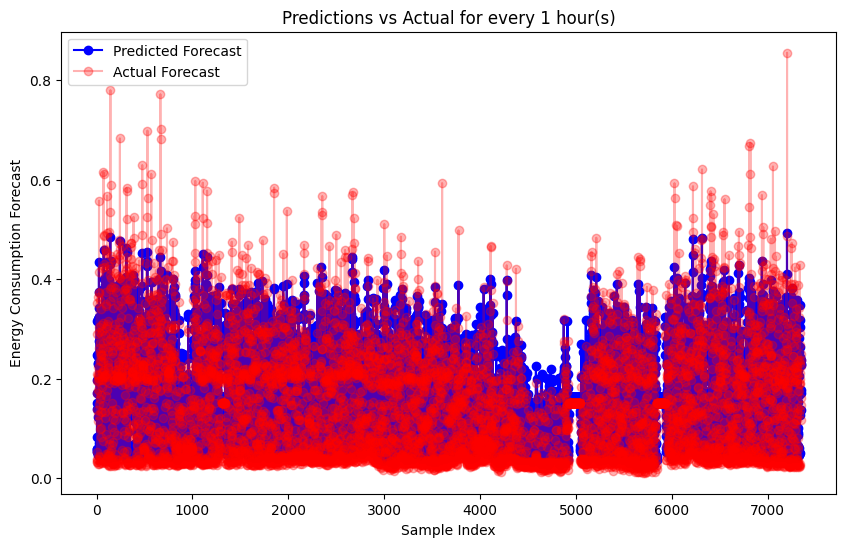

RMSE of LSTM Model for every 2 hour(s): 0.09834787681197851
MAE of LSTM Model for every 2 hour(s): 0.0781306523493687


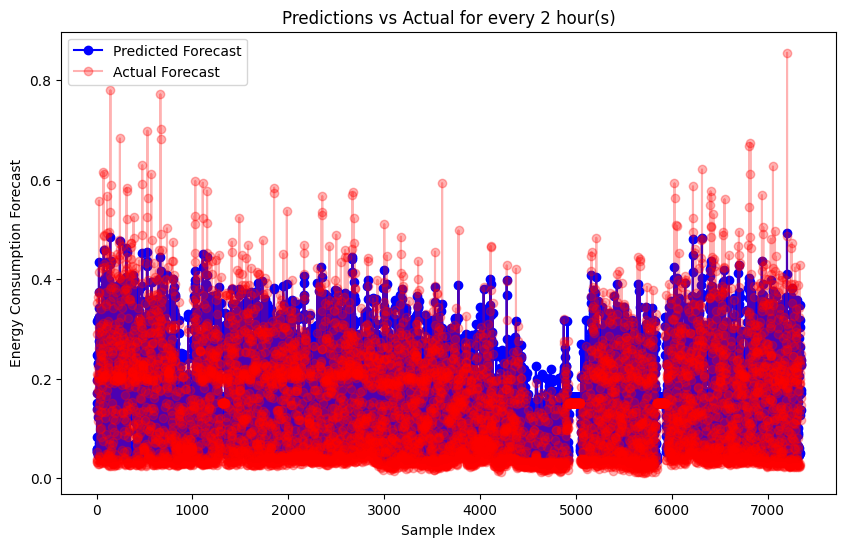

RMSE of LSTM Model for every 3 hour(s): 0.10753831507752638
MAE of LSTM Model for every 3 hour(s): 0.08812689329229041


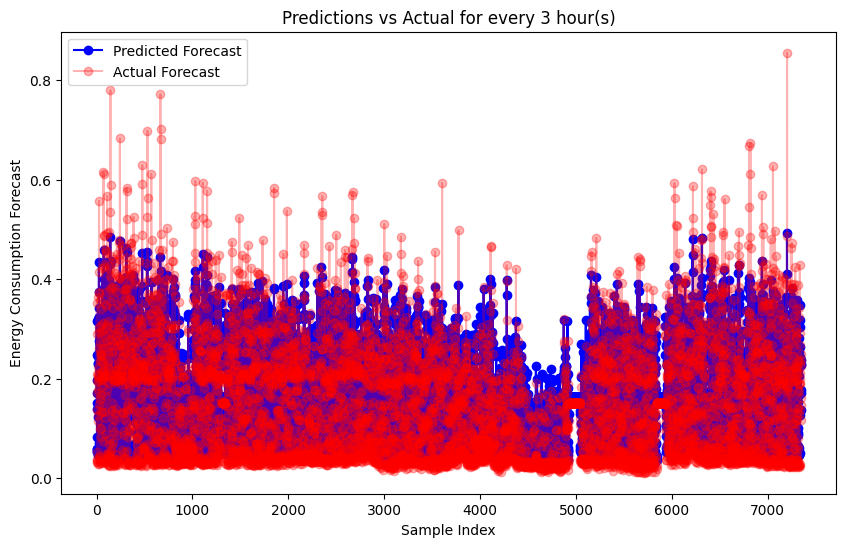

RMSE average for combined model 0.09769847422664057
MAE average for combined model 0.07633782715636948


In [6]:
# Assuming array1 and array2 are your two arrays of shape (6811, 1)
# Compute RMSE and MAE
from sklearn.metrics import mean_absolute_error

rmse_lstm = []
mae_lstm = []

for i in range(3):
  rmse = np.sqrt(mean_squared_error(y_pred_combined_list[i], test_y_list[i]))
  mae = mean_absolute_error(y_pred_combined_list[i], test_y_list[i])

  rmse_lstm.append(rmse)
  mae_lstm.append(mae)

  print(f"RMSE of LSTM Model for every {i+1} hour(s): {rmse}")
  print(f"MAE of LSTM Model for every {i+1} hour(s): {mae}")

  # Plot the line plot
  plt.figure(figsize=(10, 6))
  plt.plot(y_pred_combined_list[0], label='Predicted Forecast', linestyle='-', marker='o', color='blue', alpha=1)
  plt.plot(test_y_list[0], label='Actual Forecast', linestyle='-', marker='o', color='red', alpha = 0.3)
  plt.title(f'Predictions vs Actual for every {i+1} hour(s)')
  plt.xlabel('Sample Index')
  plt.ylabel('Energy Consumption Forecast')
  plt.legend()
  plt.show()

print(f"RMSE average for combined model", np.average(rmse_lstm))
print(f"MAE average for combined model", np.average(mae_lstm))